In [1035]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15,9
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

df = pd.read_csv('formatted_cleanParking.csv')
df2 = pd.read_csv('formatted_cleanParking.csv')

In [819]:
df2.head()

uuid       asset_id  \
0  SENSITY-kc-23-40D98DC1-41F8-40EE-BBB8-E44DE41C...  SENSITY-kc-23   
1  SENSITY-kc-22-E5EBBB3A-05E4-4D9C-97CB-26542918...  SENSITY-kc-22   
2  SENSITY-kc-10-C4D472BA-65CA-4D2B-A6C0-9C3981CD...  SENSITY-kc-10   
3  SENSITY-kc-12-4C26D1EC-4CCE-4E9A-87D1-D93149F5...  SENSITY-kc-12   
4  SENSITY-kc-9-CDDB22AD-31F6-4A11-BC94-CCC6602575A1   SENSITY-kc-9   

   sensor_id               start_time session_type  \
0        NaN  2018-08-10 23:33:26.081          car   
1        NaN  2018-08-10 23:34:58.454          car   
2        NaN  2018-08-10 23:33:40.424          car   
3        NaN  2018-08-10 23:34:44.149          car   
4        NaN  2018-08-10 23:37:38.946          car   

                     end_time   latitude  longitude  \
0    2018-08-10 23:33:55.9371  39.109786 -94.583482   
1  2018-08-10 23:36:08.256733  39.109536 -94.580771   
2  2018-08-10 23:36:25.890125  39.094360 -94.583396   
3  2018-08-10 23:38:53.829785  39.095302 -94.583515   
4  2018-08-10 23:39:01.415632  39.092984 -94.583621   

                                            geometry  
0  {"type":"Polygon","coordinates":[[[-94.5834598...  
1  {"type":"Polygon","coordinates":[[[-94.5807547...  
2  {"type":"Polygon","coordinates":[[[-94.5834062...  
3  {"type":"Polygon","coordinates":[[[-94.5835249...  
4  {"type":"Polygon","coordinates":[[[-94.5836287...

start_time summary  temperature                 time  \
0 2018-08-10 05:00:00   Clear        71.57  2018-08-10 05:00:00   
1 2018-08-10 06:00:00   Clear        71.70  2018-08-10 06:00:00   
2 2018-08-10 07:00:00   Clear        71.02  2018-08-10 07:00:00   
3 2018-08-10 08:00:00   Clear        69.70  2018-08-10 08:00:00   
4 2018-08-10 09:00:00   Clear        70.00  2018-08-10 09:00:00   

                                          time_range  
0  [2018-08-10 05:00:00, 2018-08-10 05:05:00, 201...  
1  [2018-08-10 06:00:00, 2018-08-10 06:05:00, 201...  
2  [2018-08-10 07:00:00, 2018-08-10 07:05:00, 201...  
3  [2018-08-10 08:00:00, 2018-08-10 08:05:00, 201...  
4  [2018-08-10 09:00:00, 2018-08-10 09:05:00, 201...

In [8]:
df.drop(columns={'sensor_id'},inplace=True)

In [10]:
df.dropna(axis=0,how='any',inplace=True)

In [11]:
df.drop(columns='geometry',inplace=True)
df.drop(columns='session_type',inplace=True)

In [12]:
df.drop(columns='uuid',inplace=True)

In [13]:
df.drop(columns='latitude',inplace=True)
df.drop(columns='longitude',inplace=True)

In [14]:
df.shape

(274366, 3)

In [15]:
df.rename(columns={'start_time':'start_date','end_time':'end_date'},inplace=True)

In [16]:
# Before
df.dtypes

asset_id      object
start_date    object
end_date      object
dtype: object

In [17]:
df['start_date'] = pd.to_datetime(df.start_date,format='%Y/%m/%d').astype('datetime64[s]')
df['end_date'] = pd.to_datetime(df.end_date,format='%Y/%m/%d').astype('datetime64[s]')

In [18]:
# After
df.dtypes

asset_id              object
start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

In [19]:
dist_df = df[['asset_id','start_date','end_date']].drop_duplicates()

In [20]:
dist_df.shape

(271680, 3)

In [21]:
temp = pd.to_datetime('2018-08-10',format='%Y\%m\%d')
dist_df.loc[(pd.to_datetime(dist_df.start_date.dt.date) == temp) & (
    dist_df['asset_id']=='SENSITY-kc-2')].sort_values(by=['start_date'],ascending=True)

asset_id          start_date            end_date
7     SENSITY-kc-2 2018-08-10 23:33:24 2018-08-10 23:47:47
296   SENSITY-kc-2 2018-08-10 23:38:34 2018-08-10 23:47:47
298   SENSITY-kc-2 2018-08-10 23:47:47 2018-08-10 23:50:55
299   SENSITY-kc-2 2018-08-10 23:48:14 2018-08-10 23:53:05
1809  SENSITY-kc-2 2018-08-10 23:48:14 2018-08-10 23:50:55
1935  SENSITY-kc-2 2018-08-10 23:48:23 2018-08-10 23:53:05
504   SENSITY-kc-2 2018-08-10 23:50:59 2018-08-10 23:53:05
507   SENSITY-kc-2 2018-08-10 23:53:05 2018-08-11 00:01:13
1813  SENSITY-kc-2 2018-08-10 23:53:06 2018-08-11 00:01:28

In [22]:
dist_df['start_from_fc']= dist_df.start_date.dt.floor('5min')
dist_df['end_from_fc'] = dist_df.end_date.dt.ceil('5min')

In [23]:
dist_df.isnull().sum()

asset_id         0
start_date       0
end_date         0
start_from_fc    0
end_from_fc      0
dtype: int64

In [24]:
dist_df.dtypes

asset_id                 object
start_date       datetime64[ns]
end_date         datetime64[ns]
start_from_fc    datetime64[ns]
end_from_fc      datetime64[ns]
dtype: object

In [25]:
dist_df.head()

asset_id          start_date            end_date       start_from_fc  \
0  SENSITY-kc-23 2018-08-10 23:33:26 2018-08-10 23:33:55 2018-08-10 23:30:00   
1  SENSITY-kc-22 2018-08-10 23:34:58 2018-08-10 23:36:08 2018-08-10 23:30:00   
2  SENSITY-kc-10 2018-08-10 23:33:40 2018-08-10 23:36:25 2018-08-10 23:30:00   
3  SENSITY-kc-12 2018-08-10 23:34:44 2018-08-10 23:38:53 2018-08-10 23:30:00   
4   SENSITY-kc-9 2018-08-10 23:37:38 2018-08-10 23:39:01 2018-08-10 23:35:00   

          end_from_fc  
0 2018-08-10 23:35:00  
1 2018-08-10 23:40:00  
2 2018-08-10 23:40:00  
3 2018-08-10 23:40:00  
4 2018-08-10 23:40:00

In [26]:
temp = pd.to_datetime('2018-08-10',format='%Y\%m\%d')
dist_df.loc[(pd.to_datetime(df.start_date.dt.date) == temp) & (
    dist_df['asset_id']=='SENSITY-kc-2')].sort_values(by=['start_date'],ascending=True)

asset_id          start_date            end_date  \
7     SENSITY-kc-2 2018-08-10 23:33:24 2018-08-10 23:47:47   
296   SENSITY-kc-2 2018-08-10 23:38:34 2018-08-10 23:47:47   
298   SENSITY-kc-2 2018-08-10 23:47:47 2018-08-10 23:50:55   
299   SENSITY-kc-2 2018-08-10 23:48:14 2018-08-10 23:53:05   
1809  SENSITY-kc-2 2018-08-10 23:48:14 2018-08-10 23:50:55   
1935  SENSITY-kc-2 2018-08-10 23:48:23 2018-08-10 23:53:05   
504   SENSITY-kc-2 2018-08-10 23:50:59 2018-08-10 23:53:05   
507   SENSITY-kc-2 2018-08-10 23:53:05 2018-08-11 00:01:13   
1813  SENSITY-kc-2 2018-08-10 23:53:06 2018-08-11 00:01:28   

           start_from_fc         end_from_fc  
7    2018-08-10 23:30:00 2018-08-10 23:50:00  
296  2018-08-10 23:35:00 2018-08-10 23:50:00  
298  2018-08-10 23:45:00 2018-08-10 23:55:00  
299  2018-08-10 23:45:00 2018-08-10 23:55:00  
1809 2018-08-10 23:45:00 2018-08-10 23:55:00  
1935 2018-08-10 23:45:00 2018-08-10 23:55:00  
504  2018-08-10 23:50:00 2018-08-10 23:55:00  
507  2018-08-10 23:50:00 2018-08-11 00:05:00  
1813 2018-08-10 23:50:00 2018-08-11 00:05:00

In [27]:
n = (dist_df.end_from_fc - dist_df.start_from_fc)
# n,(n.dt.total_seconds())/60
dist_df['diff'] = (n.dt.total_seconds())/60

In [28]:
dist_df.head(50)

asset_id          start_date            end_date       start_from_fc  \
0   SENSITY-kc-23 2018-08-10 23:33:26 2018-08-10 23:33:55 2018-08-10 23:30:00   
1   SENSITY-kc-22 2018-08-10 23:34:58 2018-08-10 23:36:08 2018-08-10 23:30:00   
2   SENSITY-kc-10 2018-08-10 23:33:40 2018-08-10 23:36:25 2018-08-10 23:30:00   
3   SENSITY-kc-12 2018-08-10 23:34:44 2018-08-10 23:38:53 2018-08-10 23:30:00   
4    SENSITY-kc-9 2018-08-10 23:37:38 2018-08-10 23:39:01 2018-08-10 23:35:00   
5   SENSITY-kc-14 2018-08-10 23:34:12 2018-08-10 23:39:38 2018-08-10 23:30:00   
6   SENSITY-kc-18 2018-08-10 23:36:28 2018-08-10 23:40:19 2018-08-10 23:35:00   
7    SENSITY-kc-2 2018-08-10 23:33:24 2018-08-10 23:47:47 2018-08-10 23:30:00   
8   SENSITY-kc-12 2018-08-10 23:47:25 2018-08-10 23:47:50 2018-08-10 23:45:00   
9   SENSITY-kc-21 2018-08-10 23:47:51 2018-08-10 23:49:26 2018-08-10 23:45:00   
10  SENSITY-kc-21 2018-08-10 23:49:23 2018-08-10 23:51:11 2018-08-10 23:45:00   
11   SENSITY-kc-8 2018-08-10 23:45:06 2018-08-10 23:54:05 2018-08-10 23:45:00   
12   SENSITY-kc-9 2018-08-10 23:50:59 2018-08-10 23:54:44 2018-08-10 23:50:00   
13  SENSITY-kc-10 2018-08-10 23:48:31 2018-08-10 23:55:04 2018-08-10 23:45:00   
14   SENSITY-kc-8 2018-08-10 23:54:05 2018-08-10 23:56:43 2018-08-10 23:50:00   
15   SENSITY-kc-8 2018-08-10 23:57:21 2018-08-10 23:58:20 2018-08-10 23:55:00   
16  SENSITY-kc-12 2018-08-10 23:55:31 2018-08-11 00:03:00 2018-08-10 23:55:00   
17  SENSITY-kc-14 2018-08-11 00:00:39 2018-08-11 00:03:45 2018-08-11 00:00:00   
18  SENSITY-kc-12 2018-08-11 00:10:46 2018-08-11 00:11:22 2018-08-11 00:10:00   
19  SENSITY-kc-14 2018-08-11 00:17:05 2018-08-11 00:21:41 2018-08-11 00:15:00   
20   SENSITY-kc-2 2018-08-11 00:08:57 2018-08-11 00:23:55 2018-08-11 00:05:00   
21  SENSITY-kc-10 2018-08-11 00:24:21 2018-08-11 00:26:28 2018-08-11 00:20:00   
22   SENSITY-kc-9 2018-08-11 00:27:15 2018-08-11 00:27:40 2018-08-11 00:25:00   
23  SENSITY-kc-15 2018-08-11 00:13:12 2018-08-11 00:31:25 2018-08-11 00:10:00   
24  SENSITY-kc-23 2018-08-11 00:33:27 2018-08-11 00:34:15 2018-08-11 00:30:00   
25  SENSITY-kc-14 2018-08-11 00:36:50 2018-08-11 00:38:16 2018-08-11 00:35:00   
26  SENSITY-kc-10 2018-08-11 00:27:41 2018-08-11 00:41:29 2018-08-11 00:25:00   
27  SENSITY-kc-10 2018-08-11 00:38:26 2018-08-11 00:41:32 2018-08-11 00:35:00   
28  SENSITY-kc-18 2018-08-11 00:36:29 2018-08-11 00:44:14 2018-08-11 00:35:00   
29  SENSITY-kc-15 2018-08-11 00:45:25 2018-08-11 00:47:32 2018-08-11 00:45:00   
30  SENSITY-kc-10 2018-08-11 00:46:26 2018-08-11 00:48:34 2018-08-11 00:45:00   
31  SENSITY-kc-18 2018-08-11 00:50:55 2018-08-11 00:54:44 2018-08-11 00:50:00   
32   SENSITY-kc-9 2018-08-11 00:57:49 2018-08-11 00:59:28 2018-08-11 00:55:00   
33  SENSITY-kc-14 2018-08-11 01:08:50 2018-08-11 01:15:17 2018-08-11 01:05:00   
34  SENSITY-kc-23 2018-08-11 01:18:46 2018-08-11 01:20:18 2018-08-11 01:15:00   
35   SENSITY-kc-2 2018-08-11 01:26:00 2018-08-11 01:27:56 2018-08-11 01:25:00   
36  SENSITY-kc-14 2018-08-11 01:28:34 2018-08-11 01:29:10 2018-08-11 01:25:00   
37  SENSITY-kc-10 2018-08-11 00:56:35 2018-08-11 01:37:52 2018-08-11 00:55:00   
38   SENSITY-kc-5 2018-08-11 01:35:04 2018-08-11 01:38:07 2018-08-11 01:35:00   
39  SENSITY-kc-14 2018-08-11 01:38:22 2018-08-11 01:40:56 2018-08-11 01:35:00   
40   SENSITY-kc-5 2018-08-10 23:36:07 2018-08-11 01:43:18 2018-08-10 23:35:00   
41   SENSITY-kc-6 2018-08-11 01:37:00 2018-08-11 01:44:07 2018-08-11 01:35:00   
42  SENSITY-kc-14 2018-08-11 01:47:37 2018-08-11 01:48:15 2018-08-11 01:45:00   
43  SENSITY-kc-11 2018-08-11 01:16:40 2018-08-11 01:49:10 2018-08-11 01:15:00   
44  SENSITY-kc-10 2018-08-11 01:44:09 2018-08-11 01:49:42 2018-08-11 01:40:00   
45  SENSITY-kc-11 2018-08-11 00:51:53 2018-08-11 01:50:25 2018-08-11 00:50:00   
46  SENSITY-kc-14 2018-08-11 01:49:18 2018-08-11 01:51:33 2018-08-11 01:45:00   
47   SENSITY-kc-5 2018-08-11 01:51:53 2018-08-11 01:52:50 2018-08-11 01:50:00   
48  SENSITY-kc-23 2018-08-11 01:54:14 20

In [29]:
dist_df[dist_df['diff'].isnull()]

Empty DataFrame
Columns: [asset_id, start_date, end_date, start_from_fc, end_from_fc, diff]
Index: []

In [30]:
dist_df['slots'] = dist_df['diff']/5
dist_df['slots']=dist_df['slots'].astype('int64')
dist_df['bins'] = dist_df.slots.map( lambda x: np.arange(1,x+1,1) if x > 1.0 else np.arange(1,x+1))

In [31]:
dist_df.head()

asset_id          start_date            end_date       start_from_fc  \
0  SENSITY-kc-23 2018-08-10 23:33:26 2018-08-10 23:33:55 2018-08-10 23:30:00   
1  SENSITY-kc-22 2018-08-10 23:34:58 2018-08-10 23:36:08 2018-08-10 23:30:00   
2  SENSITY-kc-10 2018-08-10 23:33:40 2018-08-10 23:36:25 2018-08-10 23:30:00   
3  SENSITY-kc-12 2018-08-10 23:34:44 2018-08-10 23:38:53 2018-08-10 23:30:00   
4   SENSITY-kc-9 2018-08-10 23:37:38 2018-08-10 23:39:01 2018-08-10 23:35:00   

          end_from_fc  diff  slots    bins  
0 2018-08-10 23:35:00   5.0      1     [1]  
1 2018-08-10 23:40:00  10.0      2  [1, 2]  
2 2018-08-10 23:40:00  10.0      2  [1, 2]  
3 2018-08-10 23:40:00  10.0      2  [1, 2]  
4 2018-08-10 23:40:00   5.0      1     [1]

In [32]:
dist_df.dtypes

asset_id                 object
start_date       datetime64[ns]
end_date         datetime64[ns]
start_from_fc    datetime64[ns]
end_from_fc      datetime64[ns]
diff                    float64
slots                     int64
bins                     object
dtype: object

In [33]:
dist_df['start'] = dist_df.start_date.dt.date
dist_df['start'] = pd.to_datetime(dist_df.start,format='%Y\%m\%d')

In [34]:
dist_df.head(5)

asset_id          start_date            end_date       start_from_fc  \
0  SENSITY-kc-23 2018-08-10 23:33:26 2018-08-10 23:33:55 2018-08-10 23:30:00   
1  SENSITY-kc-22 2018-08-10 23:34:58 2018-08-10 23:36:08 2018-08-10 23:30:00   
2  SENSITY-kc-10 2018-08-10 23:33:40 2018-08-10 23:36:25 2018-08-10 23:30:00   
3  SENSITY-kc-12 2018-08-10 23:34:44 2018-08-10 23:38:53 2018-08-10 23:30:00   
4   SENSITY-kc-9 2018-08-10 23:37:38 2018-08-10 23:39:01 2018-08-10 23:35:00   

          end_from_fc  diff  slots    bins      start  
0 2018-08-10 23:35:00   5.0      1     [1] 2018-08-10  
1 2018-08-10 23:40:00  10.0      2  [1, 2] 2018-08-10  
2 2018-08-10 23:40:00  10.0      2  [1, 2] 2018-08-10  
3 2018-08-10 23:40:00  10.0      2  [1, 2] 2018-08-10  
4 2018-08-10 23:40:00   5.0      1     [1] 2018-08-10

In [35]:
def explode(df, lst_cols, fill_value=''):
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    idx_cols = df.columns.difference(lst_cols)
    lens = df[lst_cols[0]].str.len()
    if (lens > 0).all():
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [36]:
new_df=explode(dist_df, ['bins'], fill_value='')

In [37]:
new_df.isnull().sum()

asset_id         0
start_date       0
end_date         0
start_from_fc    0
end_from_fc      0
diff             0
slots            0
bins             0
start            0
dtype: int64

In [38]:
new_df[new_df['slots'].isnull()]

Empty DataFrame
Columns: [asset_id, start_date, end_date, start_from_fc, end_from_fc, diff, slots, bins, start]
Index: []

In [39]:
new_df['bins'] = (new_df.start_from_fc + pd.to_timedelta(5*(new_df['bins']), unit='m'))
new_df['bins1'] = new_df.bins - pd.to_timedelta(5, unit='m')

In [40]:
new_df.head(100)

asset_id          start_date            end_date       start_from_fc  \
0   SENSITY-kc-23 2018-08-10 23:33:26 2018-08-10 23:33:55 2018-08-10 23:30:00   
1   SENSITY-kc-22 2018-08-10 23:34:58 2018-08-10 23:36:08 2018-08-10 23:30:00   
2   SENSITY-kc-22 2018-08-10 23:34:58 2018-08-10 23:36:08 2018-08-10 23:30:00   
3   SENSITY-kc-10 2018-08-10 23:33:40 2018-08-10 23:36:25 2018-08-10 23:30:00   
4   SENSITY-kc-10 2018-08-10 23:33:40 2018-08-10 23:36:25 2018-08-10 23:30:00   
5   SENSITY-kc-12 2018-08-10 23:34:44 2018-08-10 23:38:53 2018-08-10 23:30:00   
6   SENSITY-kc-12 2018-08-10 23:34:44 2018-08-10 23:38:53 2018-08-10 23:30:00   
7    SENSITY-kc-9 2018-08-10 23:37:38 2018-08-10 23:39:01 2018-08-10 23:35:00   
8   SENSITY-kc-14 2018-08-10 23:34:12 2018-08-10 23:39:38 2018-08-10 23:30:00   
9   SENSITY-kc-14 2018-08-10 23:34:12 2018-08-10 23:39:38 2018-08-10 23:30:00   
10  SENSITY-kc-18 2018-08-10 23:36:28 2018-08-10 23:40:19 2018-08-10 23:35:00   
11  SENSITY-kc-18 2018-08-10 23:36:28 2018-08-10 23:40:19 2018-08-10 23:35:00   
12   SENSITY-kc-2 2018-08-10 23:33:24 2018-08-10 23:47:47 2018-08-10 23:30:00   
13   SENSITY-kc-2 2018-08-10 23:33:24 2018-08-10 23:47:47 2018-08-10 23:30:00   
14   SENSITY-kc-2 2018-08-10 23:33:24 2018-08-10 23:47:47 2018-08-10 23:30:00   
15   SENSITY-kc-2 2018-08-10 23:33:24 2018-08-10 23:47:47 2018-08-10 23:30:00   
16  SENSITY-kc-12 2018-08-10 23:47:25 2018-08-10 23:47:50 2018-08-10 23:45:00   
17  SENSITY-kc-21 2018-08-10 23:47:51 2018-08-10 23:49:26 2018-08-10 23:45:00   
18  SENSITY-kc-21 2018-08-10 23:49:23 2018-08-10 23:51:11 2018-08-10 23:45:00   
19  SENSITY-kc-21 2018-08-10 23:49:23 2018-08-10 23:51:11 2018-08-10 23:45:00   
20   SENSITY-kc-8 2018-08-10 23:45:06 2018-08-10 23:54:05 2018-08-10 23:45:00   
21   SENSITY-kc-8 2018-08-10 23:45:06 2018-08-10 23:54:05 2018-08-10 23:45:00   
22   SENSITY-kc-9 2018-08-10 23:50:59 2018-08-10 23:54:44 2018-08-10 23:50:00   
23  SENSITY-kc-10 2018-08-10 23:48:31 2018-08-10 23:55:04 2018-08-10 23:45:00   
24  SENSITY-kc-10 2018-08-10 23:48:31 2018-08-10 23:55:04 2018-08-10 23:45:00   
25  SENSITY-kc-10 2018-08-10 23:48:31 2018-08-10 23:55:04 2018-08-10 23:45:00   
26   SENSITY-kc-8 2018-08-10 23:54:05 2018-08-10 23:56:43 2018-08-10 23:50:00   
27   SENSITY-kc-8 2018-08-10 23:54:05 2018-08-10 23:56:43 2018-08-10 23:50:00   
28   SENSITY-kc-8 2018-08-10 23:57:21 2018-08-10 23:58:20 2018-08-10 23:55:00   
29  SENSITY-kc-12 2018-08-10 23:55:31 2018-08-11 00:03:00 2018-08-10 23:55:00   
..            ...                 ...                 ...                 ...   
70  SENSITY-kc-10 2018-08-11 00:56:35 2018-08-11 01:37:52 2018-08-11 00:55:00   
71  SENSITY-kc-10 2018-08-11 00:56:35 2018-08-11 01:37:52 2018-08-11 00:55:00   
72  SENSITY-kc-10 2018-08-11 00:56:35 2018-08-11 01:37:52 2018-08-11 00:55:00   
73  SENSITY-kc-10 2018-08-11 00:56:35 2018-08-11 01:37:52 2018-08-11 00:55:00   
74  SENSITY-kc-10 2018-08-11 00:56:35 2018-08-11 01:37:52 2018-08-11 00:55:00   
75  SENSITY-kc-10 2018-08-11 00:56:35 2018-08-11 01:37:52 2018-08-11 00:55:00   
76  SENSITY-kc-10 2018-08-11 00:56:35 2018-08-11 01:37:52 2018-08-11 00:55:00   
77   SENSITY-kc-5 2018-08-11 01:35:04 2018-08-11 01:38:07 2018-08-11 01:35:00   
78  SENSITY-kc-14 2018-08-11 01:38:22 2018-08-11 01:40:56 2018-08-11 01:35:00   
79  SENSITY-kc-14 2018-08-11 01:38:22 2018-08-11 01:40:56 2018-08-11 01:35:00   
80   SENSITY-kc-5 2018-08-10 23:36:07 2018-08-11 01:43:18 2018-08-10 23:35:00   
81   SENSITY-kc-5 2018-08-10 23:36:07 2018-08-11 01:43:18 2018-08-10 23:35:00   
82   SENSITY-kc-5 2018-08-10 23:36:07 2018-08-11 01:43:18 2018-08-10 23:35:00   
83   SENSITY-kc-5 2018-08-10 23:36:07 2018-08-11 01:43:18 2018-08-10 23:35:00   
84   SENSITY-kc-5 2018-08-10 23:36:07 2018-08-11 01:43:18 2018-08-10 23:35:00   
85   SENSITY-kc-5 2018-08-10 23:36:07 2018-08-11 01:43:18 2018-08-10 23:35:00   
86   SENSITY-kc-5 2018-08-10 23:36:07 2018-08-11 01:43:18 2018-08-10 23:35:00   
87   SENSITY-kc-5 2018-08-10 23:36:07 20

In [43]:
 new_df.groupby(['bins1','bins','asset_id']).count()[['start_from_fc']]

start_from_fc
bins1               bins                asset_id                    
2018-08-10 23:30:00 2018-08-10 23:35:00 SENSITY-kc-10              2
                                        SENSITY-kc-12              4
                                        SENSITY-kc-14              2
                                        SENSITY-kc-2               1
                                        SENSITY-kc-22              1
                                        SENSITY-kc-23              2
                                        SENSITY-kc-8               2
2018-08-10 23:35:00 2018-08-10 23:40:00 SENSITY-kc-10              4
                                        SENSITY-kc-12              4
                                        SENSITY-kc-14              5
                                        SENSITY-kc-18              2
                                        SENSITY-kc-2               2
                                        SENSITY-kc-22              2
                                        SENSITY-kc-5               4
                                        SENSITY-kc-8               2
                                        SENSITY-kc-9               2
2018-08-10 23:40:00 2018-08-10 23:45:00 SENSITY-kc-10              2
                                        SENSITY-kc-12              2
                                        SENSITY-kc-14              4
                                        SENSITY-kc-18              2
                                        SENSITY-kc-2               2
                                        SENSITY-kc-22              1
                                        SENSITY-kc-5               4
                                        SENSITY-kc-8               2
2018-08-10 23:45:00 2018-08-10 23:50:00 SENSITY-kc-10              3
                                        SENSITY-kc-12              2
                                        SENSITY-kc-14              8
                                        SENSITY-kc-2               6
                                        SENSITY-kc-21              4
                                        SENSITY-kc-22              1
...                                                              ...
2019-04-15 18:15:00 2019-04-15 18:20:00 SENSITY-kc-15              1
                                        SENSITY-kc-18              1
                                        SENSITY-kc-2               3
                                        SENSITY-kc-22              2
                                        SENSITY-kc-23              2
                                        SENSITY-kc-6               3
                                        SENSITY-kc-8               1
2019-04-15 18:20:00 2019-04-15 18:25:00 SENSITY-kc-10              1
                                        SENSITY-kc-12              1
                                        SENSITY-kc-14              4
                                        SENSITY-kc-15              1
                                        SENSITY-kc-17              1
                                        SENSITY-kc-18              1
                                        SENSITY-kc-23              1
                                        SENSITY-kc-4               1
                                        SENSITY-kc-6               3
                                        SENSITY-kc-8               2
2019-04-15 18:25:00 2019-04-15 18:30:00 SENSITY-kc-10              2
                                        SENSITY-kc-12              2
                                        SENSITY-kc-14              1
                                        SENSITY-kc-15              2
                                        SENSITY-kc-17              1
                                        SENSITY-kc-2               2
                                        SENSITY-kc-6               3
2019-04-15 18:30:00 2019-04-15 18:35:00 SENSITY-kc-12              2
                                        SENSITY-kc-14

In [44]:
df_5min = new_df.groupby(['bins1','bins','asset_id']).count()[['start_from_fc']].add_suffix('_Count').reset_index()

In [45]:
df_5min

bins1                bins       asset_id  \
0      2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10   
1      2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12   
2      2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-14   
3      2018-08-10 23:30:00 2018-08-10 23:35:00   SENSITY-kc-2   
4      2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-22   
5      2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-23   
6      2018-08-10 23:30:00 2018-08-10 23:35:00   SENSITY-kc-8   
7      2018-08-10 23:35:00 2018-08-10 23:40:00  SENSITY-kc-10   
8      2018-08-10 23:35:00 2018-08-10 23:40:00  SENSITY-kc-12   
9      2018-08-10 23:35:00 2018-08-10 23:40:00  SENSITY-kc-14   
10     2018-08-10 23:35:00 2018-08-10 23:40:00  SENSITY-kc-18   
11     2018-08-10 23:35:00 2018-08-10 23:40:00   SENSITY-kc-2   
12     2018-08-10 23:35:00 2018-08-10 23:40:00  SENSITY-kc-22   
13     2018-08-10 23:35:00 2018-08-10 23:40:00   SENSITY-kc-5   
14     2018-08-10 23:35:00 2018-08-10 23:40:00   SENSITY-kc-8   
15     2018-08-10 23:35:00 2018-08-10 23:40:00   SENSITY-kc-9   
16     2018-08-10 23:40:00 2018-08-10 23:45:00  SENSITY-kc-10   
17     2018-08-10 23:40:00 2018-08-10 23:45:00  SENSITY-kc-12   
18     2018-08-10 23:40:00 2018-08-10 23:45:00  SENSITY-kc-14   
19     2018-08-10 23:40:00 2018-08-10 23:45:00  SENSITY-kc-18   
20     2018-08-10 23:40:00 2018-08-10 23:45:00   SENSITY-kc-2   
21     2018-08-10 23:40:00 2018-08-10 23:45:00  SENSITY-kc-22   
22     2018-08-10 23:40:00 2018-08-10 23:45:00   SENSITY-kc-5   
23     2018-08-10 23:40:00 2018-08-10 23:45:00   SENSITY-kc-8   
24     2018-08-10 23:45:00 2018-08-10 23:50:00  SENSITY-kc-10   
25     2018-08-10 23:45:00 2018-08-10 23:50:00  SENSITY-kc-12   
26     2018-08-10 23:45:00 2018-08-10 23:50:00  SENSITY-kc-14   
27     2018-08-10 23:45:00 2018-08-10 23:50:00   SENSITY-kc-2   
28     2018-08-10 23:45:00 2018-08-10 23:50:00  SENSITY-kc-21   
29     2018-08-10 23:45:00 2018-08-10 23:50:00  SENSITY-kc-22   
...                    ...                 ...            ...   
701147 2019-04-15 18:15:00 2019-04-15 18:20:00  SENSITY-kc-15   
701148 2019-04-15 18:15:00 2019-04-15 18:20:00  SENSITY-kc-18   
701149 2019-04-15 18:15:00 2019-04-15 18:20:00   SENSITY-kc-2   
701150 2019-04-15 18:15:00 2019-04-15 18:20:00  SENSITY-kc-22   
701151 2019-04-15 18:15:00 2019-04-15 18:20:00  SENSITY-kc-23   
701152 2019-04-15 18:15:00 2019-04-15 18:20:00   SENSITY-kc-6   
701153 2019-04-15 18:15:00 2019-04-15 18:20:00   SENSITY-kc-8   
701154 2019-04-15 18:20:00 2019-04-15 18:25:00  SENSITY-kc-10   
701155 2019-04-15 18:20:00 2019-04-15 18:25:00  SENSITY-kc-12   
701156 2019-04-15 18:20:00 2019-04-15 18:25:00  SENSITY-kc-14   
701157 2019-04-15 18:20:00 2019-04-15 18:25:00  SENSITY-kc-15   
701158 2019-04-15 18:20:00 2019-04-15 18:25:00  SENSITY-kc-17   
701159 2019-04-15 18:20:00 2019-04-15 18:25:00  SENSITY-kc-18   
701160 2019-04-15 18:20:00 2019-04-15 18:25:00  SENSITY-kc-23   
701161 2019-04-15 18:20:00 2019-04-15 18:25:00   SENSITY-kc-4   
701162 2019-04-15 18:20:00 2019-04-15 18:25:00   SENSITY-kc-6   
701163 2019-04-15 18:20:00 2019-04-15 18:25:00   SENSITY-kc-8   
701164 2019-04-15 18:25:00 2019-04-15 18:30:00  SENSITY-kc-10   
701165 2019-04-15 18:25:00 2019-04-15 18:30:00  SENSITY-kc-12   
701166 2019-04-15 18:25:00 2019-04-15 18:30:00  SENSITY-kc-14   
701167 2019-04-15 18:25:00 2019-04-15 18:30:00  SENSITY-kc-15   
701168 2019-04-15 18:25:00 2019-04-15 18:30:00  SENSITY-kc-17   
701169 2019-04-15 18:25:00 2019-04-15 18:30:00   SENSITY-kc-2   
701170 2019-04-15 18:25:00 2019-04-15 18:30:00   SENSITY-kc-6   
701171 2019-04-15 18:30:00 2019-04-15 18:35:00  SENSITY-kc-12   
701172 2019-04-15 18:30:00 2019-04-15 18:35:00  SENSITY-kc-14   
701173 2019-04-15 18:30:00 2019-04-15 18:35:00  SENSITY-kc-15   
701174 2019-04-15 18:30:00 2019-04-15 18:35:00  SENSITY-kc-17   
701175 2019-04-15 18:30:00 2019-04-15 18:35:00   SENSITY-kc-2   
701176 2019-04-15 18:30:00 2019-04-15 18:35:00   SENSITY

In [46]:
df_5min.rename(columns={'bins1':'start_time','bins':'end_time','asset_id':'sensor_id'
                        ,'start_from_fc_Count':'no_of_cars'}
               ,inplace=True)

In [47]:
df_5min.head()

start_time            end_time      sensor_id  no_of_cars
0 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10           2
1 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12           4
2 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-14           2
3 2018-08-10 23:30:00 2018-08-10 23:35:00   SENSITY-kc-2           1
4 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-22           1

In [821]:
df_all_sensors_1stweek = df_5min.groupby(['sensor_id',df_5min.start_time.dt.dayofweek])\
.sum()[['no_of_cars']].add_suffix('_Count').reset_index()

In [822]:
df_pivot_sen = df_all_sensors_1stweek.pivot(index='start_time', columns='sensor_id', values='no_of_cars_Count')

In [823]:
df_pivot_sen.fillna(0,inplace=True)

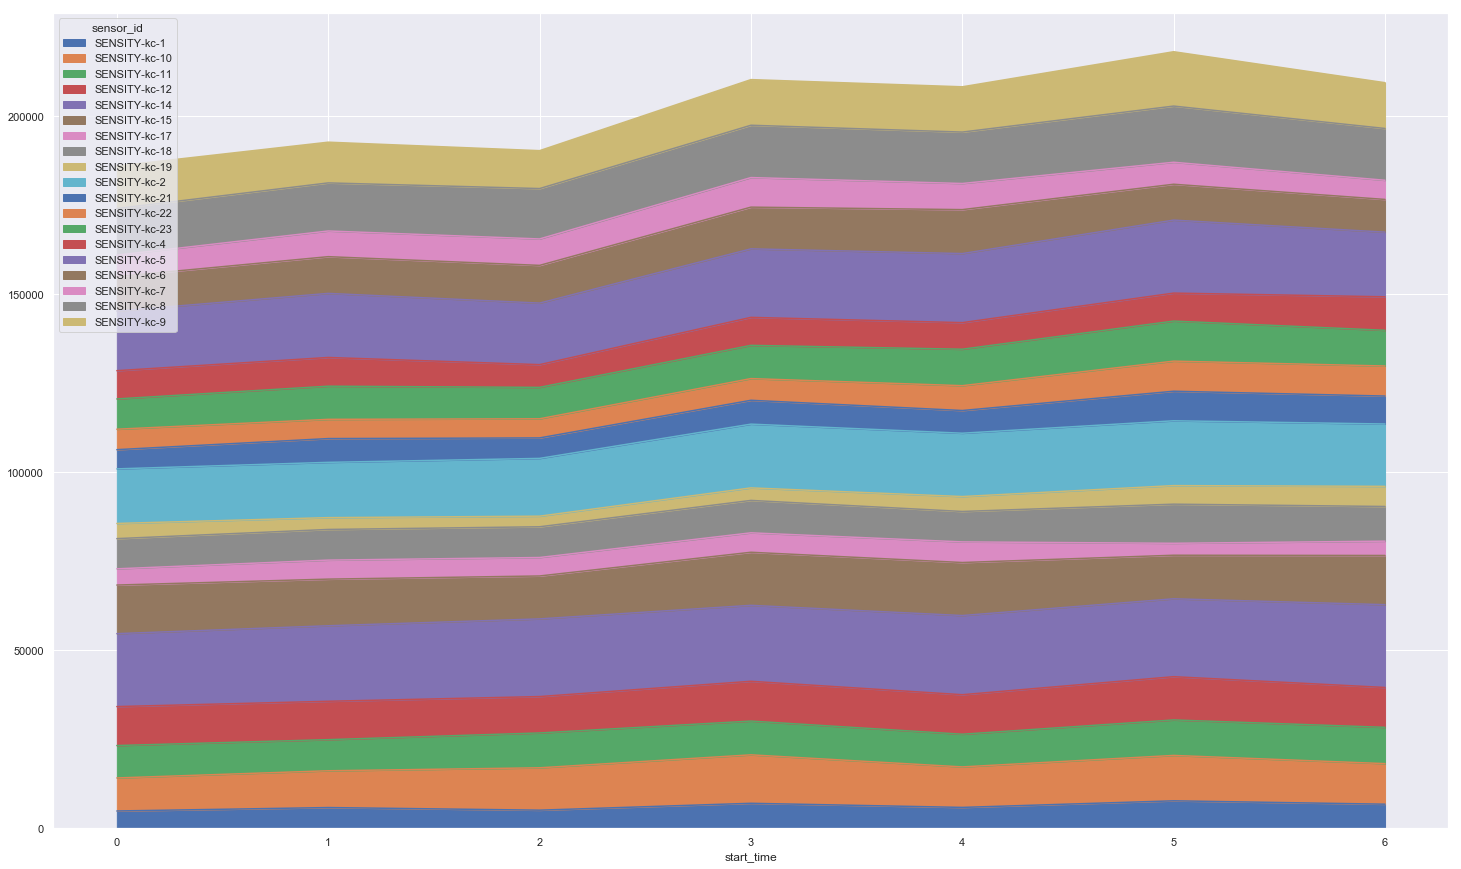

In [825]:
df_pivot_sen.plot(kind='area', 
#              stacked=False,
             figsize=(25, 15), # pass a tuple (x, y) size
             )

In [840]:
x=df_5min.groupby(['sensor_id']).count()[['no_of_cars']]

In [864]:
df_5min.groupby(['sensor_id']).count()[['no_of_cars']].reset_index().sort_values(by=['no_of_cars'],ascending=True)

sensor_id  no_of_cars
8   SENSITY-kc-19       21151
11  SENSITY-kc-22       26492
16   SENSITY-kc-7       28737
10  SENSITY-kc-21       28843
12  SENSITY-kc-23       29811
6   SENSITY-kc-17       30207
0    SENSITY-kc-1       31200
15   SENSITY-kc-6       36232
2   SENSITY-kc-11       37196
7   SENSITY-kc-18       37199
3   SENSITY-kc-12       38275
13   SENSITY-kc-4       39405
1   SENSITY-kc-10       39700
18   SENSITY-kc-9       39793
17   SENSITY-kc-8       42430
5   SENSITY-kc-15       45362
14   SENSITY-kc-5       46410
9    SENSITY-kc-2       50427
4   SENSITY-kc-14       52307

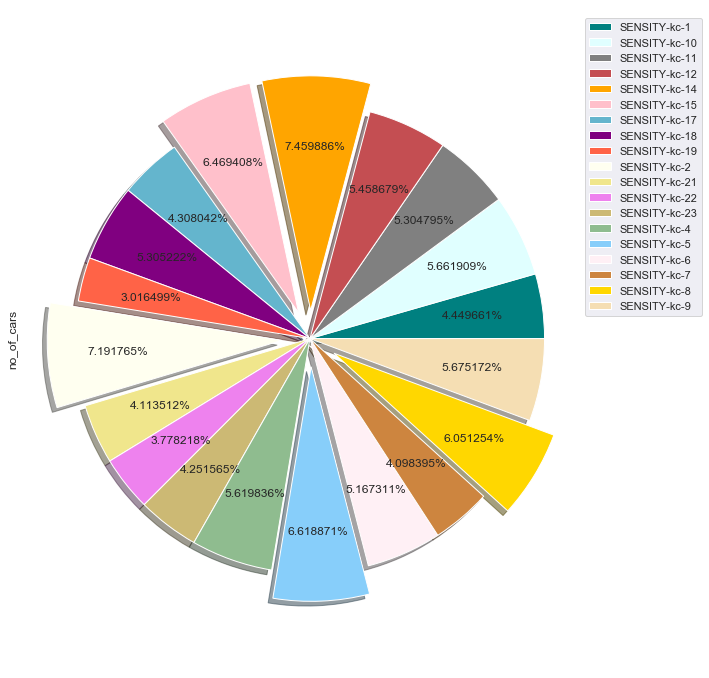

In [918]:
colors_list = [ 'teal', 'lightcyan','grey','r','orange','pink','c'\
              ,'purple','tomato','ivory','khaki','violet','y','darkseagreen'\
               ,'lightskyblue','lavenderblush','peru','gold','wheat']
explode_list = [0, 0, 0\
                ,0,0.12,0.12\
                ,0,0,0,0.12,0, 0, 0, 0,0.12,0, 0, 0.12, 0] 
df_5min.groupby(['sensor_id']).count()[['no_of_cars']].plot(kind='pie',
                     figsize=(10, 12),
                            autopct='%f%%', 
                            startangle=0,     
                            shadow=True,  
                            subplots=True,
                                labels=None,         
                            pctdistance=0.7,    
                            colors=colors_list, 
                            explode=explode_list)
plt.legend(labels=x.index,loc="upper left", bbox_to_anchor = (1.0,1)) 
plt.axis('equal') 
plt.show()

In [56]:
df_5min.to_csv('final_formatted_5mins_bins.csv')

In [49]:
df_5min.groupby(['sensor_id']).sum()[['no_of_cars']]

no_of_cars
sensor_id                
SENSITY-kc-1        43167
SENSITY-kc-10       80639
SENSITY-kc-11       66445
SENSITY-kc-12       77563
SENSITY-kc-14      152207
SENSITY-kc-15       94648
SENSITY-kc-17       33711
SENSITY-kc-18       64097
SENSITY-kc-19       29145
SENSITY-kc-2       118489
SENSITY-kc-21       47045
SENSITY-kc-22       46489
SENSITY-kc-23       67493
SENSITY-kc-4        54974
SENSITY-kc-5       129332
SENSITY-kc-6        73886
SENSITY-kc-7        47860
SENSITY-kc-8       100220
SENSITY-kc-9        87668

In [102]:
df_5min.head()

start_time            end_time      sensor_id  no_of_cars
0 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10           2
1 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12           4
2 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-14           2
3 2018-08-10 23:30:00 2018-08-10 23:35:00   SENSITY-kc-2           1
4 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-22           1

In [532]:
checkD = df_5min.groupby([df_5min.start_time.dt.date]).count()[['no_of_cars']]

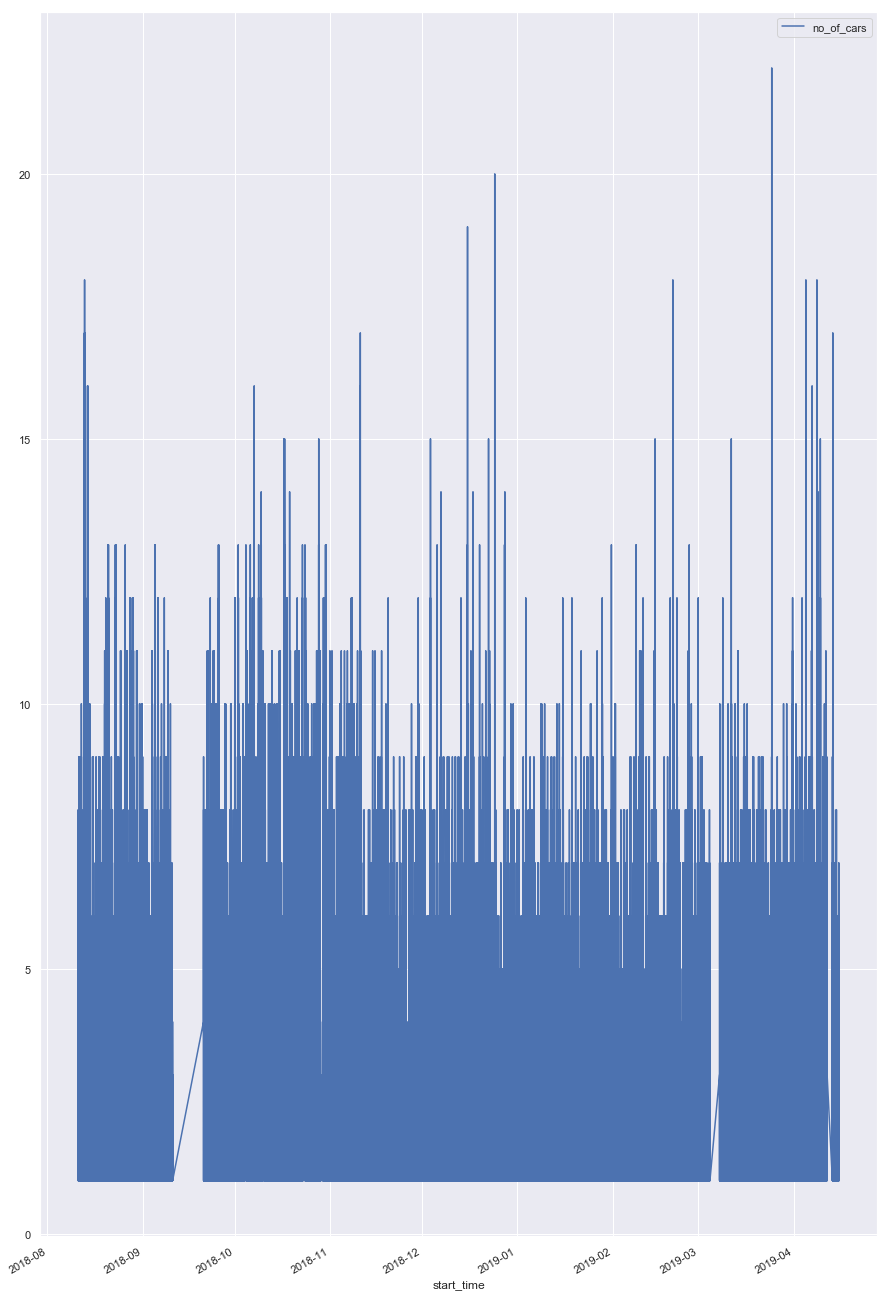

In [647]:
df_5min[['start_time','no_of_cars']].set_index('start_time').plot()

In [533]:
checkD = checkD.reset_index()
checkD.head()

start_time  no_of_cars
0  2018-08-10          52
1  2018-08-11        3637
2  2018-08-12        3278
3  2018-08-13        3489
4  2018-08-14        3884

In [536]:
checkD['start_time'] = pd.to_datetime(checkD.start_time,format='%Y\%m\%d')

start_time  no_of_cars
0 2018-08-10          52

In [648]:
checkD.loc[(checkD.start_time>='2018-09-01') & (checkD.start_time<='2018-09-30')]

start_time  no_of_cars
22 2018-09-01        2904
23 2018-09-02        3281
24 2018-09-03        2522
25 2018-09-04        3500
26 2018-09-05        2913
27 2018-09-06        3289
28 2018-09-07        2542
29 2018-09-08        2710
30 2018-09-09        3540
31 2018-09-10        1728
32 2018-09-20         737
33 2018-09-21        2802
34 2018-09-22        3345
35 2018-09-23        3107
36 2018-09-24        3160
37 2018-09-25        3906
38 2018-09-26        2457
39 2018-09-27        2290
40 2018-09-28        3493
41 2018-09-29        3155
42 2018-09-30        2773

In [649]:
checkD.loc[(checkD.start_time>='2019-03-01') & (checkD.start_time<='2019-03-30')]

start_time  no_of_cars
194 2019-03-01        3462
195 2019-03-02        3330
196 2019-03-03        2195
197 2019-03-04        2225
198 2019-03-07         529
199 2019-03-08        2975
200 2019-03-09        3339
201 2019-03-10        3167
202 2019-03-11        2721
203 2019-03-12        2822
204 2019-03-13        3043
205 2019-03-14        3378
206 2019-03-15        3287
207 2019-03-16        3419
208 2019-03-17        3613
209 2019-03-18        3261
210 2019-03-19        3023
211 2019-03-20        2728
212 2019-03-21        2803
213 2019-03-22        3185
214 2019-03-23        3331
215 2019-03-24        3261
216 2019-03-25        2764
217 2019-03-26        2871
218 2019-03-27        3511
219 2019-03-28        3063
220 2019-03-29        3093
221 2019-03-30        2947

In [650]:
checkD.loc[(checkD.start_time>='2019-04-01') & (checkD.start_time<='2019-04-30')]

start_time  no_of_cars
223 2019-04-01        2635
224 2019-04-02        2986
225 2019-04-03        2672
226 2019-04-04        2677
227 2019-04-05        3133
228 2019-04-06        3437
229 2019-04-07        3554
230 2019-04-08        2623
231 2019-04-09        3214
232 2019-04-10        3352
233 2019-04-11        2589
234 2019-04-13        1782
235 2019-04-14        3593
236 2019-04-15        1844

In [550]:
df_sept_5min = df_5min.loc[(df_5min['sensor_id']=='SENSITY-kc-14')  &
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  < '2018-09-20')
                      ][['start_time','no_of_cars']]

In [565]:
temp_data=[]
time = dt.datetime(2018, 8, 9, 0, 0, 0)
print('starting',time)
for x in np.arange(0,32,1):
#     print(time+ pd.to_timedelta(x,unit='d'))
    time=time+ pd.DateOffset(1)
#     print(time)
    for y in np.arange(0,1440, 5):
#         print(time+ pd.to_timedelta(y, unit='m'))
        val=time+ pd.to_timedelta(y, unit='m')
        print(val)
        temp_data.append(val)

starting 2018-08-09 00:00:00
2018-08-10 00:00:00
2018-08-10 00:05:00
2018-08-10 00:10:00
2018-08-10 00:15:00
2018-08-10 00:20:00
2018-08-10 00:25:00
2018-08-10 00:30:00
2018-08-10 00:35:00
2018-08-10 00:40:00
2018-08-10 00:45:00
2018-08-10 00:50:00
2018-08-10 00:55:00
2018-08-10 01:00:00
2018-08-10 01:05:00
2018-08-10 01:10:00
2018-08-10 01:15:00
2018-08-10 01:20:00
2018-08-10 01:25:00
2018-08-10 01:30:00
2018-08-10 01:35:00
2018-08-10 01:40:00
2018-08-10 01:45:00
2018-08-10 01:50:00
2018-08-10 01:55:00
2018-08-10 02:00:00
2018-08-10 02:05:00
2018-08-10 02:10:00
2018-08-10 02:15:00
2018-08-10 02:20:00
2018-08-10 02:25:00
2018-08-10 02:30:00
2018-08-10 02:35:00
2018-08-10 02:40:00
2018-08-10 02:45:00
2018-08-10 02:50:00
2018-08-10 02:55:00
2018-08-10 03:00:00
2018-08-10 03:05:00
2018-08-10 03:10:00
2018-08-10 03:15:00
2018-08-10 03:20:00
2018-08-10 03:25:00
2018-08-10 03:30:00
2018-08-10 03:35:00
2018-08-10 03:40:00
2018-08-10 03:45:00
2018-08-10 03:50:00
2018-08-10 03:55:00
2018-08-10 

2018-08-15 17:30:00
2018-08-15 17:35:00
2018-08-15 17:40:00
2018-08-15 17:45:00
2018-08-15 17:50:00
2018-08-15 17:55:00
2018-08-15 18:00:00
2018-08-15 18:05:00
2018-08-15 18:10:00
2018-08-15 18:15:00
2018-08-15 18:20:00
2018-08-15 18:25:00
2018-08-15 18:30:00
2018-08-15 18:35:00
2018-08-15 18:40:00
2018-08-15 18:45:00
2018-08-15 18:50:00
2018-08-15 18:55:00
2018-08-15 19:00:00
2018-08-15 19:05:00
2018-08-15 19:10:00
2018-08-15 19:15:00
2018-08-15 19:20:00
2018-08-15 19:25:00
2018-08-15 19:30:00
2018-08-15 19:35:00
2018-08-15 19:40:00
2018-08-15 19:45:00
2018-08-15 19:50:00
2018-08-15 19:55:00
2018-08-15 20:00:00
2018-08-15 20:05:00
2018-08-15 20:10:00
2018-08-15 20:15:00
2018-08-15 20:20:00
2018-08-15 20:25:00
2018-08-15 20:30:00
2018-08-15 20:35:00
2018-08-15 20:40:00
2018-08-15 20:45:00
2018-08-15 20:50:00
2018-08-15 20:55:00
2018-08-15 21:00:00
2018-08-15 21:05:00
2018-08-15 21:10:00
2018-08-15 21:15:00
2018-08-15 21:20:00
2018-08-15 21:25:00
2018-08-15 21:30:00
2018-08-15 21:35:00


2018-08-19 21:30:00
2018-08-19 21:35:00
2018-08-19 21:40:00
2018-08-19 21:45:00
2018-08-19 21:50:00
2018-08-19 21:55:00
2018-08-19 22:00:00
2018-08-19 22:05:00
2018-08-19 22:10:00
2018-08-19 22:15:00
2018-08-19 22:20:00
2018-08-19 22:25:00
2018-08-19 22:30:00
2018-08-19 22:35:00
2018-08-19 22:40:00
2018-08-19 22:45:00
2018-08-19 22:50:00
2018-08-19 22:55:00
2018-08-19 23:00:00
2018-08-19 23:05:00
2018-08-19 23:10:00
2018-08-19 23:15:00
2018-08-19 23:20:00
2018-08-19 23:25:00
2018-08-19 23:30:00
2018-08-19 23:35:00
2018-08-19 23:40:00
2018-08-19 23:45:00
2018-08-19 23:50:00
2018-08-19 23:55:00
2018-08-20 00:00:00
2018-08-20 00:05:00
2018-08-20 00:10:00
2018-08-20 00:15:00
2018-08-20 00:20:00
2018-08-20 00:25:00
2018-08-20 00:30:00
2018-08-20 00:35:00
2018-08-20 00:40:00
2018-08-20 00:45:00
2018-08-20 00:50:00
2018-08-20 00:55:00
2018-08-20 01:00:00
2018-08-20 01:05:00
2018-08-20 01:10:00
2018-08-20 01:15:00
2018-08-20 01:20:00
2018-08-20 01:25:00
2018-08-20 01:30:00
2018-08-20 01:35:00


2018-08-24 09:45:00
2018-08-24 09:50:00
2018-08-24 09:55:00
2018-08-24 10:00:00
2018-08-24 10:05:00
2018-08-24 10:10:00
2018-08-24 10:15:00
2018-08-24 10:20:00
2018-08-24 10:25:00
2018-08-24 10:30:00
2018-08-24 10:35:00
2018-08-24 10:40:00
2018-08-24 10:45:00
2018-08-24 10:50:00
2018-08-24 10:55:00
2018-08-24 11:00:00
2018-08-24 11:05:00
2018-08-24 11:10:00
2018-08-24 11:15:00
2018-08-24 11:20:00
2018-08-24 11:25:00
2018-08-24 11:30:00
2018-08-24 11:35:00
2018-08-24 11:40:00
2018-08-24 11:45:00
2018-08-24 11:50:00
2018-08-24 11:55:00
2018-08-24 12:00:00
2018-08-24 12:05:00
2018-08-24 12:10:00
2018-08-24 12:15:00
2018-08-24 12:20:00
2018-08-24 12:25:00
2018-08-24 12:30:00
2018-08-24 12:35:00
2018-08-24 12:40:00
2018-08-24 12:45:00
2018-08-24 12:50:00
2018-08-24 12:55:00
2018-08-24 13:00:00
2018-08-24 13:05:00
2018-08-24 13:10:00
2018-08-24 13:15:00
2018-08-24 13:20:00
2018-08-24 13:25:00
2018-08-24 13:30:00
2018-08-24 13:35:00
2018-08-24 13:40:00
2018-08-24 13:45:00
2018-08-24 13:50:00


2018-08-29 14:45:00
2018-08-29 14:50:00
2018-08-29 14:55:00
2018-08-29 15:00:00
2018-08-29 15:05:00
2018-08-29 15:10:00
2018-08-29 15:15:00
2018-08-29 15:20:00
2018-08-29 15:25:00
2018-08-29 15:30:00
2018-08-29 15:35:00
2018-08-29 15:40:00
2018-08-29 15:45:00
2018-08-29 15:50:00
2018-08-29 15:55:00
2018-08-29 16:00:00
2018-08-29 16:05:00
2018-08-29 16:10:00
2018-08-29 16:15:00
2018-08-29 16:20:00
2018-08-29 16:25:00
2018-08-29 16:30:00
2018-08-29 16:35:00
2018-08-29 16:40:00
2018-08-29 16:45:00
2018-08-29 16:50:00
2018-08-29 16:55:00
2018-08-29 17:00:00
2018-08-29 17:05:00
2018-08-29 17:10:00
2018-08-29 17:15:00
2018-08-29 17:20:00
2018-08-29 17:25:00
2018-08-29 17:30:00
2018-08-29 17:35:00
2018-08-29 17:40:00
2018-08-29 17:45:00
2018-08-29 17:50:00
2018-08-29 17:55:00
2018-08-29 18:00:00
2018-08-29 18:05:00
2018-08-29 18:10:00
2018-08-29 18:15:00
2018-08-29 18:20:00
2018-08-29 18:25:00
2018-08-29 18:30:00
2018-08-29 18:35:00
2018-08-29 18:40:00
2018-08-29 18:45:00
2018-08-29 18:50:00


2018-09-03 19:40:00
2018-09-03 19:45:00
2018-09-03 19:50:00
2018-09-03 19:55:00
2018-09-03 20:00:00
2018-09-03 20:05:00
2018-09-03 20:10:00
2018-09-03 20:15:00
2018-09-03 20:20:00
2018-09-03 20:25:00
2018-09-03 20:30:00
2018-09-03 20:35:00
2018-09-03 20:40:00
2018-09-03 20:45:00
2018-09-03 20:50:00
2018-09-03 20:55:00
2018-09-03 21:00:00
2018-09-03 21:05:00
2018-09-03 21:10:00
2018-09-03 21:15:00
2018-09-03 21:20:00
2018-09-03 21:25:00
2018-09-03 21:30:00
2018-09-03 21:35:00
2018-09-03 21:40:00
2018-09-03 21:45:00
2018-09-03 21:50:00
2018-09-03 21:55:00
2018-09-03 22:00:00
2018-09-03 22:05:00
2018-09-03 22:10:00
2018-09-03 22:15:00
2018-09-03 22:20:00
2018-09-03 22:25:00
2018-09-03 22:30:00
2018-09-03 22:35:00
2018-09-03 22:40:00
2018-09-03 22:45:00
2018-09-03 22:50:00
2018-09-03 22:55:00
2018-09-03 23:00:00
2018-09-03 23:05:00
2018-09-03 23:10:00
2018-09-03 23:15:00
2018-09-03 23:20:00
2018-09-03 23:25:00
2018-09-03 23:30:00
2018-09-03 23:35:00
2018-09-03 23:40:00
2018-09-03 23:45:00


2018-09-09 00:40:00
2018-09-09 00:45:00
2018-09-09 00:50:00
2018-09-09 00:55:00
2018-09-09 01:00:00
2018-09-09 01:05:00
2018-09-09 01:10:00
2018-09-09 01:15:00
2018-09-09 01:20:00
2018-09-09 01:25:00
2018-09-09 01:30:00
2018-09-09 01:35:00
2018-09-09 01:40:00
2018-09-09 01:45:00
2018-09-09 01:50:00
2018-09-09 01:55:00
2018-09-09 02:00:00
2018-09-09 02:05:00
2018-09-09 02:10:00
2018-09-09 02:15:00
2018-09-09 02:20:00
2018-09-09 02:25:00
2018-09-09 02:30:00
2018-09-09 02:35:00
2018-09-09 02:40:00
2018-09-09 02:45:00
2018-09-09 02:50:00
2018-09-09 02:55:00
2018-09-09 03:00:00
2018-09-09 03:05:00
2018-09-09 03:10:00
2018-09-09 03:15:00
2018-09-09 03:20:00
2018-09-09 03:25:00
2018-09-09 03:30:00
2018-09-09 03:35:00
2018-09-09 03:40:00
2018-09-09 03:45:00
2018-09-09 03:50:00
2018-09-09 03:55:00
2018-09-09 04:00:00
2018-09-09 04:05:00
2018-09-09 04:10:00
2018-09-09 04:15:00
2018-09-09 04:20:00
2018-09-09 04:25:00
2018-09-09 04:30:00
2018-09-09 04:35:00
2018-09-09 04:40:00
2018-09-09 04:45:00


In [566]:
df_start_time = pd.DataFrame(temp_data)
df_start_time.head()
df_start_time.rename(columns={0:'start_time'},inplace=True)

In [603]:
merged_sept_df=pd.merge(df_start_time, df_sept_5min,on='start_time', how='outer')
merged_sept_df.head(50)

start_time  no_of_cars
0  2018-08-10 00:00:00         NaN
1  2018-08-10 00:05:00         NaN
2  2018-08-10 00:10:00         NaN
3  2018-08-10 00:15:00         NaN
4  2018-08-10 00:20:00         NaN
5  2018-08-10 00:25:00         NaN
6  2018-08-10 00:30:00         NaN
7  2018-08-10 00:35:00         NaN
8  2018-08-10 00:40:00         NaN
9  2018-08-10 00:45:00         NaN
10 2018-08-10 00:50:00         NaN
11 2018-08-10 00:55:00         NaN
12 2018-08-10 01:00:00         NaN
13 2018-08-10 01:05:00         NaN
14 2018-08-10 01:10:00         NaN
15 2018-08-10 01:15:00         NaN
16 2018-08-10 01:20:00         NaN
17 2018-08-10 01:25:00         NaN
18 2018-08-10 01:30:00         NaN
19 2018-08-10 01:35:00         NaN
20 2018-08-10 01:40:00         NaN
21 2018-08-10 01:45:00         NaN
22 2018-08-10 01:50:00         NaN
23 2018-08-10 01:55:00         NaN
24 2018-08-10 02:00:00         NaN
25 2018-08-10 02:05:00         NaN
26 2018-08-10 02:10:00         NaN
27 2018-08-10 02:15:00         NaN
28 2018-08-10 02:20:00         NaN
29 2018-08-10 02:25:00         NaN
30 2018-08-10 02:30:00         NaN
31 2018-08-10 02:35:00         NaN
32 2018-08-10 02:40:00         NaN
33 2018-08-10 02:45:00         NaN
34 2018-08-10 02:50:00         NaN
35 2018-08-10 02:55:00         NaN
36 2018-08-10 03:00:00         NaN
37 2018-08-10 03:05:00         NaN
38 2018-08-10 03:10:00         NaN
39 2018-08-10 03:15:00         NaN
40 2018-08-10 03:20:00         NaN
41 2018-08-10 03:25:00         NaN
42 2018-08-10 03:30:00         NaN
43 2018-08-10 03:35:00         NaN
44 2018-08-10 03:40:00         NaN
45 2018-08-10 03:45:00         NaN
46 2018-08-10 03:50:00         NaN
47 2018-08-10 03:55:00         NaN
48 2018-08-10 04:00:00         NaN
49 2018-08-10 04:05:00         NaN

In [604]:
merged_sept_df.fillna(0,inplace=True)
merged_sept_df.groupby([merged_sept_df.start_time.dt.date])\
.count()[['start_time']]

start_time
start_time            
2018-08-10         288
2018-08-11         288
2018-08-12         288
2018-08-13         288
2018-08-14         288
2018-08-15         288
2018-08-16         288
2018-08-17         288
2018-08-18         288
2018-08-19         288
2018-08-20         288
2018-08-21         288
2018-08-22         288
2018-08-23         288
2018-08-24         288
2018-08-25         288
2018-08-26         288
2018-08-27         288
2018-08-28         288
2018-08-29         288
2018-08-30         288
2018-08-31         288
2018-09-01         288
2018-09-02         288
2018-09-03         288
2018-09-04         288
2018-09-05         288
2018-09-06         288
2018-09-07         288
2018-09-08         288
2018-09-09         288
2018-09-10         288

In [569]:
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

In [576]:
dft = merged_sept_df
dft.columns = ['ds', 'y']
dft.head()

ds    y
0 2018-08-10 00:00:00  0.0
1 2018-08-10 00:05:00  0.0
2 2018-08-10 00:10:00  0.0
3 2018-08-10 00:15:00  0.0
4 2018-08-10 00:20:00  0.0

In [655]:
len(merged_sept_df)

9216

In [669]:
merged_sept_df.rename(columns={'ds':'start_time','y':'no_of_cars'},inplace=True)
merged_sept_df.tail()

start_time  no_of_cars
9211 2018-09-10 23:35:00         0.0
9212 2018-09-10 23:40:00         0.0
9213 2018-09-10 23:45:00         0.0
9214 2018-09-10 23:50:00         0.0
9215 2018-09-10 23:55:00         0.0

In [578]:
m = Prophet()
m.fit(dft)

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [582]:
future = m.make_future_dataframe(periods=2880, freq = "5Min")
forecast = m.predict(future)
forecast.head()

ds     trend  trend_lower  trend_upper  yhat_lower  \
0 2018-08-10 00:00:00  1.997923     1.997923     1.997923    0.444412   
1 2018-08-10 00:05:00  1.998879     1.998879     1.998879    0.428610   
2 2018-08-10 00:10:00  1.999834     1.999834     1.999834   -0.057027   
3 2018-08-10 00:15:00  2.000790     2.000790     2.000790    0.050220   
4 2018-08-10 00:20:00  2.001745     2.001745     2.001745    0.216872   

   yhat_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    7.613047        1.901933              1.901933              1.901933   
1    7.585456        1.879935              1.879935              1.879935   
2    7.330641        1.856050              1.856050              1.856050   
3    7.265818        1.830314              1.830314              1.830314   
4    7.315540        1.802769              1.802769              1.802769   

      daily  daily_lower  daily_upper  multiplicative_terms  \
0  2.021690     2.021690     2.021690                   0.0   
1  2.003251     2.003251     2.003251                   0.0   
2  1.982923     1.982923     1.982923                   0.0   
3  1.960744     1.960744     1.960744                   0.0   
4  1.936754     1.936754     1.936754                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper    weekly  \
0                         0.0                         0.0 -0.119757   
1                         0.0                         0.0 -0.123315   
2                         0.0                         0.0 -0.126873   
3                         0.0                         0.0 -0.130430   
4                         0.0                         0.0 -0.133985   

   weekly_lower  weekly_upper      yhat  
0     -0.119757     -0.119757  3.899857  
1     -0.123315     -0.123315  3.878814  
2     -0.126873     -0.126873  3.855885  
3     -0.130430     -0.130430  3.831104  
4     -0.133985     -0.133985  3.804515

In [585]:
sept_df=forecast[['ds','yhat']]
sept_df.rename(columns={'ds':'start_time','yhat':'no_of_cars'},inplace=True)
sept_df['no_of_cars']=sept_df.no_of_cars.round()

In [653]:
sept_df.tail()

start_time  no_of_cars
12091 2018-09-20 23:35:00         4.0
12092 2018-09-20 23:40:00         4.0
12093 2018-09-20 23:45:00         4.0
12094 2018-09-20 23:50:00         4.0
12095 2018-09-20 23:55:00         4.0

In [654]:
len(sept_df)

12096

In [662]:
missing_sept_df=sept_df.loc[sept_df.start_time>='2018-09-11']

In [673]:
frames=[merged_sept_df,missing_sept_df]
df_tst_5min_sept = pd.concat(frames)

In [674]:
df_tst_5min_sept.tail()

start_time  no_of_cars
12091 2018-09-20 23:35:00         4.0
12092 2018-09-20 23:40:00         4.0
12093 2018-09-20 23:45:00         4.0
12094 2018-09-20 23:50:00         4.0
12095 2018-09-20 23:55:00         4.0

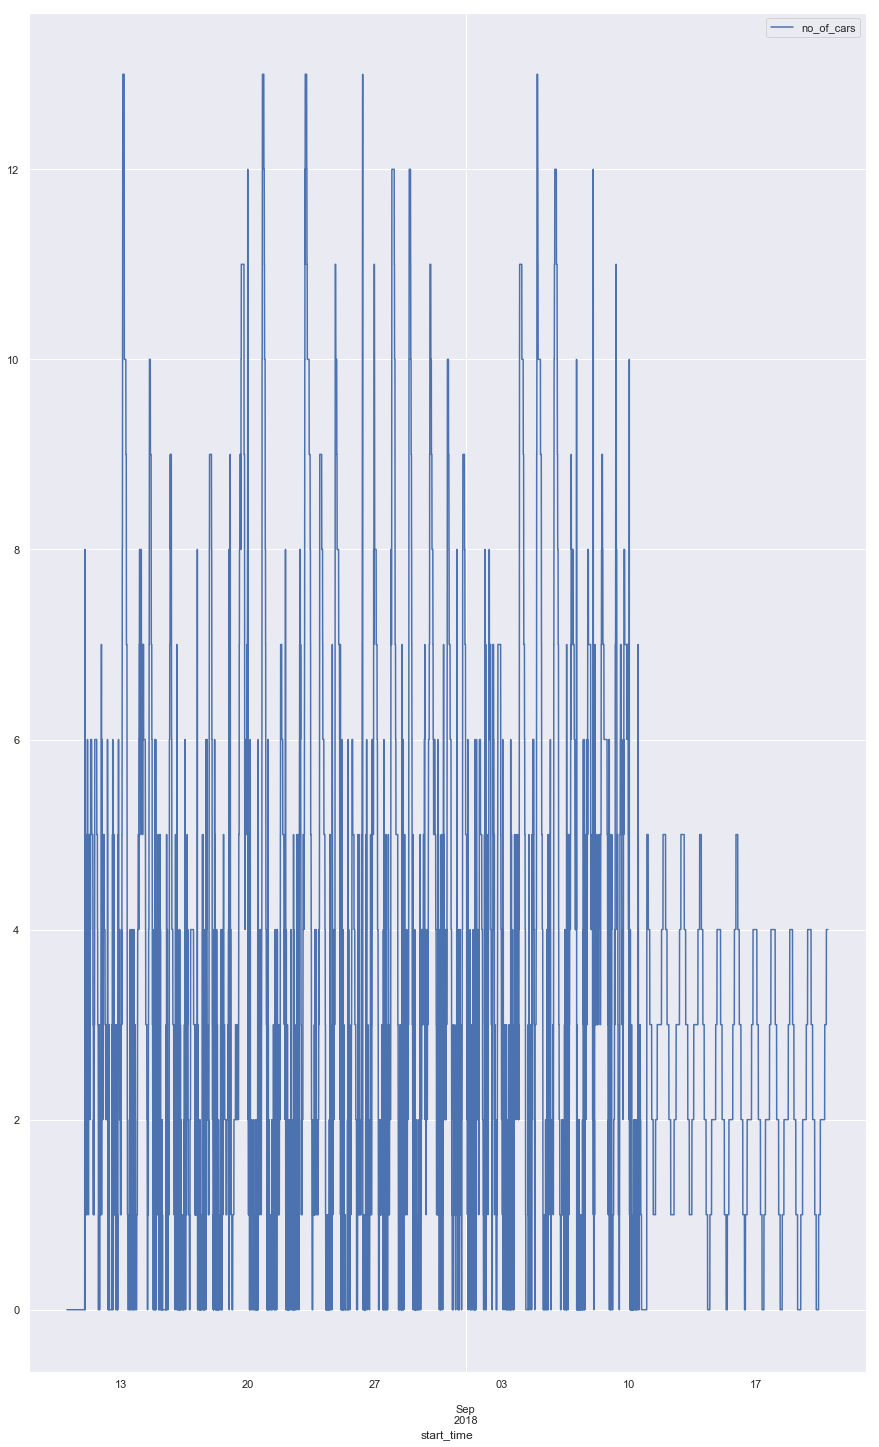

In [675]:
df_tst_5min_sept[['start_time','no_of_cars']].set_index('start_time').plot()

In [676]:
df_tst_5min = df_5min.loc[(df_5min['sensor_id']=='SENSITY-kc-14')  &
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  >= '2018-09-21') &
                          (df_5min.start_time.dt.date.astype(str) 
                                                                  <= '2019-03-04')
                      ][['start_time','no_of_cars']]

In [677]:
df_tst_5min.head()

start_time  no_of_cars
98801 2018-09-21 00:00:00           3
98811 2018-09-21 00:05:00           4
98821 2018-09-21 00:10:00           4
98832 2018-09-21 00:15:00           4
98842 2018-09-21 00:20:00           4

In [678]:
df_tst_5min.tail()

start_time  no_of_cars
585727 2019-03-04 17:10:00           1
585737 2019-03-04 17:15:00           1
585747 2019-03-04 17:20:00           1
585756 2019-03-04 17:25:00           1
585765 2019-03-04 17:30:00           1

In [684]:
temp_data=[]
time = dt.datetime(2018, 9, 20, 0, 0, 0)
print('starting',time)
for x in np.arange(0,165,1):
#     print(time+ pd.to_timedelta(x,unit='d'))
    time=time+ pd.DateOffset(1)
#     print(time)
    for y in np.arange(0,1440, 5):
#         print(time+ pd.to_timedelta(y, unit='m'))
        val=time+ pd.to_timedelta(y, unit='m')
        print(val)
        temp_data.append(val)

starting 2018-09-20 00:00:00
2018-09-21 00:00:00
2018-09-21 00:05:00
2018-09-21 00:10:00
2018-09-21 00:15:00
2018-09-21 00:20:00
2018-09-21 00:25:00
2018-09-21 00:30:00
2018-09-21 00:35:00
2018-09-21 00:40:00
2018-09-21 00:45:00
2018-09-21 00:50:00
2018-09-21 00:55:00
2018-09-21 01:00:00
2018-09-21 01:05:00
2018-09-21 01:10:00
2018-09-21 01:15:00
2018-09-21 01:20:00
2018-09-21 01:25:00
2018-09-21 01:30:00
2018-09-21 01:35:00
2018-09-21 01:40:00
2018-09-21 01:45:00
2018-09-21 01:50:00
2018-09-21 01:55:00
2018-09-21 02:00:00
2018-09-21 02:05:00
2018-09-21 02:10:00
2018-09-21 02:15:00
2018-09-21 02:20:00
2018-09-21 02:25:00
2018-09-21 02:30:00
2018-09-21 02:35:00
2018-09-21 02:40:00
2018-09-21 02:45:00
2018-09-21 02:50:00
2018-09-21 02:55:00
2018-09-21 03:00:00
2018-09-21 03:05:00
2018-09-21 03:10:00
2018-09-21 03:15:00
2018-09-21 03:20:00
2018-09-21 03:25:00
2018-09-21 03:30:00
2018-09-21 03:35:00
2018-09-21 03:40:00
2018-09-21 03:45:00
2018-09-21 03:50:00
2018-09-21 03:55:00
2018-09-21 

2018-09-26 02:45:00
2018-09-26 02:50:00
2018-09-26 02:55:00
2018-09-26 03:00:00
2018-09-26 03:05:00
2018-09-26 03:10:00
2018-09-26 03:15:00
2018-09-26 03:20:00
2018-09-26 03:25:00
2018-09-26 03:30:00
2018-09-26 03:35:00
2018-09-26 03:40:00
2018-09-26 03:45:00
2018-09-26 03:50:00
2018-09-26 03:55:00
2018-09-26 04:00:00
2018-09-26 04:05:00
2018-09-26 04:10:00
2018-09-26 04:15:00
2018-09-26 04:20:00
2018-09-26 04:25:00
2018-09-26 04:30:00
2018-09-26 04:35:00
2018-09-26 04:40:00
2018-09-26 04:45:00
2018-09-26 04:50:00
2018-09-26 04:55:00
2018-09-26 05:00:00
2018-09-26 05:05:00
2018-09-26 05:10:00
2018-09-26 05:15:00
2018-09-26 05:20:00
2018-09-26 05:25:00
2018-09-26 05:30:00
2018-09-26 05:35:00
2018-09-26 05:40:00
2018-09-26 05:45:00
2018-09-26 05:50:00
2018-09-26 05:55:00
2018-09-26 06:00:00
2018-09-26 06:05:00
2018-09-26 06:10:00
2018-09-26 06:15:00
2018-09-26 06:20:00
2018-09-26 06:25:00
2018-09-26 06:30:00
2018-09-26 06:35:00
2018-09-26 06:40:00
2018-09-26 06:45:00
2018-09-26 06:50:00


2018-09-30 15:30:00
2018-09-30 15:35:00
2018-09-30 15:40:00
2018-09-30 15:45:00
2018-09-30 15:50:00
2018-09-30 15:55:00
2018-09-30 16:00:00
2018-09-30 16:05:00
2018-09-30 16:10:00
2018-09-30 16:15:00
2018-09-30 16:20:00
2018-09-30 16:25:00
2018-09-30 16:30:00
2018-09-30 16:35:00
2018-09-30 16:40:00
2018-09-30 16:45:00
2018-09-30 16:50:00
2018-09-30 16:55:00
2018-09-30 17:00:00
2018-09-30 17:05:00
2018-09-30 17:10:00
2018-09-30 17:15:00
2018-09-30 17:20:00
2018-09-30 17:25:00
2018-09-30 17:30:00
2018-09-30 17:35:00
2018-09-30 17:40:00
2018-09-30 17:45:00
2018-09-30 17:50:00
2018-09-30 17:55:00
2018-09-30 18:00:00
2018-09-30 18:05:00
2018-09-30 18:10:00
2018-09-30 18:15:00
2018-09-30 18:20:00
2018-09-30 18:25:00
2018-09-30 18:30:00
2018-09-30 18:35:00
2018-09-30 18:40:00
2018-09-30 18:45:00
2018-09-30 18:50:00
2018-09-30 18:55:00
2018-09-30 19:00:00
2018-09-30 19:05:00
2018-09-30 19:10:00
2018-09-30 19:15:00
2018-09-30 19:20:00
2018-09-30 19:25:00
2018-09-30 19:30:00
2018-09-30 19:35:00


2018-10-04 11:40:00
2018-10-04 11:45:00
2018-10-04 11:50:00
2018-10-04 11:55:00
2018-10-04 12:00:00
2018-10-04 12:05:00
2018-10-04 12:10:00
2018-10-04 12:15:00
2018-10-04 12:20:00
2018-10-04 12:25:00
2018-10-04 12:30:00
2018-10-04 12:35:00
2018-10-04 12:40:00
2018-10-04 12:45:00
2018-10-04 12:50:00
2018-10-04 12:55:00
2018-10-04 13:00:00
2018-10-04 13:05:00
2018-10-04 13:10:00
2018-10-04 13:15:00
2018-10-04 13:20:00
2018-10-04 13:25:00
2018-10-04 13:30:00
2018-10-04 13:35:00
2018-10-04 13:40:00
2018-10-04 13:45:00
2018-10-04 13:50:00
2018-10-04 13:55:00
2018-10-04 14:00:00
2018-10-04 14:05:00
2018-10-04 14:10:00
2018-10-04 14:15:00
2018-10-04 14:20:00
2018-10-04 14:25:00
2018-10-04 14:30:00
2018-10-04 14:35:00
2018-10-04 14:40:00
2018-10-04 14:45:00
2018-10-04 14:50:00
2018-10-04 14:55:00
2018-10-04 15:00:00
2018-10-04 15:05:00
2018-10-04 15:10:00
2018-10-04 15:15:00
2018-10-04 15:20:00
2018-10-04 15:25:00
2018-10-04 15:30:00
2018-10-04 15:35:00
2018-10-04 15:40:00
2018-10-04 15:45:00


2018-10-09 16:35:00
2018-10-09 16:40:00
2018-10-09 16:45:00
2018-10-09 16:50:00
2018-10-09 16:55:00
2018-10-09 17:00:00
2018-10-09 17:05:00
2018-10-09 17:10:00
2018-10-09 17:15:00
2018-10-09 17:20:00
2018-10-09 17:25:00
2018-10-09 17:30:00
2018-10-09 17:35:00
2018-10-09 17:40:00
2018-10-09 17:45:00
2018-10-09 17:50:00
2018-10-09 17:55:00
2018-10-09 18:00:00
2018-10-09 18:05:00
2018-10-09 18:10:00
2018-10-09 18:15:00
2018-10-09 18:20:00
2018-10-09 18:25:00
2018-10-09 18:30:00
2018-10-09 18:35:00
2018-10-09 18:40:00
2018-10-09 18:45:00
2018-10-09 18:50:00
2018-10-09 18:55:00
2018-10-09 19:00:00
2018-10-09 19:05:00
2018-10-09 19:10:00
2018-10-09 19:15:00
2018-10-09 19:20:00
2018-10-09 19:25:00
2018-10-09 19:30:00
2018-10-09 19:35:00
2018-10-09 19:40:00
2018-10-09 19:45:00
2018-10-09 19:50:00
2018-10-09 19:55:00
2018-10-09 20:00:00
2018-10-09 20:05:00
2018-10-09 20:10:00
2018-10-09 20:15:00
2018-10-09 20:20:00
2018-10-09 20:25:00
2018-10-09 20:30:00
2018-10-09 20:35:00
2018-10-09 20:40:00


2018-10-14 06:50:00
2018-10-14 06:55:00
2018-10-14 07:00:00
2018-10-14 07:05:00
2018-10-14 07:10:00
2018-10-14 07:15:00
2018-10-14 07:20:00
2018-10-14 07:25:00
2018-10-14 07:30:00
2018-10-14 07:35:00
2018-10-14 07:40:00
2018-10-14 07:45:00
2018-10-14 07:50:00
2018-10-14 07:55:00
2018-10-14 08:00:00
2018-10-14 08:05:00
2018-10-14 08:10:00
2018-10-14 08:15:00
2018-10-14 08:20:00
2018-10-14 08:25:00
2018-10-14 08:30:00
2018-10-14 08:35:00
2018-10-14 08:40:00
2018-10-14 08:45:00
2018-10-14 08:50:00
2018-10-14 08:55:00
2018-10-14 09:00:00
2018-10-14 09:05:00
2018-10-14 09:10:00
2018-10-14 09:15:00
2018-10-14 09:20:00
2018-10-14 09:25:00
2018-10-14 09:30:00
2018-10-14 09:35:00
2018-10-14 09:40:00
2018-10-14 09:45:00
2018-10-14 09:50:00
2018-10-14 09:55:00
2018-10-14 10:00:00
2018-10-14 10:05:00
2018-10-14 10:10:00
2018-10-14 10:15:00
2018-10-14 10:20:00
2018-10-14 10:25:00
2018-10-14 10:30:00
2018-10-14 10:35:00
2018-10-14 10:40:00
2018-10-14 10:45:00
2018-10-14 10:50:00
2018-10-14 10:55:00


2018-10-18 08:50:00
2018-10-18 08:55:00
2018-10-18 09:00:00
2018-10-18 09:05:00
2018-10-18 09:10:00
2018-10-18 09:15:00
2018-10-18 09:20:00
2018-10-18 09:25:00
2018-10-18 09:30:00
2018-10-18 09:35:00
2018-10-18 09:40:00
2018-10-18 09:45:00
2018-10-18 09:50:00
2018-10-18 09:55:00
2018-10-18 10:00:00
2018-10-18 10:05:00
2018-10-18 10:10:00
2018-10-18 10:15:00
2018-10-18 10:20:00
2018-10-18 10:25:00
2018-10-18 10:30:00
2018-10-18 10:35:00
2018-10-18 10:40:00
2018-10-18 10:45:00
2018-10-18 10:50:00
2018-10-18 10:55:00
2018-10-18 11:00:00
2018-10-18 11:05:00
2018-10-18 11:10:00
2018-10-18 11:15:00
2018-10-18 11:20:00
2018-10-18 11:25:00
2018-10-18 11:30:00
2018-10-18 11:35:00
2018-10-18 11:40:00
2018-10-18 11:45:00
2018-10-18 11:50:00
2018-10-18 11:55:00
2018-10-18 12:00:00
2018-10-18 12:05:00
2018-10-18 12:10:00
2018-10-18 12:15:00
2018-10-18 12:20:00
2018-10-18 12:25:00
2018-10-18 12:30:00
2018-10-18 12:35:00
2018-10-18 12:40:00
2018-10-18 12:45:00
2018-10-18 12:50:00
2018-10-18 12:55:00


2018-10-23 13:50:00
2018-10-23 13:55:00
2018-10-23 14:00:00
2018-10-23 14:05:00
2018-10-23 14:10:00
2018-10-23 14:15:00
2018-10-23 14:20:00
2018-10-23 14:25:00
2018-10-23 14:30:00
2018-10-23 14:35:00
2018-10-23 14:40:00
2018-10-23 14:45:00
2018-10-23 14:50:00
2018-10-23 14:55:00
2018-10-23 15:00:00
2018-10-23 15:05:00
2018-10-23 15:10:00
2018-10-23 15:15:00
2018-10-23 15:20:00
2018-10-23 15:25:00
2018-10-23 15:30:00
2018-10-23 15:35:00
2018-10-23 15:40:00
2018-10-23 15:45:00
2018-10-23 15:50:00
2018-10-23 15:55:00
2018-10-23 16:00:00
2018-10-23 16:05:00
2018-10-23 16:10:00
2018-10-23 16:15:00
2018-10-23 16:20:00
2018-10-23 16:25:00
2018-10-23 16:30:00
2018-10-23 16:35:00
2018-10-23 16:40:00
2018-10-23 16:45:00
2018-10-23 16:50:00
2018-10-23 16:55:00
2018-10-23 17:00:00
2018-10-23 17:05:00
2018-10-23 17:10:00
2018-10-23 17:15:00
2018-10-23 17:20:00
2018-10-23 17:25:00
2018-10-23 17:30:00
2018-10-23 17:35:00
2018-10-23 17:40:00
2018-10-23 17:45:00
2018-10-23 17:50:00
2018-10-23 17:55:00


2018-10-28 18:45:00
2018-10-28 18:50:00
2018-10-28 18:55:00
2018-10-28 19:00:00
2018-10-28 19:05:00
2018-10-28 19:10:00
2018-10-28 19:15:00
2018-10-28 19:20:00
2018-10-28 19:25:00
2018-10-28 19:30:00
2018-10-28 19:35:00
2018-10-28 19:40:00
2018-10-28 19:45:00
2018-10-28 19:50:00
2018-10-28 19:55:00
2018-10-28 20:00:00
2018-10-28 20:05:00
2018-10-28 20:10:00
2018-10-28 20:15:00
2018-10-28 20:20:00
2018-10-28 20:25:00
2018-10-28 20:30:00
2018-10-28 20:35:00
2018-10-28 20:40:00
2018-10-28 20:45:00
2018-10-28 20:50:00
2018-10-28 20:55:00
2018-10-28 21:00:00
2018-10-28 21:05:00
2018-10-28 21:10:00
2018-10-28 21:15:00
2018-10-28 21:20:00
2018-10-28 21:25:00
2018-10-28 21:30:00
2018-10-28 21:35:00
2018-10-28 21:40:00
2018-10-28 21:45:00
2018-10-28 21:50:00
2018-10-28 21:55:00
2018-10-28 22:00:00
2018-10-28 22:05:00
2018-10-28 22:10:00
2018-10-28 22:15:00
2018-10-28 22:20:00
2018-10-28 22:25:00
2018-10-28 22:30:00
2018-10-28 22:35:00
2018-10-28 22:40:00
2018-10-28 22:45:00
2018-10-28 22:50:00


2018-11-02 22:20:00
2018-11-02 22:25:00
2018-11-02 22:30:00
2018-11-02 22:35:00
2018-11-02 22:40:00
2018-11-02 22:45:00
2018-11-02 22:50:00
2018-11-02 22:55:00
2018-11-02 23:00:00
2018-11-02 23:05:00
2018-11-02 23:10:00
2018-11-02 23:15:00
2018-11-02 23:20:00
2018-11-02 23:25:00
2018-11-02 23:30:00
2018-11-02 23:35:00
2018-11-02 23:40:00
2018-11-02 23:45:00
2018-11-02 23:50:00
2018-11-02 23:55:00
2018-11-03 00:00:00
2018-11-03 00:05:00
2018-11-03 00:10:00
2018-11-03 00:15:00
2018-11-03 00:20:00
2018-11-03 00:25:00
2018-11-03 00:30:00
2018-11-03 00:35:00
2018-11-03 00:40:00
2018-11-03 00:45:00
2018-11-03 00:50:00
2018-11-03 00:55:00
2018-11-03 01:00:00
2018-11-03 01:05:00
2018-11-03 01:10:00
2018-11-03 01:15:00
2018-11-03 01:20:00
2018-11-03 01:25:00
2018-11-03 01:30:00
2018-11-03 01:35:00
2018-11-03 01:40:00
2018-11-03 01:45:00
2018-11-03 01:50:00
2018-11-03 01:55:00
2018-11-03 02:00:00
2018-11-03 02:05:00
2018-11-03 02:10:00
2018-11-03 02:15:00
2018-11-03 02:20:00
2018-11-03 02:25:00


2018-11-08 04:40:00
2018-11-08 04:45:00
2018-11-08 04:50:00
2018-11-08 04:55:00
2018-11-08 05:00:00
2018-11-08 05:05:00
2018-11-08 05:10:00
2018-11-08 05:15:00
2018-11-08 05:20:00
2018-11-08 05:25:00
2018-11-08 05:30:00
2018-11-08 05:35:00
2018-11-08 05:40:00
2018-11-08 05:45:00
2018-11-08 05:50:00
2018-11-08 05:55:00
2018-11-08 06:00:00
2018-11-08 06:05:00
2018-11-08 06:10:00
2018-11-08 06:15:00
2018-11-08 06:20:00
2018-11-08 06:25:00
2018-11-08 06:30:00
2018-11-08 06:35:00
2018-11-08 06:40:00
2018-11-08 06:45:00
2018-11-08 06:50:00
2018-11-08 06:55:00
2018-11-08 07:00:00
2018-11-08 07:05:00
2018-11-08 07:10:00
2018-11-08 07:15:00
2018-11-08 07:20:00
2018-11-08 07:25:00
2018-11-08 07:30:00
2018-11-08 07:35:00
2018-11-08 07:40:00
2018-11-08 07:45:00
2018-11-08 07:50:00
2018-11-08 07:55:00
2018-11-08 08:00:00
2018-11-08 08:05:00
2018-11-08 08:10:00
2018-11-08 08:15:00
2018-11-08 08:20:00
2018-11-08 08:25:00
2018-11-08 08:30:00
2018-11-08 08:35:00
2018-11-08 08:40:00
2018-11-08 08:45:00


2018-11-13 09:40:00
2018-11-13 09:45:00
2018-11-13 09:50:00
2018-11-13 09:55:00
2018-11-13 10:00:00
2018-11-13 10:05:00
2018-11-13 10:10:00
2018-11-13 10:15:00
2018-11-13 10:20:00
2018-11-13 10:25:00
2018-11-13 10:30:00
2018-11-13 10:35:00
2018-11-13 10:40:00
2018-11-13 10:45:00
2018-11-13 10:50:00
2018-11-13 10:55:00
2018-11-13 11:00:00
2018-11-13 11:05:00
2018-11-13 11:10:00
2018-11-13 11:15:00
2018-11-13 11:20:00
2018-11-13 11:25:00
2018-11-13 11:30:00
2018-11-13 11:35:00
2018-11-13 11:40:00
2018-11-13 11:45:00
2018-11-13 11:50:00
2018-11-13 11:55:00
2018-11-13 12:00:00
2018-11-13 12:05:00
2018-11-13 12:10:00
2018-11-13 12:15:00
2018-11-13 12:20:00
2018-11-13 12:25:00
2018-11-13 12:30:00
2018-11-13 12:35:00
2018-11-13 12:40:00
2018-11-13 12:45:00
2018-11-13 12:50:00
2018-11-13 12:55:00
2018-11-13 13:00:00
2018-11-13 13:05:00
2018-11-13 13:10:00
2018-11-13 13:15:00
2018-11-13 13:20:00
2018-11-13 13:25:00
2018-11-13 13:30:00
2018-11-13 13:35:00
2018-11-13 13:40:00
2018-11-13 13:45:00


2018-11-18 14:35:00
2018-11-18 14:40:00
2018-11-18 14:45:00
2018-11-18 14:50:00
2018-11-18 14:55:00
2018-11-18 15:00:00
2018-11-18 15:05:00
2018-11-18 15:10:00
2018-11-18 15:15:00
2018-11-18 15:20:00
2018-11-18 15:25:00
2018-11-18 15:30:00
2018-11-18 15:35:00
2018-11-18 15:40:00
2018-11-18 15:45:00
2018-11-18 15:50:00
2018-11-18 15:55:00
2018-11-18 16:00:00
2018-11-18 16:05:00
2018-11-18 16:10:00
2018-11-18 16:15:00
2018-11-18 16:20:00
2018-11-18 16:25:00
2018-11-18 16:30:00
2018-11-18 16:35:00
2018-11-18 16:40:00
2018-11-18 16:45:00
2018-11-18 16:50:00
2018-11-18 16:55:00
2018-11-18 17:00:00
2018-11-18 17:05:00
2018-11-18 17:10:00
2018-11-18 17:15:00
2018-11-18 17:20:00
2018-11-18 17:25:00
2018-11-18 17:30:00
2018-11-18 17:35:00
2018-11-18 17:40:00
2018-11-18 17:45:00
2018-11-18 17:50:00
2018-11-18 17:55:00
2018-11-18 18:00:00
2018-11-18 18:05:00
2018-11-18 18:10:00
2018-11-18 18:15:00
2018-11-18 18:20:00
2018-11-18 18:25:00
2018-11-18 18:30:00
2018-11-18 18:35:00
2018-11-18 18:40:00


2018-11-23 19:35:00
2018-11-23 19:40:00
2018-11-23 19:45:00
2018-11-23 19:50:00
2018-11-23 19:55:00
2018-11-23 20:00:00
2018-11-23 20:05:00
2018-11-23 20:10:00
2018-11-23 20:15:00
2018-11-23 20:20:00
2018-11-23 20:25:00
2018-11-23 20:30:00
2018-11-23 20:35:00
2018-11-23 20:40:00
2018-11-23 20:45:00
2018-11-23 20:50:00
2018-11-23 20:55:00
2018-11-23 21:00:00
2018-11-23 21:05:00
2018-11-23 21:10:00
2018-11-23 21:15:00
2018-11-23 21:20:00
2018-11-23 21:25:00
2018-11-23 21:30:00
2018-11-23 21:35:00
2018-11-23 21:40:00
2018-11-23 21:45:00
2018-11-23 21:50:00
2018-11-23 21:55:00
2018-11-23 22:00:00
2018-11-23 22:05:00
2018-11-23 22:10:00
2018-11-23 22:15:00
2018-11-23 22:20:00
2018-11-23 22:25:00
2018-11-23 22:30:00
2018-11-23 22:35:00
2018-11-23 22:40:00
2018-11-23 22:45:00
2018-11-23 22:50:00
2018-11-23 22:55:00
2018-11-23 23:00:00
2018-11-23 23:05:00
2018-11-23 23:10:00
2018-11-23 23:15:00
2018-11-23 23:20:00
2018-11-23 23:25:00
2018-11-23 23:30:00
2018-11-23 23:35:00
2018-11-23 23:40:00


2018-11-29 00:30:00
2018-11-29 00:35:00
2018-11-29 00:40:00
2018-11-29 00:45:00
2018-11-29 00:50:00
2018-11-29 00:55:00
2018-11-29 01:00:00
2018-11-29 01:05:00
2018-11-29 01:10:00
2018-11-29 01:15:00
2018-11-29 01:20:00
2018-11-29 01:25:00
2018-11-29 01:30:00
2018-11-29 01:35:00
2018-11-29 01:40:00
2018-11-29 01:45:00
2018-11-29 01:50:00
2018-11-29 01:55:00
2018-11-29 02:00:00
2018-11-29 02:05:00
2018-11-29 02:10:00
2018-11-29 02:15:00
2018-11-29 02:20:00
2018-11-29 02:25:00
2018-11-29 02:30:00
2018-11-29 02:35:00
2018-11-29 02:40:00
2018-11-29 02:45:00
2018-11-29 02:50:00
2018-11-29 02:55:00
2018-11-29 03:00:00
2018-11-29 03:05:00
2018-11-29 03:10:00
2018-11-29 03:15:00
2018-11-29 03:20:00
2018-11-29 03:25:00
2018-11-29 03:30:00
2018-11-29 03:35:00
2018-11-29 03:40:00
2018-11-29 03:45:00
2018-11-29 03:50:00
2018-11-29 03:55:00
2018-11-29 04:00:00
2018-11-29 04:05:00
2018-11-29 04:10:00
2018-11-29 04:15:00
2018-11-29 04:20:00
2018-11-29 04:25:00
2018-11-29 04:30:00
2018-11-29 04:35:00


2018-12-04 05:30:00
2018-12-04 05:35:00
2018-12-04 05:40:00
2018-12-04 05:45:00
2018-12-04 05:50:00
2018-12-04 05:55:00
2018-12-04 06:00:00
2018-12-04 06:05:00
2018-12-04 06:10:00
2018-12-04 06:15:00
2018-12-04 06:20:00
2018-12-04 06:25:00
2018-12-04 06:30:00
2018-12-04 06:35:00
2018-12-04 06:40:00
2018-12-04 06:45:00
2018-12-04 06:50:00
2018-12-04 06:55:00
2018-12-04 07:00:00
2018-12-04 07:05:00
2018-12-04 07:10:00
2018-12-04 07:15:00
2018-12-04 07:20:00
2018-12-04 07:25:00
2018-12-04 07:30:00
2018-12-04 07:35:00
2018-12-04 07:40:00
2018-12-04 07:45:00
2018-12-04 07:50:00
2018-12-04 07:55:00
2018-12-04 08:00:00
2018-12-04 08:05:00
2018-12-04 08:10:00
2018-12-04 08:15:00
2018-12-04 08:20:00
2018-12-04 08:25:00
2018-12-04 08:30:00
2018-12-04 08:35:00
2018-12-04 08:40:00
2018-12-04 08:45:00
2018-12-04 08:50:00
2018-12-04 08:55:00
2018-12-04 09:00:00
2018-12-04 09:05:00
2018-12-04 09:10:00
2018-12-04 09:15:00
2018-12-04 09:20:00
2018-12-04 09:25:00
2018-12-04 09:30:00
2018-12-04 09:35:00


2018-12-09 10:25:00
2018-12-09 10:30:00
2018-12-09 10:35:00
2018-12-09 10:40:00
2018-12-09 10:45:00
2018-12-09 10:50:00
2018-12-09 10:55:00
2018-12-09 11:00:00
2018-12-09 11:05:00
2018-12-09 11:10:00
2018-12-09 11:15:00
2018-12-09 11:20:00
2018-12-09 11:25:00
2018-12-09 11:30:00
2018-12-09 11:35:00
2018-12-09 11:40:00
2018-12-09 11:45:00
2018-12-09 11:50:00
2018-12-09 11:55:00
2018-12-09 12:00:00
2018-12-09 12:05:00
2018-12-09 12:10:00
2018-12-09 12:15:00
2018-12-09 12:20:00
2018-12-09 12:25:00
2018-12-09 12:30:00
2018-12-09 12:35:00
2018-12-09 12:40:00
2018-12-09 12:45:00
2018-12-09 12:50:00
2018-12-09 12:55:00
2018-12-09 13:00:00
2018-12-09 13:05:00
2018-12-09 13:10:00
2018-12-09 13:15:00
2018-12-09 13:20:00
2018-12-09 13:25:00
2018-12-09 13:30:00
2018-12-09 13:35:00
2018-12-09 13:40:00
2018-12-09 13:45:00
2018-12-09 13:50:00
2018-12-09 13:55:00
2018-12-09 14:00:00
2018-12-09 14:05:00
2018-12-09 14:10:00
2018-12-09 14:15:00
2018-12-09 14:20:00
2018-12-09 14:25:00
2018-12-09 14:30:00


2018-12-14 15:25:00
2018-12-14 15:30:00
2018-12-14 15:35:00
2018-12-14 15:40:00
2018-12-14 15:45:00
2018-12-14 15:50:00
2018-12-14 15:55:00
2018-12-14 16:00:00
2018-12-14 16:05:00
2018-12-14 16:10:00
2018-12-14 16:15:00
2018-12-14 16:20:00
2018-12-14 16:25:00
2018-12-14 16:30:00
2018-12-14 16:35:00
2018-12-14 16:40:00
2018-12-14 16:45:00
2018-12-14 16:50:00
2018-12-14 16:55:00
2018-12-14 17:00:00
2018-12-14 17:05:00
2018-12-14 17:10:00
2018-12-14 17:15:00
2018-12-14 17:20:00
2018-12-14 17:25:00
2018-12-14 17:30:00
2018-12-14 17:35:00
2018-12-14 17:40:00
2018-12-14 17:45:00
2018-12-14 17:50:00
2018-12-14 17:55:00
2018-12-14 18:00:00
2018-12-14 18:05:00
2018-12-14 18:10:00
2018-12-14 18:15:00
2018-12-14 18:20:00
2018-12-14 18:25:00
2018-12-14 18:30:00
2018-12-14 18:35:00
2018-12-14 18:40:00
2018-12-14 18:45:00
2018-12-14 18:50:00
2018-12-14 18:55:00
2018-12-14 19:00:00
2018-12-14 19:05:00
2018-12-14 19:10:00
2018-12-14 19:15:00
2018-12-14 19:20:00
2018-12-14 19:25:00
2018-12-14 19:30:00


2018-12-19 20:20:00
2018-12-19 20:25:00
2018-12-19 20:30:00
2018-12-19 20:35:00
2018-12-19 20:40:00
2018-12-19 20:45:00
2018-12-19 20:50:00
2018-12-19 20:55:00
2018-12-19 21:00:00
2018-12-19 21:05:00
2018-12-19 21:10:00
2018-12-19 21:15:00
2018-12-19 21:20:00
2018-12-19 21:25:00
2018-12-19 21:30:00
2018-12-19 21:35:00
2018-12-19 21:40:00
2018-12-19 21:45:00
2018-12-19 21:50:00
2018-12-19 21:55:00
2018-12-19 22:00:00
2018-12-19 22:05:00
2018-12-19 22:10:00
2018-12-19 22:15:00
2018-12-19 22:20:00
2018-12-19 22:25:00
2018-12-19 22:30:00
2018-12-19 22:35:00
2018-12-19 22:40:00
2018-12-19 22:45:00
2018-12-19 22:50:00
2018-12-19 22:55:00
2018-12-19 23:00:00
2018-12-19 23:05:00
2018-12-19 23:10:00
2018-12-19 23:15:00
2018-12-19 23:20:00
2018-12-19 23:25:00
2018-12-19 23:30:00
2018-12-19 23:35:00
2018-12-19 23:40:00
2018-12-19 23:45:00
2018-12-19 23:50:00
2018-12-19 23:55:00
2018-12-20 00:00:00
2018-12-20 00:05:00
2018-12-20 00:10:00
2018-12-20 00:15:00
2018-12-20 00:20:00
2018-12-20 00:25:00


2018-12-25 01:20:00
2018-12-25 01:25:00
2018-12-25 01:30:00
2018-12-25 01:35:00
2018-12-25 01:40:00
2018-12-25 01:45:00
2018-12-25 01:50:00
2018-12-25 01:55:00
2018-12-25 02:00:00
2018-12-25 02:05:00
2018-12-25 02:10:00
2018-12-25 02:15:00
2018-12-25 02:20:00
2018-12-25 02:25:00
2018-12-25 02:30:00
2018-12-25 02:35:00
2018-12-25 02:40:00
2018-12-25 02:45:00
2018-12-25 02:50:00
2018-12-25 02:55:00
2018-12-25 03:00:00
2018-12-25 03:05:00
2018-12-25 03:10:00
2018-12-25 03:15:00
2018-12-25 03:20:00
2018-12-25 03:25:00
2018-12-25 03:30:00
2018-12-25 03:35:00
2018-12-25 03:40:00
2018-12-25 03:45:00
2018-12-25 03:50:00
2018-12-25 03:55:00
2018-12-25 04:00:00
2018-12-25 04:05:00
2018-12-25 04:10:00
2018-12-25 04:15:00
2018-12-25 04:20:00
2018-12-25 04:25:00
2018-12-25 04:30:00
2018-12-25 04:35:00
2018-12-25 04:40:00
2018-12-25 04:45:00
2018-12-25 04:50:00
2018-12-25 04:55:00
2018-12-25 05:00:00
2018-12-25 05:05:00
2018-12-25 05:10:00
2018-12-25 05:15:00
2018-12-25 05:20:00
2018-12-25 05:25:00


2018-12-30 06:15:00
2018-12-30 06:20:00
2018-12-30 06:25:00
2018-12-30 06:30:00
2018-12-30 06:35:00
2018-12-30 06:40:00
2018-12-30 06:45:00
2018-12-30 06:50:00
2018-12-30 06:55:00
2018-12-30 07:00:00
2018-12-30 07:05:00
2018-12-30 07:10:00
2018-12-30 07:15:00
2018-12-30 07:20:00
2018-12-30 07:25:00
2018-12-30 07:30:00
2018-12-30 07:35:00
2018-12-30 07:40:00
2018-12-30 07:45:00
2018-12-30 07:50:00
2018-12-30 07:55:00
2018-12-30 08:00:00
2018-12-30 08:05:00
2018-12-30 08:10:00
2018-12-30 08:15:00
2018-12-30 08:20:00
2018-12-30 08:25:00
2018-12-30 08:30:00
2018-12-30 08:35:00
2018-12-30 08:40:00
2018-12-30 08:45:00
2018-12-30 08:50:00
2018-12-30 08:55:00
2018-12-30 09:00:00
2018-12-30 09:05:00
2018-12-30 09:10:00
2018-12-30 09:15:00
2018-12-30 09:20:00
2018-12-30 09:25:00
2018-12-30 09:30:00
2018-12-30 09:35:00
2018-12-30 09:40:00
2018-12-30 09:45:00
2018-12-30 09:50:00
2018-12-30 09:55:00
2018-12-30 10:00:00
2018-12-30 10:05:00
2018-12-30 10:10:00
2018-12-30 10:15:00
2018-12-30 10:20:00


2019-01-04 11:15:00
2019-01-04 11:20:00
2019-01-04 11:25:00
2019-01-04 11:30:00
2019-01-04 11:35:00
2019-01-04 11:40:00
2019-01-04 11:45:00
2019-01-04 11:50:00
2019-01-04 11:55:00
2019-01-04 12:00:00
2019-01-04 12:05:00
2019-01-04 12:10:00
2019-01-04 12:15:00
2019-01-04 12:20:00
2019-01-04 12:25:00
2019-01-04 12:30:00
2019-01-04 12:35:00
2019-01-04 12:40:00
2019-01-04 12:45:00
2019-01-04 12:50:00
2019-01-04 12:55:00
2019-01-04 13:00:00
2019-01-04 13:05:00
2019-01-04 13:10:00
2019-01-04 13:15:00
2019-01-04 13:20:00
2019-01-04 13:25:00
2019-01-04 13:30:00
2019-01-04 13:35:00
2019-01-04 13:40:00
2019-01-04 13:45:00
2019-01-04 13:50:00
2019-01-04 13:55:00
2019-01-04 14:00:00
2019-01-04 14:05:00
2019-01-04 14:10:00
2019-01-04 14:15:00
2019-01-04 14:20:00
2019-01-04 14:25:00
2019-01-04 14:30:00
2019-01-04 14:35:00
2019-01-04 14:40:00
2019-01-04 14:45:00
2019-01-04 14:50:00
2019-01-04 14:55:00
2019-01-04 15:00:00
2019-01-04 15:05:00
2019-01-04 15:10:00
2019-01-04 15:15:00
2019-01-04 15:20:00


2019-01-09 16:10:00
2019-01-09 16:15:00
2019-01-09 16:20:00
2019-01-09 16:25:00
2019-01-09 16:30:00
2019-01-09 16:35:00
2019-01-09 16:40:00
2019-01-09 16:45:00
2019-01-09 16:50:00
2019-01-09 16:55:00
2019-01-09 17:00:00
2019-01-09 17:05:00
2019-01-09 17:10:00
2019-01-09 17:15:00
2019-01-09 17:20:00
2019-01-09 17:25:00
2019-01-09 17:30:00
2019-01-09 17:35:00
2019-01-09 17:40:00
2019-01-09 17:45:00
2019-01-09 17:50:00
2019-01-09 17:55:00
2019-01-09 18:00:00
2019-01-09 18:05:00
2019-01-09 18:10:00
2019-01-09 18:15:00
2019-01-09 18:20:00
2019-01-09 18:25:00
2019-01-09 18:30:00
2019-01-09 18:35:00
2019-01-09 18:40:00
2019-01-09 18:45:00
2019-01-09 18:50:00
2019-01-09 18:55:00
2019-01-09 19:00:00
2019-01-09 19:05:00
2019-01-09 19:10:00
2019-01-09 19:15:00
2019-01-09 19:20:00
2019-01-09 19:25:00
2019-01-09 19:30:00
2019-01-09 19:35:00
2019-01-09 19:40:00
2019-01-09 19:45:00
2019-01-09 19:50:00
2019-01-09 19:55:00
2019-01-09 20:00:00
2019-01-09 20:05:00
2019-01-09 20:10:00
2019-01-09 20:15:00


2019-01-14 21:10:00
2019-01-14 21:15:00
2019-01-14 21:20:00
2019-01-14 21:25:00
2019-01-14 21:30:00
2019-01-14 21:35:00
2019-01-14 21:40:00
2019-01-14 21:45:00
2019-01-14 21:50:00
2019-01-14 21:55:00
2019-01-14 22:00:00
2019-01-14 22:05:00
2019-01-14 22:10:00
2019-01-14 22:15:00
2019-01-14 22:20:00
2019-01-14 22:25:00
2019-01-14 22:30:00
2019-01-14 22:35:00
2019-01-14 22:40:00
2019-01-14 22:45:00
2019-01-14 22:50:00
2019-01-14 22:55:00
2019-01-14 23:00:00
2019-01-14 23:05:00
2019-01-14 23:10:00
2019-01-14 23:15:00
2019-01-14 23:20:00
2019-01-14 23:25:00
2019-01-14 23:30:00
2019-01-14 23:35:00
2019-01-14 23:40:00
2019-01-14 23:45:00
2019-01-14 23:50:00
2019-01-14 23:55:00
2019-01-15 00:00:00
2019-01-15 00:05:00
2019-01-15 00:10:00
2019-01-15 00:15:00
2019-01-15 00:20:00
2019-01-15 00:25:00
2019-01-15 00:30:00
2019-01-15 00:35:00
2019-01-15 00:40:00
2019-01-15 00:45:00
2019-01-15 00:50:00
2019-01-15 00:55:00
2019-01-15 01:00:00
2019-01-15 01:05:00
2019-01-15 01:10:00
2019-01-15 01:15:00


2019-01-20 02:05:00
2019-01-20 02:10:00
2019-01-20 02:15:00
2019-01-20 02:20:00
2019-01-20 02:25:00
2019-01-20 02:30:00
2019-01-20 02:35:00
2019-01-20 02:40:00
2019-01-20 02:45:00
2019-01-20 02:50:00
2019-01-20 02:55:00
2019-01-20 03:00:00
2019-01-20 03:05:00
2019-01-20 03:10:00
2019-01-20 03:15:00
2019-01-20 03:20:00
2019-01-20 03:25:00
2019-01-20 03:30:00
2019-01-20 03:35:00
2019-01-20 03:40:00
2019-01-20 03:45:00
2019-01-20 03:50:00
2019-01-20 03:55:00
2019-01-20 04:00:00
2019-01-20 04:05:00
2019-01-20 04:10:00
2019-01-20 04:15:00
2019-01-20 04:20:00
2019-01-20 04:25:00
2019-01-20 04:30:00
2019-01-20 04:35:00
2019-01-20 04:40:00
2019-01-20 04:45:00
2019-01-20 04:50:00
2019-01-20 04:55:00
2019-01-20 05:00:00
2019-01-20 05:05:00
2019-01-20 05:10:00
2019-01-20 05:15:00
2019-01-20 05:20:00
2019-01-20 05:25:00
2019-01-20 05:30:00
2019-01-20 05:35:00
2019-01-20 05:40:00
2019-01-20 05:45:00
2019-01-20 05:50:00
2019-01-20 05:55:00
2019-01-20 06:00:00
2019-01-20 06:05:00
2019-01-20 06:10:00


2019-01-25 07:05:00
2019-01-25 07:10:00
2019-01-25 07:15:00
2019-01-25 07:20:00
2019-01-25 07:25:00
2019-01-25 07:30:00
2019-01-25 07:35:00
2019-01-25 07:40:00
2019-01-25 07:45:00
2019-01-25 07:50:00
2019-01-25 07:55:00
2019-01-25 08:00:00
2019-01-25 08:05:00
2019-01-25 08:10:00
2019-01-25 08:15:00
2019-01-25 08:20:00
2019-01-25 08:25:00
2019-01-25 08:30:00
2019-01-25 08:35:00
2019-01-25 08:40:00
2019-01-25 08:45:00
2019-01-25 08:50:00
2019-01-25 08:55:00
2019-01-25 09:00:00
2019-01-25 09:05:00
2019-01-25 09:10:00
2019-01-25 09:15:00
2019-01-25 09:20:00
2019-01-25 09:25:00
2019-01-25 09:30:00
2019-01-25 09:35:00
2019-01-25 09:40:00
2019-01-25 09:45:00
2019-01-25 09:50:00
2019-01-25 09:55:00
2019-01-25 10:00:00
2019-01-25 10:05:00
2019-01-25 10:10:00
2019-01-25 10:15:00
2019-01-25 10:20:00
2019-01-25 10:25:00
2019-01-25 10:30:00
2019-01-25 10:35:00
2019-01-25 10:40:00
2019-01-25 10:45:00
2019-01-25 10:50:00
2019-01-25 10:55:00
2019-01-25 11:00:00
2019-01-25 11:05:00
2019-01-25 11:10:00


2019-01-30 12:00:00
2019-01-30 12:05:00
2019-01-30 12:10:00
2019-01-30 12:15:00
2019-01-30 12:20:00
2019-01-30 12:25:00
2019-01-30 12:30:00
2019-01-30 12:35:00
2019-01-30 12:40:00
2019-01-30 12:45:00
2019-01-30 12:50:00
2019-01-30 12:55:00
2019-01-30 13:00:00
2019-01-30 13:05:00
2019-01-30 13:10:00
2019-01-30 13:15:00
2019-01-30 13:20:00
2019-01-30 13:25:00
2019-01-30 13:30:00
2019-01-30 13:35:00
2019-01-30 13:40:00
2019-01-30 13:45:00
2019-01-30 13:50:00
2019-01-30 13:55:00
2019-01-30 14:00:00
2019-01-30 14:05:00
2019-01-30 14:10:00
2019-01-30 14:15:00
2019-01-30 14:20:00
2019-01-30 14:25:00
2019-01-30 14:30:00
2019-01-30 14:35:00
2019-01-30 14:40:00
2019-01-30 14:45:00
2019-01-30 14:50:00
2019-01-30 14:55:00
2019-01-30 15:00:00
2019-01-30 15:05:00
2019-01-30 15:10:00
2019-01-30 15:15:00
2019-01-30 15:20:00
2019-01-30 15:25:00
2019-01-30 15:30:00
2019-01-30 15:35:00
2019-01-30 15:40:00
2019-01-30 15:45:00
2019-01-30 15:50:00
2019-01-30 15:55:00
2019-01-30 16:00:00
2019-01-30 16:05:00


2019-02-04 17:00:00
2019-02-04 17:05:00
2019-02-04 17:10:00
2019-02-04 17:15:00
2019-02-04 17:20:00
2019-02-04 17:25:00
2019-02-04 17:30:00
2019-02-04 17:35:00
2019-02-04 17:40:00
2019-02-04 17:45:00
2019-02-04 17:50:00
2019-02-04 17:55:00
2019-02-04 18:00:00
2019-02-04 18:05:00
2019-02-04 18:10:00
2019-02-04 18:15:00
2019-02-04 18:20:00
2019-02-04 18:25:00
2019-02-04 18:30:00
2019-02-04 18:35:00
2019-02-04 18:40:00
2019-02-04 18:45:00
2019-02-04 18:50:00
2019-02-04 18:55:00
2019-02-04 19:00:00
2019-02-04 19:05:00
2019-02-04 19:10:00
2019-02-04 19:15:00
2019-02-04 19:20:00
2019-02-04 19:25:00
2019-02-04 19:30:00
2019-02-04 19:35:00
2019-02-04 19:40:00
2019-02-04 19:45:00
2019-02-04 19:50:00
2019-02-04 19:55:00
2019-02-04 20:00:00
2019-02-04 20:05:00
2019-02-04 20:10:00
2019-02-04 20:15:00
2019-02-04 20:20:00
2019-02-04 20:25:00
2019-02-04 20:30:00
2019-02-04 20:35:00
2019-02-04 20:40:00
2019-02-04 20:45:00
2019-02-04 20:50:00
2019-02-04 20:55:00
2019-02-04 21:00:00
2019-02-04 21:05:00


2019-02-09 21:55:00
2019-02-09 22:00:00
2019-02-09 22:05:00
2019-02-09 22:10:00
2019-02-09 22:15:00
2019-02-09 22:20:00
2019-02-09 22:25:00
2019-02-09 22:30:00
2019-02-09 22:35:00
2019-02-09 22:40:00
2019-02-09 22:45:00
2019-02-09 22:50:00
2019-02-09 22:55:00
2019-02-09 23:00:00
2019-02-09 23:05:00
2019-02-09 23:10:00
2019-02-09 23:15:00
2019-02-09 23:20:00
2019-02-09 23:25:00
2019-02-09 23:30:00
2019-02-09 23:35:00
2019-02-09 23:40:00
2019-02-09 23:45:00
2019-02-09 23:50:00
2019-02-09 23:55:00
2019-02-10 00:00:00
2019-02-10 00:05:00
2019-02-10 00:10:00
2019-02-10 00:15:00
2019-02-10 00:20:00
2019-02-10 00:25:00
2019-02-10 00:30:00
2019-02-10 00:35:00
2019-02-10 00:40:00
2019-02-10 00:45:00
2019-02-10 00:50:00
2019-02-10 00:55:00
2019-02-10 01:00:00
2019-02-10 01:05:00
2019-02-10 01:10:00
2019-02-10 01:15:00
2019-02-10 01:20:00
2019-02-10 01:25:00
2019-02-10 01:30:00
2019-02-10 01:35:00
2019-02-10 01:40:00
2019-02-10 01:45:00
2019-02-10 01:50:00
2019-02-10 01:55:00
2019-02-10 02:00:00


2019-02-15 02:55:00
2019-02-15 03:00:00
2019-02-15 03:05:00
2019-02-15 03:10:00
2019-02-15 03:15:00
2019-02-15 03:20:00
2019-02-15 03:25:00
2019-02-15 03:30:00
2019-02-15 03:35:00
2019-02-15 03:40:00
2019-02-15 03:45:00
2019-02-15 03:50:00
2019-02-15 03:55:00
2019-02-15 04:00:00
2019-02-15 04:05:00
2019-02-15 04:10:00
2019-02-15 04:15:00
2019-02-15 04:20:00
2019-02-15 04:25:00
2019-02-15 04:30:00
2019-02-15 04:35:00
2019-02-15 04:40:00
2019-02-15 04:45:00
2019-02-15 04:50:00
2019-02-15 04:55:00
2019-02-15 05:00:00
2019-02-15 05:05:00
2019-02-15 05:10:00
2019-02-15 05:15:00
2019-02-15 05:20:00
2019-02-15 05:25:00
2019-02-15 05:30:00
2019-02-15 05:35:00
2019-02-15 05:40:00
2019-02-15 05:45:00
2019-02-15 05:50:00
2019-02-15 05:55:00
2019-02-15 06:00:00
2019-02-15 06:05:00
2019-02-15 06:10:00
2019-02-15 06:15:00
2019-02-15 06:20:00
2019-02-15 06:25:00
2019-02-15 06:30:00
2019-02-15 06:35:00
2019-02-15 06:40:00
2019-02-15 06:45:00
2019-02-15 06:50:00
2019-02-15 06:55:00
2019-02-15 07:00:00


2019-02-20 07:50:00
2019-02-20 07:55:00
2019-02-20 08:00:00
2019-02-20 08:05:00
2019-02-20 08:10:00
2019-02-20 08:15:00
2019-02-20 08:20:00
2019-02-20 08:25:00
2019-02-20 08:30:00
2019-02-20 08:35:00
2019-02-20 08:40:00
2019-02-20 08:45:00
2019-02-20 08:50:00
2019-02-20 08:55:00
2019-02-20 09:00:00
2019-02-20 09:05:00
2019-02-20 09:10:00
2019-02-20 09:15:00
2019-02-20 09:20:00
2019-02-20 09:25:00
2019-02-20 09:30:00
2019-02-20 09:35:00
2019-02-20 09:40:00
2019-02-20 09:45:00
2019-02-20 09:50:00
2019-02-20 09:55:00
2019-02-20 10:00:00
2019-02-20 10:05:00
2019-02-20 10:10:00
2019-02-20 10:15:00
2019-02-20 10:20:00
2019-02-20 10:25:00
2019-02-20 10:30:00
2019-02-20 10:35:00
2019-02-20 10:40:00
2019-02-20 10:45:00
2019-02-20 10:50:00
2019-02-20 10:55:00
2019-02-20 11:00:00
2019-02-20 11:05:00
2019-02-20 11:10:00
2019-02-20 11:15:00
2019-02-20 11:20:00
2019-02-20 11:25:00
2019-02-20 11:30:00
2019-02-20 11:35:00
2019-02-20 11:40:00
2019-02-20 11:45:00
2019-02-20 11:50:00
2019-02-20 11:55:00


2019-02-25 12:50:00
2019-02-25 12:55:00
2019-02-25 13:00:00
2019-02-25 13:05:00
2019-02-25 13:10:00
2019-02-25 13:15:00
2019-02-25 13:20:00
2019-02-25 13:25:00
2019-02-25 13:30:00
2019-02-25 13:35:00
2019-02-25 13:40:00
2019-02-25 13:45:00
2019-02-25 13:50:00
2019-02-25 13:55:00
2019-02-25 14:00:00
2019-02-25 14:05:00
2019-02-25 14:10:00
2019-02-25 14:15:00
2019-02-25 14:20:00
2019-02-25 14:25:00
2019-02-25 14:30:00
2019-02-25 14:35:00
2019-02-25 14:40:00
2019-02-25 14:45:00
2019-02-25 14:50:00
2019-02-25 14:55:00
2019-02-25 15:00:00
2019-02-25 15:05:00
2019-02-25 15:10:00
2019-02-25 15:15:00
2019-02-25 15:20:00
2019-02-25 15:25:00
2019-02-25 15:30:00
2019-02-25 15:35:00
2019-02-25 15:40:00
2019-02-25 15:45:00
2019-02-25 15:50:00
2019-02-25 15:55:00
2019-02-25 16:00:00
2019-02-25 16:05:00
2019-02-25 16:10:00
2019-02-25 16:15:00
2019-02-25 16:20:00
2019-02-25 16:25:00
2019-02-25 16:30:00
2019-02-25 16:35:00
2019-02-25 16:40:00
2019-02-25 16:45:00
2019-02-25 16:50:00
2019-02-25 16:55:00


2019-03-02 17:45:00
2019-03-02 17:50:00
2019-03-02 17:55:00
2019-03-02 18:00:00
2019-03-02 18:05:00
2019-03-02 18:10:00
2019-03-02 18:15:00
2019-03-02 18:20:00
2019-03-02 18:25:00
2019-03-02 18:30:00
2019-03-02 18:35:00
2019-03-02 18:40:00
2019-03-02 18:45:00
2019-03-02 18:50:00
2019-03-02 18:55:00
2019-03-02 19:00:00
2019-03-02 19:05:00
2019-03-02 19:10:00
2019-03-02 19:15:00
2019-03-02 19:20:00
2019-03-02 19:25:00
2019-03-02 19:30:00
2019-03-02 19:35:00
2019-03-02 19:40:00
2019-03-02 19:45:00
2019-03-02 19:50:00
2019-03-02 19:55:00
2019-03-02 20:00:00
2019-03-02 20:05:00
2019-03-02 20:10:00
2019-03-02 20:15:00
2019-03-02 20:20:00
2019-03-02 20:25:00
2019-03-02 20:30:00
2019-03-02 20:35:00
2019-03-02 20:40:00
2019-03-02 20:45:00
2019-03-02 20:50:00
2019-03-02 20:55:00
2019-03-02 21:00:00
2019-03-02 21:05:00
2019-03-02 21:10:00
2019-03-02 21:15:00
2019-03-02 21:20:00
2019-03-02 21:25:00
2019-03-02 21:30:00
2019-03-02 21:35:00
2019-03-02 21:40:00
2019-03-02 21:45:00
2019-03-02 21:50:00


In [685]:
df_start_time = pd.DataFrame(temp_data)
df_start_time.head()
df_start_time.rename(columns={0:'start_time'},inplace=True)
merged_mar_df=pd.merge(df_start_time, df_tst_5min,on='start_time', how='outer')
merged_mar_df.head(50)
merged_mar_df.fillna(0,inplace=True)
merged_mar_df.groupby([merged_mar_df.start_time.dt.date])\
.count()[['start_time']]

start_time
start_time            
2018-09-21         288
2018-09-22         288
2018-09-23         288
2018-09-24         288
2018-09-25         288
2018-09-26         288
2018-09-27         288
2018-09-28         288
2018-09-29         288
2018-09-30         288
2018-10-01         288
2018-10-02         288
2018-10-03         288
2018-10-04         288
2018-10-05         288
2018-10-06         288
2018-10-07         288
2018-10-08         288
2018-10-09         288
2018-10-10         288
2018-10-11         288
2018-10-12         288
2018-10-13         288
2018-10-14         288
2018-10-15         288
2018-10-16         288
2018-10-17         288
2018-10-18         288
2018-10-19         288
2018-10-20         288
...                ...
2019-02-03         288
2019-02-04         288
2019-02-05         288
2019-02-06         288
2019-02-07         288
2019-02-08         288
2019-02-09         288
2019-02-10         288
2019-02-11         288
2019-02-12         288
2019-02-13         288
2019-02-14         288
2019-02-15         288
2019-02-16         288
2019-02-17         288
2019-02-18         288
2019-02-19         288
2019-02-20         288
2019-02-21         288
2019-02-22         288
2019-02-23         288
2019-02-24         288
2019-02-25         288
2019-02-26         288
2019-02-27         288
2019-02-28         288
2019-03-01         288
2019-03-02         288
2019-03-03         288
2019-03-04         288

[165 rows x 1 columns]

In [690]:
dft = merged_mar_df
dft.columns = ['ds', 'y']
dft.head()

ds    y
0 2018-09-21 00:00:00  3.0
1 2018-09-21 00:05:00  4.0
2 2018-09-21 00:10:00  4.0
3 2018-09-21 00:15:00  4.0
4 2018-09-21 00:20:00  4.0

In [687]:
len(merged_mar_df)

47520

In [688]:
merged_df.head()

start_time  no_of_cars
0 2018-09-21 00:00:00         3.0
1 2018-09-21 00:05:00         4.0
2 2018-09-21 00:10:00         4.0
3 2018-09-21 00:15:00         4.0
4 2018-09-21 00:20:00         4.0

In [689]:
merged_mar_df.tail()

ds    y
47515 2019-03-04 23:35:00  0.0
47516 2019-03-04 23:40:00  0.0
47517 2019-03-04 23:45:00  0.0
47518 2019-03-04 23:50:00  0.0
47519 2019-03-04 23:55:00  0.0

In [691]:
m = Prophet()
m.fit(dft)
future = m.make_future_dataframe(periods=576, freq = "5Min")
forecast = m.predict(future)
forecast.head()

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


ds     trend  trend_lower  trend_upper  yhat_lower  \
0 2018-09-21 00:00:00  5.324223     5.324223     5.324223    3.348071   
1 2018-09-21 00:05:00  5.323850     5.323850     5.323850    3.418521   
2 2018-09-21 00:10:00  5.323476     5.323476     5.323476    3.227996   
3 2018-09-21 00:15:00  5.323102     5.323102     5.323102    3.200781   
4 2018-09-21 00:20:00  5.322729     5.322729     5.322729    3.246473   

   yhat_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    8.390102        0.522990              0.522990              0.522990   
1    8.450249        0.515124              0.515124              0.515124   
2    8.373705        0.506916              0.506916              0.506916   
3    8.273913        0.498386              0.498386              0.498386   
4    8.367306        0.489557              0.489557              0.489557   

      daily  daily_lower  daily_upper  multiplicative_terms  \
0  0.496952     0.496952     0.496952                   0.0   
1  0.489246     0.489246     0.489246                   0.0   
2  0.481195     0.481195     0.481195                   0.0   
3  0.472821     0.472821     0.472821                   0.0   
4  0.464147     0.464147     0.464147                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper    weekly  \
0                         0.0                         0.0  0.026038   
1                         0.0                         0.0  0.025879   
2                         0.0                         0.0  0.025721   
3                         0.0                         0.0  0.025565   
4                         0.0                         0.0  0.025411   

   weekly_lower  weekly_upper      yhat  
0      0.026038      0.026038  5.847214  
1      0.025879      0.025879  5.838974  
2      0.025721      0.025721  5.830392  
3      0.025565      0.025565  5.821488  
4      0.025411      0.025411  5.812286

In [700]:
mar_df=forecast[['ds','yhat']]

In [703]:
mar_df=forecast[['ds','yhat']]
mar_df.rename(columns={'ds':'start_time','yhat':'no_of_cars'},inplace=True)
mar_df['no_of_cars']=mar_df.no_of_cars.round()

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [710]:
merged_mar_df.rename(columns={'ds':'start_time','y':'no_of_cars'},inplace=True)

In [704]:
mar_df.tail()

start_time  no_of_cars
48091 2019-03-06 23:35:00         2.0
48092 2019-03-06 23:40:00         2.0
48093 2019-03-06 23:45:00         2.0
48094 2019-03-06 23:50:00         2.0
48095 2019-03-06 23:55:00         2.0

In [705]:
len(mar_df)

48096

In [706]:
missing_mar_df=mar_df.loc[mar_df.start_time>='2019-03-05']

In [707]:
len(missing_mar_df)

576

In [711]:
frames=[merged_mar_df,missing_mar_df]
df_tst_5min_mar = pd.concat(frames)

In [713]:
df_tst_5min_mar.head()

start_time  no_of_cars
0 2018-09-21 00:00:00         3.0
1 2018-09-21 00:05:00         4.0
2 2018-09-21 00:10:00         4.0
3 2018-09-21 00:15:00         4.0
4 2018-09-21 00:20:00         4.0

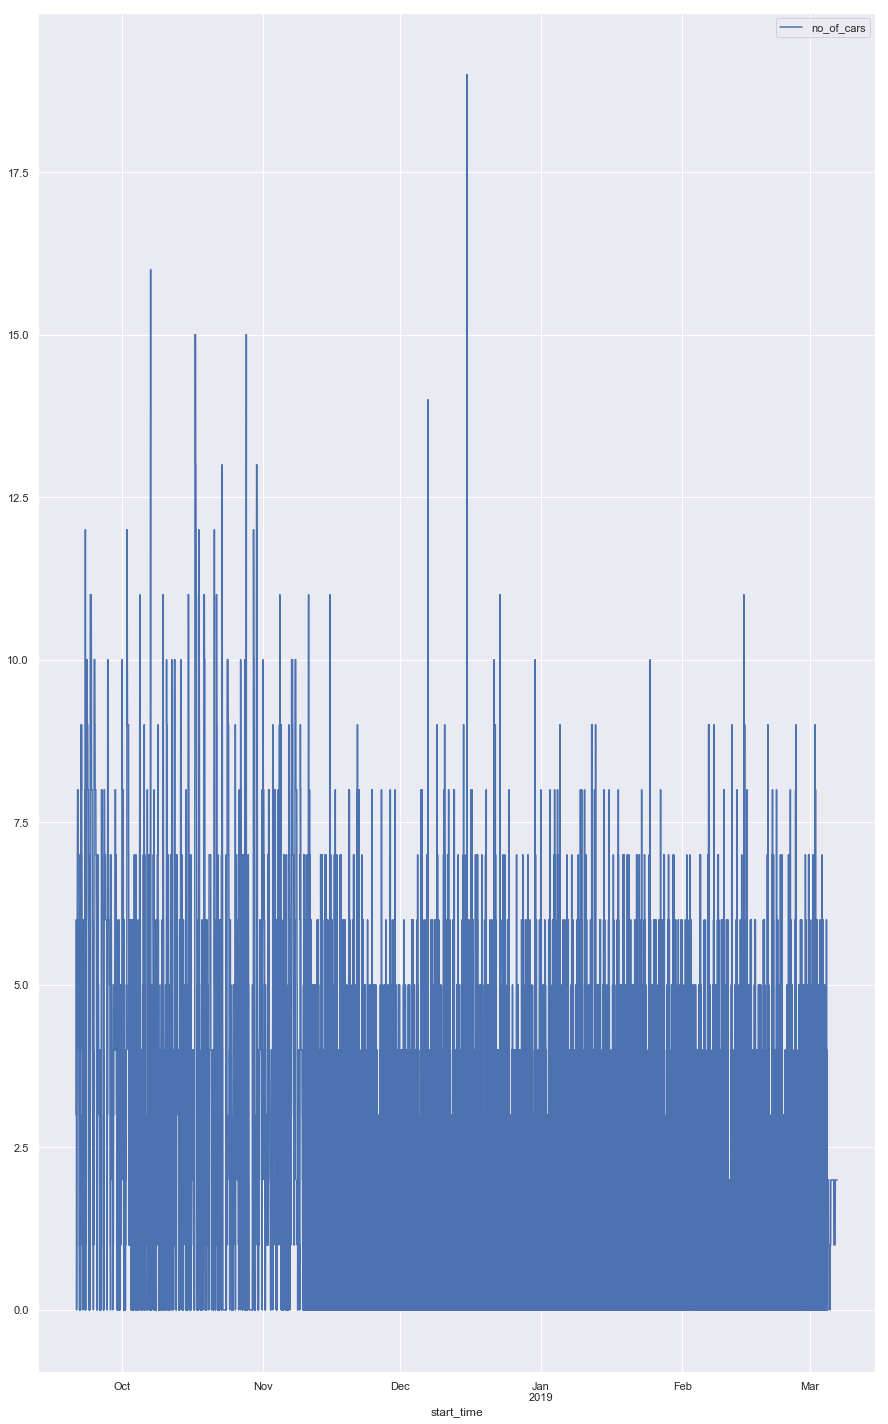

In [714]:
df_tst_5min_mar[['start_time','no_of_cars']].set_index('start_time').plot()

In [715]:
df_tst_5min = df_5min.loc[(df_5min['sensor_id']=='SENSITY-kc-14')  &
                       (df_5min.start_time.dt.date.astype(str) 
                                                                  >= '2019-03-07') &
                          (df_5min.start_time.dt.date.astype(str) 
                                                                  <= '2019-04-11')
                      ][['start_time','no_of_cars']]

In [716]:
len(df_tst_5min)

7724

In [717]:
df_tst_5min.head()

start_time  no_of_cars
585771 2019-03-07 20:50:00           1
585782 2019-03-07 20:55:00           3
585793 2019-03-07 21:00:00           2
585806 2019-03-07 21:05:00           4
585819 2019-03-07 21:10:00           2

In [718]:
df_tst_5min.tail()

start_time  no_of_cars
693908 2019-04-11 20:55:00           3
693920 2019-04-11 21:00:00           1
693933 2019-04-11 21:05:00           1
693944 2019-04-11 21:10:00           1
693953 2019-04-11 21:15:00           3

In [720]:
temp_data=[]
time = dt.datetime(2019, 3, 6, 0, 0, 0)
print('starting',time)
for x in np.arange(0,36,1):
#     print(time+ pd.to_timedelta(x,unit='d'))
    time=time+ pd.DateOffset(1)
#     print(time)
    for y in np.arange(0,1440, 5):
#         print(time+ pd.to_timedelta(y, unit='m'))
        val=time+ pd.to_timedelta(y, unit='m')
        print(val)
        temp_data.append(val)

starting 2019-03-06 00:00:00
2019-03-07 00:00:00
2019-03-07 00:05:00
2019-03-07 00:10:00
2019-03-07 00:15:00
2019-03-07 00:20:00
2019-03-07 00:25:00
2019-03-07 00:30:00
2019-03-07 00:35:00
2019-03-07 00:40:00
2019-03-07 00:45:00
2019-03-07 00:50:00
2019-03-07 00:55:00
2019-03-07 01:00:00
2019-03-07 01:05:00
2019-03-07 01:10:00
2019-03-07 01:15:00
2019-03-07 01:20:00
2019-03-07 01:25:00
2019-03-07 01:30:00
2019-03-07 01:35:00
2019-03-07 01:40:00
2019-03-07 01:45:00
2019-03-07 01:50:00
2019-03-07 01:55:00
2019-03-07 02:00:00
2019-03-07 02:05:00
2019-03-07 02:10:00
2019-03-07 02:15:00
2019-03-07 02:20:00
2019-03-07 02:25:00
2019-03-07 02:30:00
2019-03-07 02:35:00
2019-03-07 02:40:00
2019-03-07 02:45:00
2019-03-07 02:50:00
2019-03-07 02:55:00
2019-03-07 03:00:00
2019-03-07 03:05:00
2019-03-07 03:10:00
2019-03-07 03:15:00
2019-03-07 03:20:00
2019-03-07 03:25:00
2019-03-07 03:30:00
2019-03-07 03:35:00
2019-03-07 03:40:00
2019-03-07 03:45:00
2019-03-07 03:50:00
2019-03-07 03:55:00
2019-03-07 

2019-03-11 21:15:00
2019-03-11 21:20:00
2019-03-11 21:25:00
2019-03-11 21:30:00
2019-03-11 21:35:00
2019-03-11 21:40:00
2019-03-11 21:45:00
2019-03-11 21:50:00
2019-03-11 21:55:00
2019-03-11 22:00:00
2019-03-11 22:05:00
2019-03-11 22:10:00
2019-03-11 22:15:00
2019-03-11 22:20:00
2019-03-11 22:25:00
2019-03-11 22:30:00
2019-03-11 22:35:00
2019-03-11 22:40:00
2019-03-11 22:45:00
2019-03-11 22:50:00
2019-03-11 22:55:00
2019-03-11 23:00:00
2019-03-11 23:05:00
2019-03-11 23:10:00
2019-03-11 23:15:00
2019-03-11 23:20:00
2019-03-11 23:25:00
2019-03-11 23:30:00
2019-03-11 23:35:00
2019-03-11 23:40:00
2019-03-11 23:45:00
2019-03-11 23:50:00
2019-03-11 23:55:00
2019-03-12 00:00:00
2019-03-12 00:05:00
2019-03-12 00:10:00
2019-03-12 00:15:00
2019-03-12 00:20:00
2019-03-12 00:25:00
2019-03-12 00:30:00
2019-03-12 00:35:00
2019-03-12 00:40:00
2019-03-12 00:45:00
2019-03-12 00:50:00
2019-03-12 00:55:00
2019-03-12 01:00:00
2019-03-12 01:05:00
2019-03-12 01:10:00
2019-03-12 01:15:00
2019-03-12 01:20:00


2019-03-16 13:40:00
2019-03-16 13:45:00
2019-03-16 13:50:00
2019-03-16 13:55:00
2019-03-16 14:00:00
2019-03-16 14:05:00
2019-03-16 14:10:00
2019-03-16 14:15:00
2019-03-16 14:20:00
2019-03-16 14:25:00
2019-03-16 14:30:00
2019-03-16 14:35:00
2019-03-16 14:40:00
2019-03-16 14:45:00
2019-03-16 14:50:00
2019-03-16 14:55:00
2019-03-16 15:00:00
2019-03-16 15:05:00
2019-03-16 15:10:00
2019-03-16 15:15:00
2019-03-16 15:20:00
2019-03-16 15:25:00
2019-03-16 15:30:00
2019-03-16 15:35:00
2019-03-16 15:40:00
2019-03-16 15:45:00
2019-03-16 15:50:00
2019-03-16 15:55:00
2019-03-16 16:00:00
2019-03-16 16:05:00
2019-03-16 16:10:00
2019-03-16 16:15:00
2019-03-16 16:20:00
2019-03-16 16:25:00
2019-03-16 16:30:00
2019-03-16 16:35:00
2019-03-16 16:40:00
2019-03-16 16:45:00
2019-03-16 16:50:00
2019-03-16 16:55:00
2019-03-16 17:00:00
2019-03-16 17:05:00
2019-03-16 17:10:00
2019-03-16 17:15:00
2019-03-16 17:20:00
2019-03-16 17:25:00
2019-03-16 17:30:00
2019-03-16 17:35:00
2019-03-16 17:40:00
2019-03-16 17:45:00


2019-03-20 13:30:00
2019-03-20 13:35:00
2019-03-20 13:40:00
2019-03-20 13:45:00
2019-03-20 13:50:00
2019-03-20 13:55:00
2019-03-20 14:00:00
2019-03-20 14:05:00
2019-03-20 14:10:00
2019-03-20 14:15:00
2019-03-20 14:20:00
2019-03-20 14:25:00
2019-03-20 14:30:00
2019-03-20 14:35:00
2019-03-20 14:40:00
2019-03-20 14:45:00
2019-03-20 14:50:00
2019-03-20 14:55:00
2019-03-20 15:00:00
2019-03-20 15:05:00
2019-03-20 15:10:00
2019-03-20 15:15:00
2019-03-20 15:20:00
2019-03-20 15:25:00
2019-03-20 15:30:00
2019-03-20 15:35:00
2019-03-20 15:40:00
2019-03-20 15:45:00
2019-03-20 15:50:00
2019-03-20 15:55:00
2019-03-20 16:00:00
2019-03-20 16:05:00
2019-03-20 16:10:00
2019-03-20 16:15:00
2019-03-20 16:20:00
2019-03-20 16:25:00
2019-03-20 16:30:00
2019-03-20 16:35:00
2019-03-20 16:40:00
2019-03-20 16:45:00
2019-03-20 16:50:00
2019-03-20 16:55:00
2019-03-20 17:00:00
2019-03-20 17:05:00
2019-03-20 17:10:00
2019-03-20 17:15:00
2019-03-20 17:20:00
2019-03-20 17:25:00
2019-03-20 17:30:00
2019-03-20 17:35:00


2019-03-25 18:25:00
2019-03-25 18:30:00
2019-03-25 18:35:00
2019-03-25 18:40:00
2019-03-25 18:45:00
2019-03-25 18:50:00
2019-03-25 18:55:00
2019-03-25 19:00:00
2019-03-25 19:05:00
2019-03-25 19:10:00
2019-03-25 19:15:00
2019-03-25 19:20:00
2019-03-25 19:25:00
2019-03-25 19:30:00
2019-03-25 19:35:00
2019-03-25 19:40:00
2019-03-25 19:45:00
2019-03-25 19:50:00
2019-03-25 19:55:00
2019-03-25 20:00:00
2019-03-25 20:05:00
2019-03-25 20:10:00
2019-03-25 20:15:00
2019-03-25 20:20:00
2019-03-25 20:25:00
2019-03-25 20:30:00
2019-03-25 20:35:00
2019-03-25 20:40:00
2019-03-25 20:45:00
2019-03-25 20:50:00
2019-03-25 20:55:00
2019-03-25 21:00:00
2019-03-25 21:05:00
2019-03-25 21:10:00
2019-03-25 21:15:00
2019-03-25 21:20:00
2019-03-25 21:25:00
2019-03-25 21:30:00
2019-03-25 21:35:00
2019-03-25 21:40:00
2019-03-25 21:45:00
2019-03-25 21:50:00
2019-03-25 21:55:00
2019-03-25 22:00:00
2019-03-25 22:05:00
2019-03-25 22:10:00
2019-03-25 22:15:00
2019-03-25 22:20:00
2019-03-25 22:25:00
2019-03-25 22:30:00


2019-03-30 23:25:00
2019-03-30 23:30:00
2019-03-30 23:35:00
2019-03-30 23:40:00
2019-03-30 23:45:00
2019-03-30 23:50:00
2019-03-30 23:55:00
2019-03-31 00:00:00
2019-03-31 00:05:00
2019-03-31 00:10:00
2019-03-31 00:15:00
2019-03-31 00:20:00
2019-03-31 00:25:00
2019-03-31 00:30:00
2019-03-31 00:35:00
2019-03-31 00:40:00
2019-03-31 00:45:00
2019-03-31 00:50:00
2019-03-31 00:55:00
2019-03-31 01:00:00
2019-03-31 01:05:00
2019-03-31 01:10:00
2019-03-31 01:15:00
2019-03-31 01:20:00
2019-03-31 01:25:00
2019-03-31 01:30:00
2019-03-31 01:35:00
2019-03-31 01:40:00
2019-03-31 01:45:00
2019-03-31 01:50:00
2019-03-31 01:55:00
2019-03-31 02:00:00
2019-03-31 02:05:00
2019-03-31 02:10:00
2019-03-31 02:15:00
2019-03-31 02:20:00
2019-03-31 02:25:00
2019-03-31 02:30:00
2019-03-31 02:35:00
2019-03-31 02:40:00
2019-03-31 02:45:00
2019-03-31 02:50:00
2019-03-31 02:55:00
2019-03-31 03:00:00
2019-03-31 03:05:00
2019-03-31 03:10:00
2019-03-31 03:15:00
2019-03-31 03:20:00
2019-03-31 03:25:00
2019-03-31 03:30:00


2019-04-05 04:20:00
2019-04-05 04:25:00
2019-04-05 04:30:00
2019-04-05 04:35:00
2019-04-05 04:40:00
2019-04-05 04:45:00
2019-04-05 04:50:00
2019-04-05 04:55:00
2019-04-05 05:00:00
2019-04-05 05:05:00
2019-04-05 05:10:00
2019-04-05 05:15:00
2019-04-05 05:20:00
2019-04-05 05:25:00
2019-04-05 05:30:00
2019-04-05 05:35:00
2019-04-05 05:40:00
2019-04-05 05:45:00
2019-04-05 05:50:00
2019-04-05 05:55:00
2019-04-05 06:00:00
2019-04-05 06:05:00
2019-04-05 06:10:00
2019-04-05 06:15:00
2019-04-05 06:20:00
2019-04-05 06:25:00
2019-04-05 06:30:00
2019-04-05 06:35:00
2019-04-05 06:40:00
2019-04-05 06:45:00
2019-04-05 06:50:00
2019-04-05 06:55:00
2019-04-05 07:00:00
2019-04-05 07:05:00
2019-04-05 07:10:00
2019-04-05 07:15:00
2019-04-05 07:20:00
2019-04-05 07:25:00
2019-04-05 07:30:00
2019-04-05 07:35:00
2019-04-05 07:40:00
2019-04-05 07:45:00
2019-04-05 07:50:00
2019-04-05 07:55:00
2019-04-05 08:00:00
2019-04-05 08:05:00
2019-04-05 08:10:00
2019-04-05 08:15:00
2019-04-05 08:20:00
2019-04-05 08:25:00


2019-04-10 09:20:00
2019-04-10 09:25:00
2019-04-10 09:30:00
2019-04-10 09:35:00
2019-04-10 09:40:00
2019-04-10 09:45:00
2019-04-10 09:50:00
2019-04-10 09:55:00
2019-04-10 10:00:00
2019-04-10 10:05:00
2019-04-10 10:10:00
2019-04-10 10:15:00
2019-04-10 10:20:00
2019-04-10 10:25:00
2019-04-10 10:30:00
2019-04-10 10:35:00
2019-04-10 10:40:00
2019-04-10 10:45:00
2019-04-10 10:50:00
2019-04-10 10:55:00
2019-04-10 11:00:00
2019-04-10 11:05:00
2019-04-10 11:10:00
2019-04-10 11:15:00
2019-04-10 11:20:00
2019-04-10 11:25:00
2019-04-10 11:30:00
2019-04-10 11:35:00
2019-04-10 11:40:00
2019-04-10 11:45:00
2019-04-10 11:50:00
2019-04-10 11:55:00
2019-04-10 12:00:00
2019-04-10 12:05:00
2019-04-10 12:10:00
2019-04-10 12:15:00
2019-04-10 12:20:00
2019-04-10 12:25:00
2019-04-10 12:30:00
2019-04-10 12:35:00
2019-04-10 12:40:00
2019-04-10 12:45:00
2019-04-10 12:50:00
2019-04-10 12:55:00
2019-04-10 13:00:00
2019-04-10 13:05:00
2019-04-10 13:10:00
2019-04-10 13:15:00
2019-04-10 13:20:00
2019-04-10 13:25:00


In [721]:
df_start_time = pd.DataFrame(temp_data)
df_start_time.head()
df_start_time.rename(columns={0:'start_time'},inplace=True)
merged_part_df=pd.merge(df_start_time, df_tst_5min,on='start_time', how='outer')
merged_part_df.head(50)
merged_part_df.fillna(0,inplace=True)
merged_part_df.groupby([merged_part_df.start_time.dt.date])\
.count()[['start_time']]

start_time
start_time            
2019-03-07         288
2019-03-08         288
2019-03-09         288
2019-03-10         288
2019-03-11         288
2019-03-12         288
2019-03-13         288
2019-03-14         288
2019-03-15         288
2019-03-16         288
2019-03-17         288
2019-03-18         288
2019-03-19         288
2019-03-20         288
2019-03-21         288
2019-03-22         288
2019-03-23         288
2019-03-24         288
2019-03-25         288
2019-03-26         288
2019-03-27         288
2019-03-28         288
2019-03-29         288
2019-03-30         288
2019-03-31         288
2019-04-01         288
2019-04-02         288
2019-04-03         288
2019-04-04         288
2019-04-05         288
2019-04-06         288
2019-04-07         288
2019-04-08         288
2019-04-09         288
2019-04-10         288
2019-04-11         288

In [726]:
merged_part_df.tail()

start_time  no_of_cars
10363 2019-04-11 23:35:00         0.0
10364 2019-04-11 23:40:00         0.0
10365 2019-04-11 23:45:00         0.0
10366 2019-04-11 23:50:00         0.0
10367 2019-04-11 23:55:00         0.0

In [727]:
merged_part_df.head()

start_time  no_of_cars
0 2019-03-07 00:00:00         0.0
1 2019-03-07 00:05:00         0.0
2 2019-03-07 00:10:00         0.0
3 2019-03-07 00:15:00         0.0
4 2019-03-07 00:20:00         0.0

In [728]:
len(merged_part_df)

10368

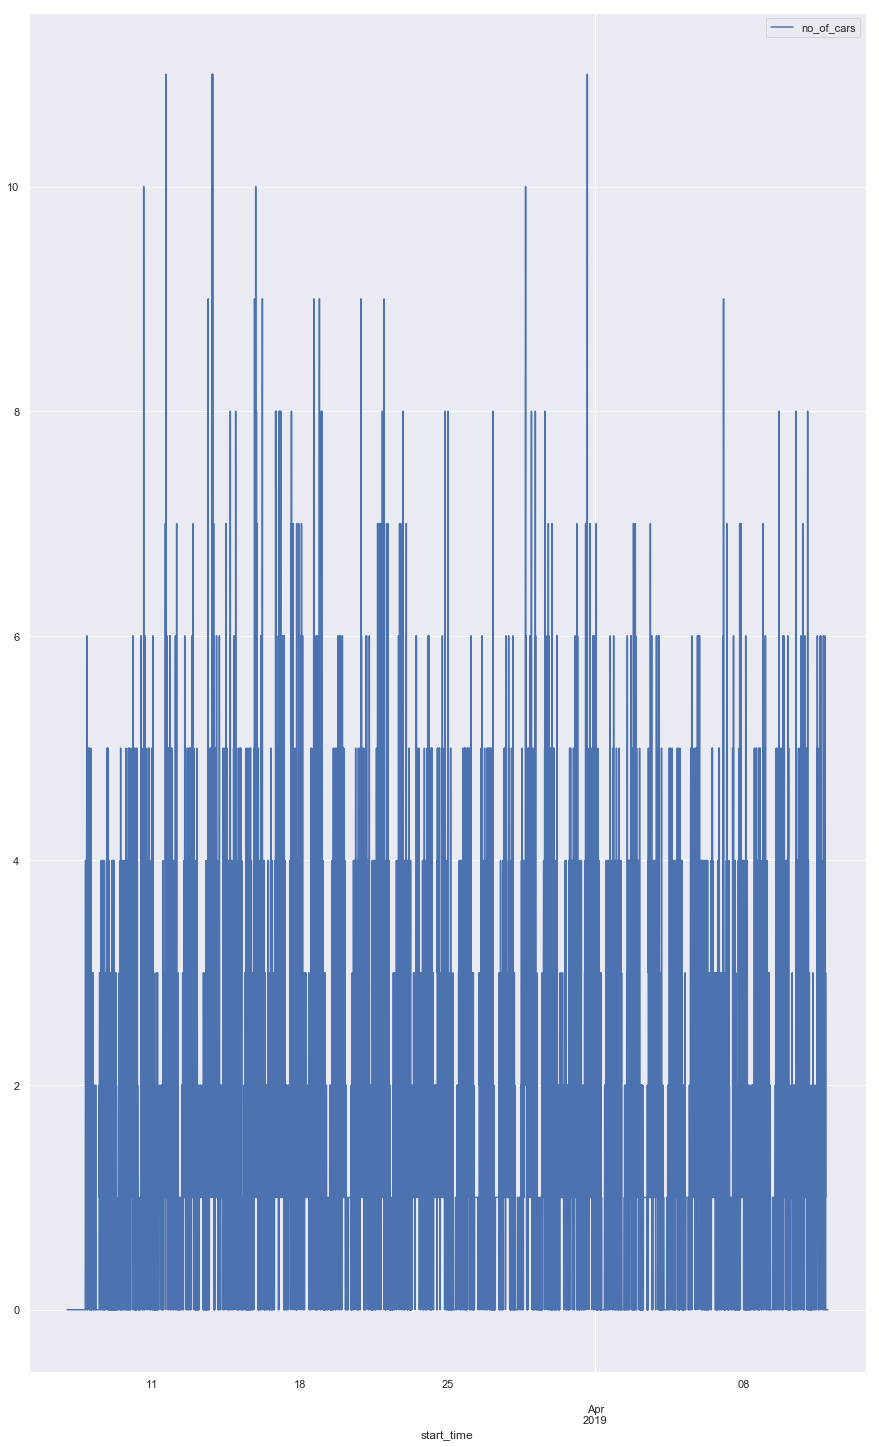

In [729]:
merged_part_df[['start_time','no_of_cars']].set_index('start_time').plot()

In [762]:
frames=[df_tst_5min_sept,df_tst_5min_mar,merged_part_df]
df_tst_5min = pd.concat(frames)

In [764]:
len(df_tst_5min)

70560

In [763]:
df_tst_5min.groupby([df_tst_5min.start_time.dt.date])\
.count()[['start_time']]

start_time
start_time            
2018-08-10         288
2018-08-11         288
2018-08-12         288
2018-08-13         288
2018-08-14         288
2018-08-15         288
2018-08-16         288
2018-08-17         288
2018-08-18         288
2018-08-19         288
2018-08-20         288
2018-08-21         288
2018-08-22         288
2018-08-23         288
2018-08-24         288
2018-08-25         288
2018-08-26         288
2018-08-27         288
2018-08-28         288
2018-08-29         288
2018-08-30         288
2018-08-31         288
2018-09-01         288
2018-09-02         288
2018-09-03         288
2018-09-04         288
2018-09-05         288
2018-09-06         288
2018-09-07         288
2018-09-08         288
...                ...
2019-03-13         288
2019-03-14         288
2019-03-15         288
2019-03-16         288
2019-03-17         288
2019-03-18         288
2019-03-19         288
2019-03-20         288
2019-03-21         288
2019-03-22         288
2019-03-23         288
2019-03-24         288
2019-03-25         288
2019-03-26         288
2019-03-27         288
2019-03-28         288
2019-03-29         288
2019-03-30         288
2019-03-31         288
2019-04-01         288
2019-04-02         288
2019-04-03         288
2019-04-04         288
2019-04-05         288
2019-04-06         288
2019-04-07         288
2019-04-08         288
2019-04-09         288
2019-04-10         288
2019-04-11         288

[245 rows x 1 columns]

In [733]:
df_tst_5min.tail()

start_time  no_of_cars
10363 2019-04-11 23:35:00         0.0
10364 2019-04-11 23:40:00         0.0
10365 2019-04-11 23:45:00         0.0
10366 2019-04-11 23:50:00         0.0
10367 2019-04-11 23:55:00         0.0

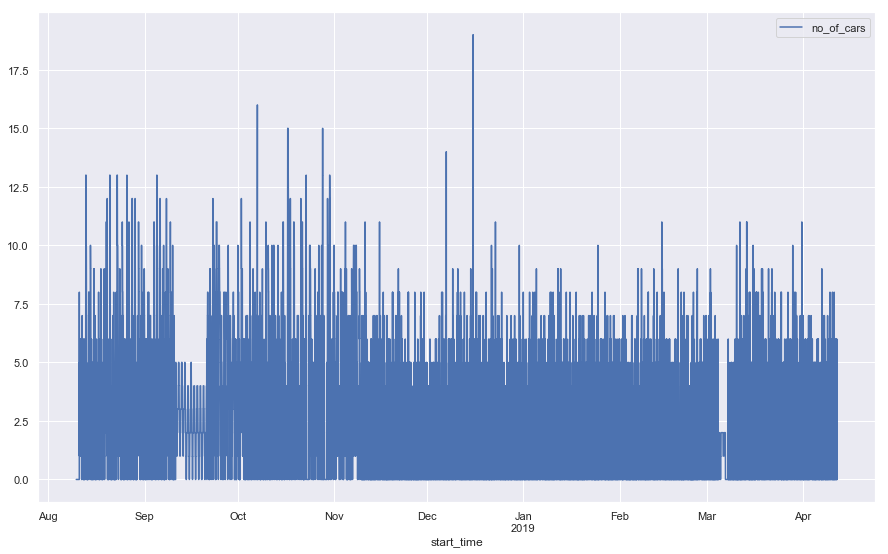

In [1036]:
df_tst_5min[['start_time','no_of_cars']].set_index('start_time').plot()

In [765]:
df_tst_5min.head()

start_time  no_of_cars
0 2018-08-10 00:00:00         0.0
1 2018-08-10 00:05:00         0.0
2 2018-08-10 00:10:00         0.0
3 2018-08-10 00:15:00         0.0
4 2018-08-10 00:20:00         0.0

In [741]:
temp_df = df_5min.loc[df_5min['no_of_cars']>=18].groupby(['sensor_id']).count()[['no_of_cars']]

In [742]:
temp_df.reset_index(inplace=True)

In [743]:
temp_df =temp_df.sort_values(by=['no_of_cars'],ascending=False)

In [744]:
temp_df

sensor_id  no_of_cars
5   SENSITY-kc-9           7
0  SENSITY-kc-10           4
1  SENSITY-kc-14           1
2  SENSITY-kc-15           1
3  SENSITY-kc-21           1
4   SENSITY-kc-7           1

In [745]:
loc_df =df_5min.loc[(df_5min['no_of_cars']>15) & (df_5min['sensor_id']=='SENSITY-kc-14')]\
.sort_values(by=['no_of_cars'],ascending=False)

In [746]:
loc_df['weekday'] = loc_df.start_time.dt.weekday_name

In [747]:
loc_df

start_time            end_time      sensor_id  no_of_cars  \
359637 2018-12-15 18:50:00 2018-12-15 18:55:00  SENSITY-kc-14          19   
149876 2018-10-07 07:45:00 2018-10-07 07:50:00  SENSITY-kc-14          16   

         weekday  
359637  Saturday  
149876    Sunday

In [748]:
df_tst_5min.shape

(70560, 1)

In [354]:
import datetime
import forecastio

date = datetime.datetime(2019,2,24)
forecast = forecastio.load_forecast('0e155618318f98a336114f44c5595e73', 39.0968, -94.5838, units="us",time=date)
print(date)

2019-02-24 00:00:00


In [356]:
h = forecast.hourly()
k=h.data
for f in k:
    if(f.d.get('temperature') is not None):
        print(f.d.get('temperature'))
        try:
            print('boss it is',f.d['temperature'])
        except KeyError:
            pass

28.95
boss it is 28.95
29.47
boss it is 29.47
28.69
boss it is 28.69
28.31
boss it is 28.31
27.77
boss it is 27.77
27.26
boss it is 27.26
26.31
boss it is 26.31
25.95
boss it is 25.95
25.77
boss it is 25.77
27.19
boss it is 27.19
28.16
boss it is 28.16
29.37
boss it is 29.37
28.48
boss it is 28.48
29.05
boss it is 29.05
29.85
boss it is 29.85
28.4
boss it is 28.4
27.2
boss it is 27.2
25.49
boss it is 25.49
23.81
boss it is 23.81
22.64
boss it is 22.64
21.7
boss it is 21.7
20.51
boss it is 20.51


In [766]:
temp_data=[]
time = dt.datetime(2018, 8, 9, 0, 0, 0)
print('starting',time)
for x in np.arange(0,245,1):
#     print(time+ pd.to_timedelta(x,unit='d'))
    time=time+ pd.DateOffset(1)
#     print(time)
    for y in np.arange(0,1440, 5):
#         print(time+ pd.to_timedelta(y, unit='m'))
        val=time+ pd.to_timedelta(y, unit='m')
        print(val)
        temp_data.append(val)

starting 2018-08-09 00:00:00
2018-08-10 00:00:00
2018-08-10 00:05:00
2018-08-10 00:10:00
2018-08-10 00:15:00
2018-08-10 00:20:00
2018-08-10 00:25:00
2018-08-10 00:30:00
2018-08-10 00:35:00
2018-08-10 00:40:00
2018-08-10 00:45:00
2018-08-10 00:50:00
2018-08-10 00:55:00
2018-08-10 01:00:00
2018-08-10 01:05:00
2018-08-10 01:10:00
2018-08-10 01:15:00
2018-08-10 01:20:00
2018-08-10 01:25:00
2018-08-10 01:30:00
2018-08-10 01:35:00
2018-08-10 01:40:00
2018-08-10 01:45:00
2018-08-10 01:50:00
2018-08-10 01:55:00
2018-08-10 02:00:00
2018-08-10 02:05:00
2018-08-10 02:10:00
2018-08-10 02:15:00
2018-08-10 02:20:00
2018-08-10 02:25:00
2018-08-10 02:30:00
2018-08-10 02:35:00
2018-08-10 02:40:00
2018-08-10 02:45:00
2018-08-10 02:50:00
2018-08-10 02:55:00
2018-08-10 03:00:00
2018-08-10 03:05:00
2018-08-10 03:10:00
2018-08-10 03:15:00
2018-08-10 03:20:00
2018-08-10 03:25:00
2018-08-10 03:30:00
2018-08-10 03:35:00
2018-08-10 03:40:00
2018-08-10 03:45:00
2018-08-10 03:50:00
2018-08-10 03:55:00
2018-08-10 

2018-08-14 20:40:00
2018-08-14 20:45:00
2018-08-14 20:50:00
2018-08-14 20:55:00
2018-08-14 21:00:00
2018-08-14 21:05:00
2018-08-14 21:10:00
2018-08-14 21:15:00
2018-08-14 21:20:00
2018-08-14 21:25:00
2018-08-14 21:30:00
2018-08-14 21:35:00
2018-08-14 21:40:00
2018-08-14 21:45:00
2018-08-14 21:50:00
2018-08-14 21:55:00
2018-08-14 22:00:00
2018-08-14 22:05:00
2018-08-14 22:10:00
2018-08-14 22:15:00
2018-08-14 22:20:00
2018-08-14 22:25:00
2018-08-14 22:30:00
2018-08-14 22:35:00
2018-08-14 22:40:00
2018-08-14 22:45:00
2018-08-14 22:50:00
2018-08-14 22:55:00
2018-08-14 23:00:00
2018-08-14 23:05:00
2018-08-14 23:10:00
2018-08-14 23:15:00
2018-08-14 23:20:00
2018-08-14 23:25:00
2018-08-14 23:30:00
2018-08-14 23:35:00
2018-08-14 23:40:00
2018-08-14 23:45:00
2018-08-14 23:50:00
2018-08-14 23:55:00
2018-08-15 00:00:00
2018-08-15 00:05:00
2018-08-15 00:10:00
2018-08-15 00:15:00
2018-08-15 00:20:00
2018-08-15 00:25:00
2018-08-15 00:30:00
2018-08-15 00:35:00
2018-08-15 00:40:00
2018-08-15 00:45:00


2018-08-18 21:50:00
2018-08-18 21:55:00
2018-08-18 22:00:00
2018-08-18 22:05:00
2018-08-18 22:10:00
2018-08-18 22:15:00
2018-08-18 22:20:00
2018-08-18 22:25:00
2018-08-18 22:30:00
2018-08-18 22:35:00
2018-08-18 22:40:00
2018-08-18 22:45:00
2018-08-18 22:50:00
2018-08-18 22:55:00
2018-08-18 23:00:00
2018-08-18 23:05:00
2018-08-18 23:10:00
2018-08-18 23:15:00
2018-08-18 23:20:00
2018-08-18 23:25:00
2018-08-18 23:30:00
2018-08-18 23:35:00
2018-08-18 23:40:00
2018-08-18 23:45:00
2018-08-18 23:50:00
2018-08-18 23:55:00
2018-08-19 00:00:00
2018-08-19 00:05:00
2018-08-19 00:10:00
2018-08-19 00:15:00
2018-08-19 00:20:00
2018-08-19 00:25:00
2018-08-19 00:30:00
2018-08-19 00:35:00
2018-08-19 00:40:00
2018-08-19 00:45:00
2018-08-19 00:50:00
2018-08-19 00:55:00
2018-08-19 01:00:00
2018-08-19 01:05:00
2018-08-19 01:10:00
2018-08-19 01:15:00
2018-08-19 01:20:00
2018-08-19 01:25:00
2018-08-19 01:30:00
2018-08-19 01:35:00
2018-08-19 01:40:00
2018-08-19 01:45:00
2018-08-19 01:50:00
2018-08-19 01:55:00


2018-08-23 12:55:00
2018-08-23 13:00:00
2018-08-23 13:05:00
2018-08-23 13:10:00
2018-08-23 13:15:00
2018-08-23 13:20:00
2018-08-23 13:25:00
2018-08-23 13:30:00
2018-08-23 13:35:00
2018-08-23 13:40:00
2018-08-23 13:45:00
2018-08-23 13:50:00
2018-08-23 13:55:00
2018-08-23 14:00:00
2018-08-23 14:05:00
2018-08-23 14:10:00
2018-08-23 14:15:00
2018-08-23 14:20:00
2018-08-23 14:25:00
2018-08-23 14:30:00
2018-08-23 14:35:00
2018-08-23 14:40:00
2018-08-23 14:45:00
2018-08-23 14:50:00
2018-08-23 14:55:00
2018-08-23 15:00:00
2018-08-23 15:05:00
2018-08-23 15:10:00
2018-08-23 15:15:00
2018-08-23 15:20:00
2018-08-23 15:25:00
2018-08-23 15:30:00
2018-08-23 15:35:00
2018-08-23 15:40:00
2018-08-23 15:45:00
2018-08-23 15:50:00
2018-08-23 15:55:00
2018-08-23 16:00:00
2018-08-23 16:05:00
2018-08-23 16:10:00
2018-08-23 16:15:00
2018-08-23 16:20:00
2018-08-23 16:25:00
2018-08-23 16:30:00
2018-08-23 16:35:00
2018-08-23 16:40:00
2018-08-23 16:45:00
2018-08-23 16:50:00
2018-08-23 16:55:00
2018-08-23 17:00:00


2018-08-28 17:50:00
2018-08-28 17:55:00
2018-08-28 18:00:00
2018-08-28 18:05:00
2018-08-28 18:10:00
2018-08-28 18:15:00
2018-08-28 18:20:00
2018-08-28 18:25:00
2018-08-28 18:30:00
2018-08-28 18:35:00
2018-08-28 18:40:00
2018-08-28 18:45:00
2018-08-28 18:50:00
2018-08-28 18:55:00
2018-08-28 19:00:00
2018-08-28 19:05:00
2018-08-28 19:10:00
2018-08-28 19:15:00
2018-08-28 19:20:00
2018-08-28 19:25:00
2018-08-28 19:30:00
2018-08-28 19:35:00
2018-08-28 19:40:00
2018-08-28 19:45:00
2018-08-28 19:50:00
2018-08-28 19:55:00
2018-08-28 20:00:00
2018-08-28 20:05:00
2018-08-28 20:10:00
2018-08-28 20:15:00
2018-08-28 20:20:00
2018-08-28 20:25:00
2018-08-28 20:30:00
2018-08-28 20:35:00
2018-08-28 20:40:00
2018-08-28 20:45:00
2018-08-28 20:50:00
2018-08-28 20:55:00
2018-08-28 21:00:00
2018-08-28 21:05:00
2018-08-28 21:10:00
2018-08-28 21:15:00
2018-08-28 21:20:00
2018-08-28 21:25:00
2018-08-28 21:30:00
2018-08-28 21:35:00
2018-08-28 21:40:00
2018-08-28 21:45:00
2018-08-28 21:50:00
2018-08-28 21:55:00


2018-09-02 22:50:00
2018-09-02 22:55:00
2018-09-02 23:00:00
2018-09-02 23:05:00
2018-09-02 23:10:00
2018-09-02 23:15:00
2018-09-02 23:20:00
2018-09-02 23:25:00
2018-09-02 23:30:00
2018-09-02 23:35:00
2018-09-02 23:40:00
2018-09-02 23:45:00
2018-09-02 23:50:00
2018-09-02 23:55:00
2018-09-03 00:00:00
2018-09-03 00:05:00
2018-09-03 00:10:00
2018-09-03 00:15:00
2018-09-03 00:20:00
2018-09-03 00:25:00
2018-09-03 00:30:00
2018-09-03 00:35:00
2018-09-03 00:40:00
2018-09-03 00:45:00
2018-09-03 00:50:00
2018-09-03 00:55:00
2018-09-03 01:00:00
2018-09-03 01:05:00
2018-09-03 01:10:00
2018-09-03 01:15:00
2018-09-03 01:20:00
2018-09-03 01:25:00
2018-09-03 01:30:00
2018-09-03 01:35:00
2018-09-03 01:40:00
2018-09-03 01:45:00
2018-09-03 01:50:00
2018-09-03 01:55:00
2018-09-03 02:00:00
2018-09-03 02:05:00
2018-09-03 02:10:00
2018-09-03 02:15:00
2018-09-03 02:20:00
2018-09-03 02:25:00
2018-09-03 02:30:00
2018-09-03 02:35:00
2018-09-03 02:40:00
2018-09-03 02:45:00
2018-09-03 02:50:00
2018-09-03 02:55:00


2018-09-08 03:45:00
2018-09-08 03:50:00
2018-09-08 03:55:00
2018-09-08 04:00:00
2018-09-08 04:05:00
2018-09-08 04:10:00
2018-09-08 04:15:00
2018-09-08 04:20:00
2018-09-08 04:25:00
2018-09-08 04:30:00
2018-09-08 04:35:00
2018-09-08 04:40:00
2018-09-08 04:45:00
2018-09-08 04:50:00
2018-09-08 04:55:00
2018-09-08 05:00:00
2018-09-08 05:05:00
2018-09-08 05:10:00
2018-09-08 05:15:00
2018-09-08 05:20:00
2018-09-08 05:25:00
2018-09-08 05:30:00
2018-09-08 05:35:00
2018-09-08 05:40:00
2018-09-08 05:45:00
2018-09-08 05:50:00
2018-09-08 05:55:00
2018-09-08 06:00:00
2018-09-08 06:05:00
2018-09-08 06:10:00
2018-09-08 06:15:00
2018-09-08 06:20:00
2018-09-08 06:25:00
2018-09-08 06:30:00
2018-09-08 06:35:00
2018-09-08 06:40:00
2018-09-08 06:45:00
2018-09-08 06:50:00
2018-09-08 06:55:00
2018-09-08 07:00:00
2018-09-08 07:05:00
2018-09-08 07:10:00
2018-09-08 07:15:00
2018-09-08 07:20:00
2018-09-08 07:25:00
2018-09-08 07:30:00
2018-09-08 07:35:00
2018-09-08 07:40:00
2018-09-08 07:45:00
2018-09-08 07:50:00


2018-09-13 08:45:00
2018-09-13 08:50:00
2018-09-13 08:55:00
2018-09-13 09:00:00
2018-09-13 09:05:00
2018-09-13 09:10:00
2018-09-13 09:15:00
2018-09-13 09:20:00
2018-09-13 09:25:00
2018-09-13 09:30:00
2018-09-13 09:35:00
2018-09-13 09:40:00
2018-09-13 09:45:00
2018-09-13 09:50:00
2018-09-13 09:55:00
2018-09-13 10:00:00
2018-09-13 10:05:00
2018-09-13 10:10:00
2018-09-13 10:15:00
2018-09-13 10:20:00
2018-09-13 10:25:00
2018-09-13 10:30:00
2018-09-13 10:35:00
2018-09-13 10:40:00
2018-09-13 10:45:00
2018-09-13 10:50:00
2018-09-13 10:55:00
2018-09-13 11:00:00
2018-09-13 11:05:00
2018-09-13 11:10:00
2018-09-13 11:15:00
2018-09-13 11:20:00
2018-09-13 11:25:00
2018-09-13 11:30:00
2018-09-13 11:35:00
2018-09-13 11:40:00
2018-09-13 11:45:00
2018-09-13 11:50:00
2018-09-13 11:55:00
2018-09-13 12:00:00
2018-09-13 12:05:00
2018-09-13 12:10:00
2018-09-13 12:15:00
2018-09-13 12:20:00
2018-09-13 12:25:00
2018-09-13 12:30:00
2018-09-13 12:35:00
2018-09-13 12:40:00
2018-09-13 12:45:00
2018-09-13 12:50:00


2018-09-18 13:40:00
2018-09-18 13:45:00
2018-09-18 13:50:00
2018-09-18 13:55:00
2018-09-18 14:00:00
2018-09-18 14:05:00
2018-09-18 14:10:00
2018-09-18 14:15:00
2018-09-18 14:20:00
2018-09-18 14:25:00
2018-09-18 14:30:00
2018-09-18 14:35:00
2018-09-18 14:40:00
2018-09-18 14:45:00
2018-09-18 14:50:00
2018-09-18 14:55:00
2018-09-18 15:00:00
2018-09-18 15:05:00
2018-09-18 15:10:00
2018-09-18 15:15:00
2018-09-18 15:20:00
2018-09-18 15:25:00
2018-09-18 15:30:00
2018-09-18 15:35:00
2018-09-18 15:40:00
2018-09-18 15:45:00
2018-09-18 15:50:00
2018-09-18 15:55:00
2018-09-18 16:00:00
2018-09-18 16:05:00
2018-09-18 16:10:00
2018-09-18 16:15:00
2018-09-18 16:20:00
2018-09-18 16:25:00
2018-09-18 16:30:00
2018-09-18 16:35:00
2018-09-18 16:40:00
2018-09-18 16:45:00
2018-09-18 16:50:00
2018-09-18 16:55:00
2018-09-18 17:00:00
2018-09-18 17:05:00
2018-09-18 17:10:00
2018-09-18 17:15:00
2018-09-18 17:20:00
2018-09-18 17:25:00
2018-09-18 17:30:00
2018-09-18 17:35:00
2018-09-18 17:40:00
2018-09-18 17:45:00


2018-09-23 18:40:00
2018-09-23 18:45:00
2018-09-23 18:50:00
2018-09-23 18:55:00
2018-09-23 19:00:00
2018-09-23 19:05:00
2018-09-23 19:10:00
2018-09-23 19:15:00
2018-09-23 19:20:00
2018-09-23 19:25:00
2018-09-23 19:30:00
2018-09-23 19:35:00
2018-09-23 19:40:00
2018-09-23 19:45:00
2018-09-23 19:50:00
2018-09-23 19:55:00
2018-09-23 20:00:00
2018-09-23 20:05:00
2018-09-23 20:10:00
2018-09-23 20:15:00
2018-09-23 20:20:00
2018-09-23 20:25:00
2018-09-23 20:30:00
2018-09-23 20:35:00
2018-09-23 20:40:00
2018-09-23 20:45:00
2018-09-23 20:50:00
2018-09-23 20:55:00
2018-09-23 21:00:00
2018-09-23 21:05:00
2018-09-23 21:10:00
2018-09-23 21:15:00
2018-09-23 21:20:00
2018-09-23 21:25:00
2018-09-23 21:30:00
2018-09-23 21:35:00
2018-09-23 21:40:00
2018-09-23 21:45:00
2018-09-23 21:50:00
2018-09-23 21:55:00
2018-09-23 22:00:00
2018-09-23 22:05:00
2018-09-23 22:10:00
2018-09-23 22:15:00
2018-09-23 22:20:00
2018-09-23 22:25:00
2018-09-23 22:30:00
2018-09-23 22:35:00
2018-09-23 22:40:00
2018-09-23 22:45:00


2018-09-28 23:35:00
2018-09-28 23:40:00
2018-09-28 23:45:00
2018-09-28 23:50:00
2018-09-28 23:55:00
2018-09-29 00:00:00
2018-09-29 00:05:00
2018-09-29 00:10:00
2018-09-29 00:15:00
2018-09-29 00:20:00
2018-09-29 00:25:00
2018-09-29 00:30:00
2018-09-29 00:35:00
2018-09-29 00:40:00
2018-09-29 00:45:00
2018-09-29 00:50:00
2018-09-29 00:55:00
2018-09-29 01:00:00
2018-09-29 01:05:00
2018-09-29 01:10:00
2018-09-29 01:15:00
2018-09-29 01:20:00
2018-09-29 01:25:00
2018-09-29 01:30:00
2018-09-29 01:35:00
2018-09-29 01:40:00
2018-09-29 01:45:00
2018-09-29 01:50:00
2018-09-29 01:55:00
2018-09-29 02:00:00
2018-09-29 02:05:00
2018-09-29 02:10:00
2018-09-29 02:15:00
2018-09-29 02:20:00
2018-09-29 02:25:00
2018-09-29 02:30:00
2018-09-29 02:35:00
2018-09-29 02:40:00
2018-09-29 02:45:00
2018-09-29 02:50:00
2018-09-29 02:55:00
2018-09-29 03:00:00
2018-09-29 03:05:00
2018-09-29 03:10:00
2018-09-29 03:15:00
2018-09-29 03:20:00
2018-09-29 03:25:00
2018-09-29 03:30:00
2018-09-29 03:35:00
2018-09-29 03:40:00


2018-10-04 04:35:00
2018-10-04 04:40:00
2018-10-04 04:45:00
2018-10-04 04:50:00
2018-10-04 04:55:00
2018-10-04 05:00:00
2018-10-04 05:05:00
2018-10-04 05:10:00
2018-10-04 05:15:00
2018-10-04 05:20:00
2018-10-04 05:25:00
2018-10-04 05:30:00
2018-10-04 05:35:00
2018-10-04 05:40:00
2018-10-04 05:45:00
2018-10-04 05:50:00
2018-10-04 05:55:00
2018-10-04 06:00:00
2018-10-04 06:05:00
2018-10-04 06:10:00
2018-10-04 06:15:00
2018-10-04 06:20:00
2018-10-04 06:25:00
2018-10-04 06:30:00
2018-10-04 06:35:00
2018-10-04 06:40:00
2018-10-04 06:45:00
2018-10-04 06:50:00
2018-10-04 06:55:00
2018-10-04 07:00:00
2018-10-04 07:05:00
2018-10-04 07:10:00
2018-10-04 07:15:00
2018-10-04 07:20:00
2018-10-04 07:25:00
2018-10-04 07:30:00
2018-10-04 07:35:00
2018-10-04 07:40:00
2018-10-04 07:45:00
2018-10-04 07:50:00
2018-10-04 07:55:00
2018-10-04 08:00:00
2018-10-04 08:05:00
2018-10-04 08:10:00
2018-10-04 08:15:00
2018-10-04 08:20:00
2018-10-04 08:25:00
2018-10-04 08:30:00
2018-10-04 08:35:00
2018-10-04 08:40:00


2018-10-09 09:30:00
2018-10-09 09:35:00
2018-10-09 09:40:00
2018-10-09 09:45:00
2018-10-09 09:50:00
2018-10-09 09:55:00
2018-10-09 10:00:00
2018-10-09 10:05:00
2018-10-09 10:10:00
2018-10-09 10:15:00
2018-10-09 10:20:00
2018-10-09 10:25:00
2018-10-09 10:30:00
2018-10-09 10:35:00
2018-10-09 10:40:00
2018-10-09 10:45:00
2018-10-09 10:50:00
2018-10-09 10:55:00
2018-10-09 11:00:00
2018-10-09 11:05:00
2018-10-09 11:10:00
2018-10-09 11:15:00
2018-10-09 11:20:00
2018-10-09 11:25:00
2018-10-09 11:30:00
2018-10-09 11:35:00
2018-10-09 11:40:00
2018-10-09 11:45:00
2018-10-09 11:50:00
2018-10-09 11:55:00
2018-10-09 12:00:00
2018-10-09 12:05:00
2018-10-09 12:10:00
2018-10-09 12:15:00
2018-10-09 12:20:00
2018-10-09 12:25:00
2018-10-09 12:30:00
2018-10-09 12:35:00
2018-10-09 12:40:00
2018-10-09 12:45:00
2018-10-09 12:50:00
2018-10-09 12:55:00
2018-10-09 13:00:00
2018-10-09 13:05:00
2018-10-09 13:10:00
2018-10-09 13:15:00
2018-10-09 13:20:00
2018-10-09 13:25:00
2018-10-09 13:30:00
2018-10-09 13:35:00


2018-10-14 14:30:00
2018-10-14 14:35:00
2018-10-14 14:40:00
2018-10-14 14:45:00
2018-10-14 14:50:00
2018-10-14 14:55:00
2018-10-14 15:00:00
2018-10-14 15:05:00
2018-10-14 15:10:00
2018-10-14 15:15:00
2018-10-14 15:20:00
2018-10-14 15:25:00
2018-10-14 15:30:00
2018-10-14 15:35:00
2018-10-14 15:40:00
2018-10-14 15:45:00
2018-10-14 15:50:00
2018-10-14 15:55:00
2018-10-14 16:00:00
2018-10-14 16:05:00
2018-10-14 16:10:00
2018-10-14 16:15:00
2018-10-14 16:20:00
2018-10-14 16:25:00
2018-10-14 16:30:00
2018-10-14 16:35:00
2018-10-14 16:40:00
2018-10-14 16:45:00
2018-10-14 16:50:00
2018-10-14 16:55:00
2018-10-14 17:00:00
2018-10-14 17:05:00
2018-10-14 17:10:00
2018-10-14 17:15:00
2018-10-14 17:20:00
2018-10-14 17:25:00
2018-10-14 17:30:00
2018-10-14 17:35:00
2018-10-14 17:40:00
2018-10-14 17:45:00
2018-10-14 17:50:00
2018-10-14 17:55:00
2018-10-14 18:00:00
2018-10-14 18:05:00
2018-10-14 18:10:00
2018-10-14 18:15:00
2018-10-14 18:20:00
2018-10-14 18:25:00
2018-10-14 18:30:00
2018-10-14 18:35:00


2018-10-19 19:25:00
2018-10-19 19:30:00
2018-10-19 19:35:00
2018-10-19 19:40:00
2018-10-19 19:45:00
2018-10-19 19:50:00
2018-10-19 19:55:00
2018-10-19 20:00:00
2018-10-19 20:05:00
2018-10-19 20:10:00
2018-10-19 20:15:00
2018-10-19 20:20:00
2018-10-19 20:25:00
2018-10-19 20:30:00
2018-10-19 20:35:00
2018-10-19 20:40:00
2018-10-19 20:45:00
2018-10-19 20:50:00
2018-10-19 20:55:00
2018-10-19 21:00:00
2018-10-19 21:05:00
2018-10-19 21:10:00
2018-10-19 21:15:00
2018-10-19 21:20:00
2018-10-19 21:25:00
2018-10-19 21:30:00
2018-10-19 21:35:00
2018-10-19 21:40:00
2018-10-19 21:45:00
2018-10-19 21:50:00
2018-10-19 21:55:00
2018-10-19 22:00:00
2018-10-19 22:05:00
2018-10-19 22:10:00
2018-10-19 22:15:00
2018-10-19 22:20:00
2018-10-19 22:25:00
2018-10-19 22:30:00
2018-10-19 22:35:00
2018-10-19 22:40:00
2018-10-19 22:45:00
2018-10-19 22:50:00
2018-10-19 22:55:00
2018-10-19 23:00:00
2018-10-19 23:05:00
2018-10-19 23:10:00
2018-10-19 23:15:00
2018-10-19 23:20:00
2018-10-19 23:25:00
2018-10-19 23:30:00


2018-10-25 00:25:00
2018-10-25 00:30:00
2018-10-25 00:35:00
2018-10-25 00:40:00
2018-10-25 00:45:00
2018-10-25 00:50:00
2018-10-25 00:55:00
2018-10-25 01:00:00
2018-10-25 01:05:00
2018-10-25 01:10:00
2018-10-25 01:15:00
2018-10-25 01:20:00
2018-10-25 01:25:00
2018-10-25 01:30:00
2018-10-25 01:35:00
2018-10-25 01:40:00
2018-10-25 01:45:00
2018-10-25 01:50:00
2018-10-25 01:55:00
2018-10-25 02:00:00
2018-10-25 02:05:00
2018-10-25 02:10:00
2018-10-25 02:15:00
2018-10-25 02:20:00
2018-10-25 02:25:00
2018-10-25 02:30:00
2018-10-25 02:35:00
2018-10-25 02:40:00
2018-10-25 02:45:00
2018-10-25 02:50:00
2018-10-25 02:55:00
2018-10-25 03:00:00
2018-10-25 03:05:00
2018-10-25 03:10:00
2018-10-25 03:15:00
2018-10-25 03:20:00
2018-10-25 03:25:00
2018-10-25 03:30:00
2018-10-25 03:35:00
2018-10-25 03:40:00
2018-10-25 03:45:00
2018-10-25 03:50:00
2018-10-25 03:55:00
2018-10-25 04:00:00
2018-10-25 04:05:00
2018-10-25 04:10:00
2018-10-25 04:15:00
2018-10-25 04:20:00
2018-10-25 04:25:00
2018-10-25 04:30:00


2018-10-30 05:20:00
2018-10-30 05:25:00
2018-10-30 05:30:00
2018-10-30 05:35:00
2018-10-30 05:40:00
2018-10-30 05:45:00
2018-10-30 05:50:00
2018-10-30 05:55:00
2018-10-30 06:00:00
2018-10-30 06:05:00
2018-10-30 06:10:00
2018-10-30 06:15:00
2018-10-30 06:20:00
2018-10-30 06:25:00
2018-10-30 06:30:00
2018-10-30 06:35:00
2018-10-30 06:40:00
2018-10-30 06:45:00
2018-10-30 06:50:00
2018-10-30 06:55:00
2018-10-30 07:00:00
2018-10-30 07:05:00
2018-10-30 07:10:00
2018-10-30 07:15:00
2018-10-30 07:20:00
2018-10-30 07:25:00
2018-10-30 07:30:00
2018-10-30 07:35:00
2018-10-30 07:40:00
2018-10-30 07:45:00
2018-10-30 07:50:00
2018-10-30 07:55:00
2018-10-30 08:00:00
2018-10-30 08:05:00
2018-10-30 08:10:00
2018-10-30 08:15:00
2018-10-30 08:20:00
2018-10-30 08:25:00
2018-10-30 08:30:00
2018-10-30 08:35:00
2018-10-30 08:40:00
2018-10-30 08:45:00
2018-10-30 08:50:00
2018-10-30 08:55:00
2018-10-30 09:00:00
2018-10-30 09:05:00
2018-10-30 09:10:00
2018-10-30 09:15:00
2018-10-30 09:20:00
2018-10-30 09:25:00


2018-11-04 10:20:00
2018-11-04 10:25:00
2018-11-04 10:30:00
2018-11-04 10:35:00
2018-11-04 10:40:00
2018-11-04 10:45:00
2018-11-04 10:50:00
2018-11-04 10:55:00
2018-11-04 11:00:00
2018-11-04 11:05:00
2018-11-04 11:10:00
2018-11-04 11:15:00
2018-11-04 11:20:00
2018-11-04 11:25:00
2018-11-04 11:30:00
2018-11-04 11:35:00
2018-11-04 11:40:00
2018-11-04 11:45:00
2018-11-04 11:50:00
2018-11-04 11:55:00
2018-11-04 12:00:00
2018-11-04 12:05:00
2018-11-04 12:10:00
2018-11-04 12:15:00
2018-11-04 12:20:00
2018-11-04 12:25:00
2018-11-04 12:30:00
2018-11-04 12:35:00
2018-11-04 12:40:00
2018-11-04 12:45:00
2018-11-04 12:50:00
2018-11-04 12:55:00
2018-11-04 13:00:00
2018-11-04 13:05:00
2018-11-04 13:10:00
2018-11-04 13:15:00
2018-11-04 13:20:00
2018-11-04 13:25:00
2018-11-04 13:30:00
2018-11-04 13:35:00
2018-11-04 13:40:00
2018-11-04 13:45:00
2018-11-04 13:50:00
2018-11-04 13:55:00
2018-11-04 14:00:00
2018-11-04 14:05:00
2018-11-04 14:10:00
2018-11-04 14:15:00
2018-11-04 14:20:00
2018-11-04 14:25:00


2018-11-09 15:15:00
2018-11-09 15:20:00
2018-11-09 15:25:00
2018-11-09 15:30:00
2018-11-09 15:35:00
2018-11-09 15:40:00
2018-11-09 15:45:00
2018-11-09 15:50:00
2018-11-09 15:55:00
2018-11-09 16:00:00
2018-11-09 16:05:00
2018-11-09 16:10:00
2018-11-09 16:15:00
2018-11-09 16:20:00
2018-11-09 16:25:00
2018-11-09 16:30:00
2018-11-09 16:35:00
2018-11-09 16:40:00
2018-11-09 16:45:00
2018-11-09 16:50:00
2018-11-09 16:55:00
2018-11-09 17:00:00
2018-11-09 17:05:00
2018-11-09 17:10:00
2018-11-09 17:15:00
2018-11-09 17:20:00
2018-11-09 17:25:00
2018-11-09 17:30:00
2018-11-09 17:35:00
2018-11-09 17:40:00
2018-11-09 17:45:00
2018-11-09 17:50:00
2018-11-09 17:55:00
2018-11-09 18:00:00
2018-11-09 18:05:00
2018-11-09 18:10:00
2018-11-09 18:15:00
2018-11-09 18:20:00
2018-11-09 18:25:00
2018-11-09 18:30:00
2018-11-09 18:35:00
2018-11-09 18:40:00
2018-11-09 18:45:00
2018-11-09 18:50:00
2018-11-09 18:55:00
2018-11-09 19:00:00
2018-11-09 19:05:00
2018-11-09 19:10:00
2018-11-09 19:15:00
2018-11-09 19:20:00


2018-11-14 20:15:00
2018-11-14 20:20:00
2018-11-14 20:25:00
2018-11-14 20:30:00
2018-11-14 20:35:00
2018-11-14 20:40:00
2018-11-14 20:45:00
2018-11-14 20:50:00
2018-11-14 20:55:00
2018-11-14 21:00:00
2018-11-14 21:05:00
2018-11-14 21:10:00
2018-11-14 21:15:00
2018-11-14 21:20:00
2018-11-14 21:25:00
2018-11-14 21:30:00
2018-11-14 21:35:00
2018-11-14 21:40:00
2018-11-14 21:45:00
2018-11-14 21:50:00
2018-11-14 21:55:00
2018-11-14 22:00:00
2018-11-14 22:05:00
2018-11-14 22:10:00
2018-11-14 22:15:00
2018-11-14 22:20:00
2018-11-14 22:25:00
2018-11-14 22:30:00
2018-11-14 22:35:00
2018-11-14 22:40:00
2018-11-14 22:45:00
2018-11-14 22:50:00
2018-11-14 22:55:00
2018-11-14 23:00:00
2018-11-14 23:05:00
2018-11-14 23:10:00
2018-11-14 23:15:00
2018-11-14 23:20:00
2018-11-14 23:25:00
2018-11-14 23:30:00
2018-11-14 23:35:00
2018-11-14 23:40:00
2018-11-14 23:45:00
2018-11-14 23:50:00
2018-11-14 23:55:00
2018-11-15 00:00:00
2018-11-15 00:05:00
2018-11-15 00:10:00
2018-11-15 00:15:00
2018-11-15 00:20:00


2018-11-20 01:10:00
2018-11-20 01:15:00
2018-11-20 01:20:00
2018-11-20 01:25:00
2018-11-20 01:30:00
2018-11-20 01:35:00
2018-11-20 01:40:00
2018-11-20 01:45:00
2018-11-20 01:50:00
2018-11-20 01:55:00
2018-11-20 02:00:00
2018-11-20 02:05:00
2018-11-20 02:10:00
2018-11-20 02:15:00
2018-11-20 02:20:00
2018-11-20 02:25:00
2018-11-20 02:30:00
2018-11-20 02:35:00
2018-11-20 02:40:00
2018-11-20 02:45:00
2018-11-20 02:50:00
2018-11-20 02:55:00
2018-11-20 03:00:00
2018-11-20 03:05:00
2018-11-20 03:10:00
2018-11-20 03:15:00
2018-11-20 03:20:00
2018-11-20 03:25:00
2018-11-20 03:30:00
2018-11-20 03:35:00
2018-11-20 03:40:00
2018-11-20 03:45:00
2018-11-20 03:50:00
2018-11-20 03:55:00
2018-11-20 04:00:00
2018-11-20 04:05:00
2018-11-20 04:10:00
2018-11-20 04:15:00
2018-11-20 04:20:00
2018-11-20 04:25:00
2018-11-20 04:30:00
2018-11-20 04:35:00
2018-11-20 04:40:00
2018-11-20 04:45:00
2018-11-20 04:50:00
2018-11-20 04:55:00
2018-11-20 05:00:00
2018-11-20 05:05:00
2018-11-20 05:10:00
2018-11-20 05:15:00


2018-11-25 06:10:00
2018-11-25 06:15:00
2018-11-25 06:20:00
2018-11-25 06:25:00
2018-11-25 06:30:00
2018-11-25 06:35:00
2018-11-25 06:40:00
2018-11-25 06:45:00
2018-11-25 06:50:00
2018-11-25 06:55:00
2018-11-25 07:00:00
2018-11-25 07:05:00
2018-11-25 07:10:00
2018-11-25 07:15:00
2018-11-25 07:20:00
2018-11-25 07:25:00
2018-11-25 07:30:00
2018-11-25 07:35:00
2018-11-25 07:40:00
2018-11-25 07:45:00
2018-11-25 07:50:00
2018-11-25 07:55:00
2018-11-25 08:00:00
2018-11-25 08:05:00
2018-11-25 08:10:00
2018-11-25 08:15:00
2018-11-25 08:20:00
2018-11-25 08:25:00
2018-11-25 08:30:00
2018-11-25 08:35:00
2018-11-25 08:40:00
2018-11-25 08:45:00
2018-11-25 08:50:00
2018-11-25 08:55:00
2018-11-25 09:00:00
2018-11-25 09:05:00
2018-11-25 09:10:00
2018-11-25 09:15:00
2018-11-25 09:20:00
2018-11-25 09:25:00
2018-11-25 09:30:00
2018-11-25 09:35:00
2018-11-25 09:40:00
2018-11-25 09:45:00
2018-11-25 09:50:00
2018-11-25 09:55:00
2018-11-25 10:00:00
2018-11-25 10:05:00
2018-11-25 10:10:00
2018-11-25 10:15:00


2018-11-30 11:05:00
2018-11-30 11:10:00
2018-11-30 11:15:00
2018-11-30 11:20:00
2018-11-30 11:25:00
2018-11-30 11:30:00
2018-11-30 11:35:00
2018-11-30 11:40:00
2018-11-30 11:45:00
2018-11-30 11:50:00
2018-11-30 11:55:00
2018-11-30 12:00:00
2018-11-30 12:05:00
2018-11-30 12:10:00
2018-11-30 12:15:00
2018-11-30 12:20:00
2018-11-30 12:25:00
2018-11-30 12:30:00
2018-11-30 12:35:00
2018-11-30 12:40:00
2018-11-30 12:45:00
2018-11-30 12:50:00
2018-11-30 12:55:00
2018-11-30 13:00:00
2018-11-30 13:05:00
2018-11-30 13:10:00
2018-11-30 13:15:00
2018-11-30 13:20:00
2018-11-30 13:25:00
2018-11-30 13:30:00
2018-11-30 13:35:00
2018-11-30 13:40:00
2018-11-30 13:45:00
2018-11-30 13:50:00
2018-11-30 13:55:00
2018-11-30 14:00:00
2018-11-30 14:05:00
2018-11-30 14:10:00
2018-11-30 14:15:00
2018-11-30 14:20:00
2018-11-30 14:25:00
2018-11-30 14:30:00
2018-11-30 14:35:00
2018-11-30 14:40:00
2018-11-30 14:45:00
2018-11-30 14:50:00
2018-11-30 14:55:00
2018-11-30 15:00:00
2018-11-30 15:05:00
2018-11-30 15:10:00


2018-12-05 16:05:00
2018-12-05 16:10:00
2018-12-05 16:15:00
2018-12-05 16:20:00
2018-12-05 16:25:00
2018-12-05 16:30:00
2018-12-05 16:35:00
2018-12-05 16:40:00
2018-12-05 16:45:00
2018-12-05 16:50:00
2018-12-05 16:55:00
2018-12-05 17:00:00
2018-12-05 17:05:00
2018-12-05 17:10:00
2018-12-05 17:15:00
2018-12-05 17:20:00
2018-12-05 17:25:00
2018-12-05 17:30:00
2018-12-05 17:35:00
2018-12-05 17:40:00
2018-12-05 17:45:00
2018-12-05 17:50:00
2018-12-05 17:55:00
2018-12-05 18:00:00
2018-12-05 18:05:00
2018-12-05 18:10:00
2018-12-05 18:15:00
2018-12-05 18:20:00
2018-12-05 18:25:00
2018-12-05 18:30:00
2018-12-05 18:35:00
2018-12-05 18:40:00
2018-12-05 18:45:00
2018-12-05 18:50:00
2018-12-05 18:55:00
2018-12-05 19:00:00
2018-12-05 19:05:00
2018-12-05 19:10:00
2018-12-05 19:15:00
2018-12-05 19:20:00
2018-12-05 19:25:00
2018-12-05 19:30:00
2018-12-05 19:35:00
2018-12-05 19:40:00
2018-12-05 19:45:00
2018-12-05 19:50:00
2018-12-05 19:55:00
2018-12-05 20:00:00
2018-12-05 20:05:00
2018-12-05 20:10:00


2018-12-10 21:00:00
2018-12-10 21:05:00
2018-12-10 21:10:00
2018-12-10 21:15:00
2018-12-10 21:20:00
2018-12-10 21:25:00
2018-12-10 21:30:00
2018-12-10 21:35:00
2018-12-10 21:40:00
2018-12-10 21:45:00
2018-12-10 21:50:00
2018-12-10 21:55:00
2018-12-10 22:00:00
2018-12-10 22:05:00
2018-12-10 22:10:00
2018-12-10 22:15:00
2018-12-10 22:20:00
2018-12-10 22:25:00
2018-12-10 22:30:00
2018-12-10 22:35:00
2018-12-10 22:40:00
2018-12-10 22:45:00
2018-12-10 22:50:00
2018-12-10 22:55:00
2018-12-10 23:00:00
2018-12-10 23:05:00
2018-12-10 23:10:00
2018-12-10 23:15:00
2018-12-10 23:20:00
2018-12-10 23:25:00
2018-12-10 23:30:00
2018-12-10 23:35:00
2018-12-10 23:40:00
2018-12-10 23:45:00
2018-12-10 23:50:00
2018-12-10 23:55:00
2018-12-11 00:00:00
2018-12-11 00:05:00
2018-12-11 00:10:00
2018-12-11 00:15:00
2018-12-11 00:20:00
2018-12-11 00:25:00
2018-12-11 00:30:00
2018-12-11 00:35:00
2018-12-11 00:40:00
2018-12-11 00:45:00
2018-12-11 00:50:00
2018-12-11 00:55:00
2018-12-11 01:00:00
2018-12-11 01:05:00


2018-12-12 14:40:00
2018-12-12 14:45:00
2018-12-12 14:50:00
2018-12-12 14:55:00
2018-12-12 15:00:00
2018-12-12 15:05:00
2018-12-12 15:10:00
2018-12-12 15:15:00
2018-12-12 15:20:00
2018-12-12 15:25:00
2018-12-12 15:30:00
2018-12-12 15:35:00
2018-12-12 15:40:00
2018-12-12 15:45:00
2018-12-12 15:50:00
2018-12-12 15:55:00
2018-12-12 16:00:00
2018-12-12 16:05:00
2018-12-12 16:10:00
2018-12-12 16:15:00
2018-12-12 16:20:00
2018-12-12 16:25:00
2018-12-12 16:30:00
2018-12-12 16:35:00
2018-12-12 16:40:00
2018-12-12 16:45:00
2018-12-12 16:50:00
2018-12-12 16:55:00
2018-12-12 17:00:00
2018-12-12 17:05:00
2018-12-12 17:10:00
2018-12-12 17:15:00
2018-12-12 17:20:00
2018-12-12 17:25:00
2018-12-12 17:30:00
2018-12-12 17:35:00
2018-12-12 17:40:00
2018-12-12 17:45:00
2018-12-12 17:50:00
2018-12-12 17:55:00
2018-12-12 18:00:00
2018-12-12 18:05:00
2018-12-12 18:10:00
2018-12-12 18:15:00
2018-12-12 18:20:00
2018-12-12 18:25:00
2018-12-12 18:30:00
2018-12-12 18:35:00
2018-12-12 18:40:00
2018-12-12 18:45:00


2018-12-17 19:35:00
2018-12-17 19:40:00
2018-12-17 19:45:00
2018-12-17 19:50:00
2018-12-17 19:55:00
2018-12-17 20:00:00
2018-12-17 20:05:00
2018-12-17 20:10:00
2018-12-17 20:15:00
2018-12-17 20:20:00
2018-12-17 20:25:00
2018-12-17 20:30:00
2018-12-17 20:35:00
2018-12-17 20:40:00
2018-12-17 20:45:00
2018-12-17 20:50:00
2018-12-17 20:55:00
2018-12-17 21:00:00
2018-12-17 21:05:00
2018-12-17 21:10:00
2018-12-17 21:15:00
2018-12-17 21:20:00
2018-12-17 21:25:00
2018-12-17 21:30:00
2018-12-17 21:35:00
2018-12-17 21:40:00
2018-12-17 21:45:00
2018-12-17 21:50:00
2018-12-17 21:55:00
2018-12-17 22:00:00
2018-12-17 22:05:00
2018-12-17 22:10:00
2018-12-17 22:15:00
2018-12-17 22:20:00
2018-12-17 22:25:00
2018-12-17 22:30:00
2018-12-17 22:35:00
2018-12-17 22:40:00
2018-12-17 22:45:00
2018-12-17 22:50:00
2018-12-17 22:55:00
2018-12-17 23:00:00
2018-12-17 23:05:00
2018-12-17 23:10:00
2018-12-17 23:15:00
2018-12-17 23:20:00
2018-12-17 23:25:00
2018-12-17 23:30:00
2018-12-17 23:35:00
2018-12-17 23:40:00


2018-12-23 00:35:00
2018-12-23 00:40:00
2018-12-23 00:45:00
2018-12-23 00:50:00
2018-12-23 00:55:00
2018-12-23 01:00:00
2018-12-23 01:05:00
2018-12-23 01:10:00
2018-12-23 01:15:00
2018-12-23 01:20:00
2018-12-23 01:25:00
2018-12-23 01:30:00
2018-12-23 01:35:00
2018-12-23 01:40:00
2018-12-23 01:45:00
2018-12-23 01:50:00
2018-12-23 01:55:00
2018-12-23 02:00:00
2018-12-23 02:05:00
2018-12-23 02:10:00
2018-12-23 02:15:00
2018-12-23 02:20:00
2018-12-23 02:25:00
2018-12-23 02:30:00
2018-12-23 02:35:00
2018-12-23 02:40:00
2018-12-23 02:45:00
2018-12-23 02:50:00
2018-12-23 02:55:00
2018-12-23 03:00:00
2018-12-23 03:05:00
2018-12-23 03:10:00
2018-12-23 03:15:00
2018-12-23 03:20:00
2018-12-23 03:25:00
2018-12-23 03:30:00
2018-12-23 03:35:00
2018-12-23 03:40:00
2018-12-23 03:45:00
2018-12-23 03:50:00
2018-12-23 03:55:00
2018-12-23 04:00:00
2018-12-23 04:05:00
2018-12-23 04:10:00
2018-12-23 04:15:00
2018-12-23 04:20:00
2018-12-23 04:25:00
2018-12-23 04:30:00
2018-12-23 04:35:00
2018-12-23 04:40:00


2018-12-28 05:30:00
2018-12-28 05:35:00
2018-12-28 05:40:00
2018-12-28 05:45:00
2018-12-28 05:50:00
2018-12-28 05:55:00
2018-12-28 06:00:00
2018-12-28 06:05:00
2018-12-28 06:10:00
2018-12-28 06:15:00
2018-12-28 06:20:00
2018-12-28 06:25:00
2018-12-28 06:30:00
2018-12-28 06:35:00
2018-12-28 06:40:00
2018-12-28 06:45:00
2018-12-28 06:50:00
2018-12-28 06:55:00
2018-12-28 07:00:00
2018-12-28 07:05:00
2018-12-28 07:10:00
2018-12-28 07:15:00
2018-12-28 07:20:00
2018-12-28 07:25:00
2018-12-28 07:30:00
2018-12-28 07:35:00
2018-12-28 07:40:00
2018-12-28 07:45:00
2018-12-28 07:50:00
2018-12-28 07:55:00
2018-12-28 08:00:00
2018-12-28 08:05:00
2018-12-28 08:10:00
2018-12-28 08:15:00
2018-12-28 08:20:00
2018-12-28 08:25:00
2018-12-28 08:30:00
2018-12-28 08:35:00
2018-12-28 08:40:00
2018-12-28 08:45:00
2018-12-28 08:50:00
2018-12-28 08:55:00
2018-12-28 09:00:00
2018-12-28 09:05:00
2018-12-28 09:10:00
2018-12-28 09:15:00
2018-12-28 09:20:00
2018-12-28 09:25:00
2018-12-28 09:30:00
2018-12-28 09:35:00


2019-01-02 10:30:00
2019-01-02 10:35:00
2019-01-02 10:40:00
2019-01-02 10:45:00
2019-01-02 10:50:00
2019-01-02 10:55:00
2019-01-02 11:00:00
2019-01-02 11:05:00
2019-01-02 11:10:00
2019-01-02 11:15:00
2019-01-02 11:20:00
2019-01-02 11:25:00
2019-01-02 11:30:00
2019-01-02 11:35:00
2019-01-02 11:40:00
2019-01-02 11:45:00
2019-01-02 11:50:00
2019-01-02 11:55:00
2019-01-02 12:00:00
2019-01-02 12:05:00
2019-01-02 12:10:00
2019-01-02 12:15:00
2019-01-02 12:20:00
2019-01-02 12:25:00
2019-01-02 12:30:00
2019-01-02 12:35:00
2019-01-02 12:40:00
2019-01-02 12:45:00
2019-01-02 12:50:00
2019-01-02 12:55:00
2019-01-02 13:00:00
2019-01-02 13:05:00
2019-01-02 13:10:00
2019-01-02 13:15:00
2019-01-02 13:20:00
2019-01-02 13:25:00
2019-01-02 13:30:00
2019-01-02 13:35:00
2019-01-02 13:40:00
2019-01-02 13:45:00
2019-01-02 13:50:00
2019-01-02 13:55:00
2019-01-02 14:00:00
2019-01-02 14:05:00
2019-01-02 14:10:00
2019-01-02 14:15:00
2019-01-02 14:20:00
2019-01-02 14:25:00
2019-01-02 14:30:00
2019-01-02 14:35:00


2019-01-07 15:25:00
2019-01-07 15:30:00
2019-01-07 15:35:00
2019-01-07 15:40:00
2019-01-07 15:45:00
2019-01-07 15:50:00
2019-01-07 15:55:00
2019-01-07 16:00:00
2019-01-07 16:05:00
2019-01-07 16:10:00
2019-01-07 16:15:00
2019-01-07 16:20:00
2019-01-07 16:25:00
2019-01-07 16:30:00
2019-01-07 16:35:00
2019-01-07 16:40:00
2019-01-07 16:45:00
2019-01-07 16:50:00
2019-01-07 16:55:00
2019-01-07 17:00:00
2019-01-07 17:05:00
2019-01-07 17:10:00
2019-01-07 17:15:00
2019-01-07 17:20:00
2019-01-07 17:25:00
2019-01-07 17:30:00
2019-01-07 17:35:00
2019-01-07 17:40:00
2019-01-07 17:45:00
2019-01-07 17:50:00
2019-01-07 17:55:00
2019-01-07 18:00:00
2019-01-07 18:05:00
2019-01-07 18:10:00
2019-01-07 18:15:00
2019-01-07 18:20:00
2019-01-07 18:25:00
2019-01-07 18:30:00
2019-01-07 18:35:00
2019-01-07 18:40:00
2019-01-07 18:45:00
2019-01-07 18:50:00
2019-01-07 18:55:00
2019-01-07 19:00:00
2019-01-07 19:05:00
2019-01-07 19:10:00
2019-01-07 19:15:00
2019-01-07 19:20:00
2019-01-07 19:25:00
2019-01-07 19:30:00


2019-01-12 20:25:00
2019-01-12 20:30:00
2019-01-12 20:35:00
2019-01-12 20:40:00
2019-01-12 20:45:00
2019-01-12 20:50:00
2019-01-12 20:55:00
2019-01-12 21:00:00
2019-01-12 21:05:00
2019-01-12 21:10:00
2019-01-12 21:15:00
2019-01-12 21:20:00
2019-01-12 21:25:00
2019-01-12 21:30:00
2019-01-12 21:35:00
2019-01-12 21:40:00
2019-01-12 21:45:00
2019-01-12 21:50:00
2019-01-12 21:55:00
2019-01-12 22:00:00
2019-01-12 22:05:00
2019-01-12 22:10:00
2019-01-12 22:15:00
2019-01-12 22:20:00
2019-01-12 22:25:00
2019-01-12 22:30:00
2019-01-12 22:35:00
2019-01-12 22:40:00
2019-01-12 22:45:00
2019-01-12 22:50:00
2019-01-12 22:55:00
2019-01-12 23:00:00
2019-01-12 23:05:00
2019-01-12 23:10:00
2019-01-12 23:15:00
2019-01-12 23:20:00
2019-01-12 23:25:00
2019-01-12 23:30:00
2019-01-12 23:35:00
2019-01-12 23:40:00
2019-01-12 23:45:00
2019-01-12 23:50:00
2019-01-12 23:55:00
2019-01-13 00:00:00
2019-01-13 00:05:00
2019-01-13 00:10:00
2019-01-13 00:15:00
2019-01-13 00:20:00
2019-01-13 00:25:00
2019-01-13 00:30:00


2019-01-18 01:20:00
2019-01-18 01:25:00
2019-01-18 01:30:00
2019-01-18 01:35:00
2019-01-18 01:40:00
2019-01-18 01:45:00
2019-01-18 01:50:00
2019-01-18 01:55:00
2019-01-18 02:00:00
2019-01-18 02:05:00
2019-01-18 02:10:00
2019-01-18 02:15:00
2019-01-18 02:20:00
2019-01-18 02:25:00
2019-01-18 02:30:00
2019-01-18 02:35:00
2019-01-18 02:40:00
2019-01-18 02:45:00
2019-01-18 02:50:00
2019-01-18 02:55:00
2019-01-18 03:00:00
2019-01-18 03:05:00
2019-01-18 03:10:00
2019-01-18 03:15:00
2019-01-18 03:20:00
2019-01-18 03:25:00
2019-01-18 03:30:00
2019-01-18 03:35:00
2019-01-18 03:40:00
2019-01-18 03:45:00
2019-01-18 03:50:00
2019-01-18 03:55:00
2019-01-18 04:00:00
2019-01-18 04:05:00
2019-01-18 04:10:00
2019-01-18 04:15:00
2019-01-18 04:20:00
2019-01-18 04:25:00
2019-01-18 04:30:00
2019-01-18 04:35:00
2019-01-18 04:40:00
2019-01-18 04:45:00
2019-01-18 04:50:00
2019-01-18 04:55:00
2019-01-18 05:00:00
2019-01-18 05:05:00
2019-01-18 05:10:00
2019-01-18 05:15:00
2019-01-18 05:20:00
2019-01-18 05:25:00


2019-01-23 06:20:00
2019-01-23 06:25:00
2019-01-23 06:30:00
2019-01-23 06:35:00
2019-01-23 06:40:00
2019-01-23 06:45:00
2019-01-23 06:50:00
2019-01-23 06:55:00
2019-01-23 07:00:00
2019-01-23 07:05:00
2019-01-23 07:10:00
2019-01-23 07:15:00
2019-01-23 07:20:00
2019-01-23 07:25:00
2019-01-23 07:30:00
2019-01-23 07:35:00
2019-01-23 07:40:00
2019-01-23 07:45:00
2019-01-23 07:50:00
2019-01-23 07:55:00
2019-01-23 08:00:00
2019-01-23 08:05:00
2019-01-23 08:10:00
2019-01-23 08:15:00
2019-01-23 08:20:00
2019-01-23 08:25:00
2019-01-23 08:30:00
2019-01-23 08:35:00
2019-01-23 08:40:00
2019-01-23 08:45:00
2019-01-23 08:50:00
2019-01-23 08:55:00
2019-01-23 09:00:00
2019-01-23 09:05:00
2019-01-23 09:10:00
2019-01-23 09:15:00
2019-01-23 09:20:00
2019-01-23 09:25:00
2019-01-23 09:30:00
2019-01-23 09:35:00
2019-01-23 09:40:00
2019-01-23 09:45:00
2019-01-23 09:50:00
2019-01-23 09:55:00
2019-01-23 10:00:00
2019-01-23 10:05:00
2019-01-23 10:10:00
2019-01-23 10:15:00
2019-01-23 10:20:00
2019-01-23 10:25:00


2019-01-28 11:15:00
2019-01-28 11:20:00
2019-01-28 11:25:00
2019-01-28 11:30:00
2019-01-28 11:35:00
2019-01-28 11:40:00
2019-01-28 11:45:00
2019-01-28 11:50:00
2019-01-28 11:55:00
2019-01-28 12:00:00
2019-01-28 12:05:00
2019-01-28 12:10:00
2019-01-28 12:15:00
2019-01-28 12:20:00
2019-01-28 12:25:00
2019-01-28 12:30:00
2019-01-28 12:35:00
2019-01-28 12:40:00
2019-01-28 12:45:00
2019-01-28 12:50:00
2019-01-28 12:55:00
2019-01-28 13:00:00
2019-01-28 13:05:00
2019-01-28 13:10:00
2019-01-28 13:15:00
2019-01-28 13:20:00
2019-01-28 13:25:00
2019-01-28 13:30:00
2019-01-28 13:35:00
2019-01-28 13:40:00
2019-01-28 13:45:00
2019-01-28 13:50:00
2019-01-28 13:55:00
2019-01-28 14:00:00
2019-01-28 14:05:00
2019-01-28 14:10:00
2019-01-28 14:15:00
2019-01-28 14:20:00
2019-01-28 14:25:00
2019-01-28 14:30:00
2019-01-28 14:35:00
2019-01-28 14:40:00
2019-01-28 14:45:00
2019-01-28 14:50:00
2019-01-28 14:55:00
2019-01-28 15:00:00
2019-01-28 15:05:00
2019-01-28 15:10:00
2019-01-28 15:15:00
2019-01-28 15:20:00


2019-02-02 16:15:00
2019-02-02 16:20:00
2019-02-02 16:25:00
2019-02-02 16:30:00
2019-02-02 16:35:00
2019-02-02 16:40:00
2019-02-02 16:45:00
2019-02-02 16:50:00
2019-02-02 16:55:00
2019-02-02 17:00:00
2019-02-02 17:05:00
2019-02-02 17:10:00
2019-02-02 17:15:00
2019-02-02 17:20:00
2019-02-02 17:25:00
2019-02-02 17:30:00
2019-02-02 17:35:00
2019-02-02 17:40:00
2019-02-02 17:45:00
2019-02-02 17:50:00
2019-02-02 17:55:00
2019-02-02 18:00:00
2019-02-02 18:05:00
2019-02-02 18:10:00
2019-02-02 18:15:00
2019-02-02 18:20:00
2019-02-02 18:25:00
2019-02-02 18:30:00
2019-02-02 18:35:00
2019-02-02 18:40:00
2019-02-02 18:45:00
2019-02-02 18:50:00
2019-02-02 18:55:00
2019-02-02 19:00:00
2019-02-02 19:05:00
2019-02-02 19:10:00
2019-02-02 19:15:00
2019-02-02 19:20:00
2019-02-02 19:25:00
2019-02-02 19:30:00
2019-02-02 19:35:00
2019-02-02 19:40:00
2019-02-02 19:45:00
2019-02-02 19:50:00
2019-02-02 19:55:00
2019-02-02 20:00:00
2019-02-02 20:05:00
2019-02-02 20:10:00
2019-02-02 20:15:00
2019-02-02 20:20:00


2019-02-07 21:10:00
2019-02-07 21:15:00
2019-02-07 21:20:00
2019-02-07 21:25:00
2019-02-07 21:30:00
2019-02-07 21:35:00
2019-02-07 21:40:00
2019-02-07 21:45:00
2019-02-07 21:50:00
2019-02-07 21:55:00
2019-02-07 22:00:00
2019-02-07 22:05:00
2019-02-07 22:10:00
2019-02-07 22:15:00
2019-02-07 22:20:00
2019-02-07 22:25:00
2019-02-07 22:30:00
2019-02-07 22:35:00
2019-02-07 22:40:00
2019-02-07 22:45:00
2019-02-07 22:50:00
2019-02-07 22:55:00
2019-02-07 23:00:00
2019-02-07 23:05:00
2019-02-07 23:10:00
2019-02-07 23:15:00
2019-02-07 23:20:00
2019-02-07 23:25:00
2019-02-07 23:30:00
2019-02-07 23:35:00
2019-02-07 23:40:00
2019-02-07 23:45:00
2019-02-07 23:50:00
2019-02-07 23:55:00
2019-02-08 00:00:00
2019-02-08 00:05:00
2019-02-08 00:10:00
2019-02-08 00:15:00
2019-02-08 00:20:00
2019-02-08 00:25:00
2019-02-08 00:30:00
2019-02-08 00:35:00
2019-02-08 00:40:00
2019-02-08 00:45:00
2019-02-08 00:50:00
2019-02-08 00:55:00
2019-02-08 01:00:00
2019-02-08 01:05:00
2019-02-08 01:10:00
2019-02-08 01:15:00


2019-02-13 02:10:00
2019-02-13 02:15:00
2019-02-13 02:20:00
2019-02-13 02:25:00
2019-02-13 02:30:00
2019-02-13 02:35:00
2019-02-13 02:40:00
2019-02-13 02:45:00
2019-02-13 02:50:00
2019-02-13 02:55:00
2019-02-13 03:00:00
2019-02-13 03:05:00
2019-02-13 03:10:00
2019-02-13 03:15:00
2019-02-13 03:20:00
2019-02-13 03:25:00
2019-02-13 03:30:00
2019-02-13 03:35:00
2019-02-13 03:40:00
2019-02-13 03:45:00
2019-02-13 03:50:00
2019-02-13 03:55:00
2019-02-13 04:00:00
2019-02-13 04:05:00
2019-02-13 04:10:00
2019-02-13 04:15:00
2019-02-13 04:20:00
2019-02-13 04:25:00
2019-02-13 04:30:00
2019-02-13 04:35:00
2019-02-13 04:40:00
2019-02-13 04:45:00
2019-02-13 04:50:00
2019-02-13 04:55:00
2019-02-13 05:00:00
2019-02-13 05:05:00
2019-02-13 05:10:00
2019-02-13 05:15:00
2019-02-13 05:20:00
2019-02-13 05:25:00
2019-02-13 05:30:00
2019-02-13 05:35:00
2019-02-13 05:40:00
2019-02-13 05:45:00
2019-02-13 05:50:00
2019-02-13 05:55:00
2019-02-13 06:00:00
2019-02-13 06:05:00
2019-02-13 06:10:00
2019-02-13 06:15:00


2019-02-18 07:05:00
2019-02-18 07:10:00
2019-02-18 07:15:00
2019-02-18 07:20:00
2019-02-18 07:25:00
2019-02-18 07:30:00
2019-02-18 07:35:00
2019-02-18 07:40:00
2019-02-18 07:45:00
2019-02-18 07:50:00
2019-02-18 07:55:00
2019-02-18 08:00:00
2019-02-18 08:05:00
2019-02-18 08:10:00
2019-02-18 08:15:00
2019-02-18 08:20:00
2019-02-18 08:25:00
2019-02-18 08:30:00
2019-02-18 08:35:00
2019-02-18 08:40:00
2019-02-18 08:45:00
2019-02-18 08:50:00
2019-02-18 08:55:00
2019-02-18 09:00:00
2019-02-18 09:05:00
2019-02-18 09:10:00
2019-02-18 09:15:00
2019-02-18 09:20:00
2019-02-18 09:25:00
2019-02-18 09:30:00
2019-02-18 09:35:00
2019-02-18 09:40:00
2019-02-18 09:45:00
2019-02-18 09:50:00
2019-02-18 09:55:00
2019-02-18 10:00:00
2019-02-18 10:05:00
2019-02-18 10:10:00
2019-02-18 10:15:00
2019-02-18 10:20:00
2019-02-18 10:25:00
2019-02-18 10:30:00
2019-02-18 10:35:00
2019-02-18 10:40:00
2019-02-18 10:45:00
2019-02-18 10:50:00
2019-02-18 10:55:00
2019-02-18 11:00:00
2019-02-18 11:05:00
2019-02-18 11:10:00


2019-02-23 12:05:00
2019-02-23 12:10:00
2019-02-23 12:15:00
2019-02-23 12:20:00
2019-02-23 12:25:00
2019-02-23 12:30:00
2019-02-23 12:35:00
2019-02-23 12:40:00
2019-02-23 12:45:00
2019-02-23 12:50:00
2019-02-23 12:55:00
2019-02-23 13:00:00
2019-02-23 13:05:00
2019-02-23 13:10:00
2019-02-23 13:15:00
2019-02-23 13:20:00
2019-02-23 13:25:00
2019-02-23 13:30:00
2019-02-23 13:35:00
2019-02-23 13:40:00
2019-02-23 13:45:00
2019-02-23 13:50:00
2019-02-23 13:55:00
2019-02-23 14:00:00
2019-02-23 14:05:00
2019-02-23 14:10:00
2019-02-23 14:15:00
2019-02-23 14:20:00
2019-02-23 14:25:00
2019-02-23 14:30:00
2019-02-23 14:35:00
2019-02-23 14:40:00
2019-02-23 14:45:00
2019-02-23 14:50:00
2019-02-23 14:55:00
2019-02-23 15:00:00
2019-02-23 15:05:00
2019-02-23 15:10:00
2019-02-23 15:15:00
2019-02-23 15:20:00
2019-02-23 15:25:00
2019-02-23 15:30:00
2019-02-23 15:35:00
2019-02-23 15:40:00
2019-02-23 15:45:00
2019-02-23 15:50:00
2019-02-23 15:55:00
2019-02-23 16:00:00
2019-02-23 16:05:00
2019-02-23 16:10:00


2019-02-28 17:00:00
2019-02-28 17:05:00
2019-02-28 17:10:00
2019-02-28 17:15:00
2019-02-28 17:20:00
2019-02-28 17:25:00
2019-02-28 17:30:00
2019-02-28 17:35:00
2019-02-28 17:40:00
2019-02-28 17:45:00
2019-02-28 17:50:00
2019-02-28 17:55:00
2019-02-28 18:00:00
2019-02-28 18:05:00
2019-02-28 18:10:00
2019-02-28 18:15:00
2019-02-28 18:20:00
2019-02-28 18:25:00
2019-02-28 18:30:00
2019-02-28 18:35:00
2019-02-28 18:40:00
2019-02-28 18:45:00
2019-02-28 18:50:00
2019-02-28 18:55:00
2019-02-28 19:00:00
2019-02-28 19:05:00
2019-02-28 19:10:00
2019-02-28 19:15:00
2019-02-28 19:20:00
2019-02-28 19:25:00
2019-02-28 19:30:00
2019-02-28 19:35:00
2019-02-28 19:40:00
2019-02-28 19:45:00
2019-02-28 19:50:00
2019-02-28 19:55:00
2019-02-28 20:00:00
2019-02-28 20:05:00
2019-02-28 20:10:00
2019-02-28 20:15:00
2019-02-28 20:20:00
2019-02-28 20:25:00
2019-02-28 20:30:00
2019-02-28 20:35:00
2019-02-28 20:40:00
2019-02-28 20:45:00
2019-02-28 20:50:00
2019-02-28 20:55:00
2019-02-28 21:00:00
2019-02-28 21:05:00


2019-03-05 22:00:00
2019-03-05 22:05:00
2019-03-05 22:10:00
2019-03-05 22:15:00
2019-03-05 22:20:00
2019-03-05 22:25:00
2019-03-05 22:30:00
2019-03-05 22:35:00
2019-03-05 22:40:00
2019-03-05 22:45:00
2019-03-05 22:50:00
2019-03-05 22:55:00
2019-03-05 23:00:00
2019-03-05 23:05:00
2019-03-05 23:10:00
2019-03-05 23:15:00
2019-03-05 23:20:00
2019-03-05 23:25:00
2019-03-05 23:30:00
2019-03-05 23:35:00
2019-03-05 23:40:00
2019-03-05 23:45:00
2019-03-05 23:50:00
2019-03-05 23:55:00
2019-03-06 00:00:00
2019-03-06 00:05:00
2019-03-06 00:10:00
2019-03-06 00:15:00
2019-03-06 00:20:00
2019-03-06 00:25:00
2019-03-06 00:30:00
2019-03-06 00:35:00
2019-03-06 00:40:00
2019-03-06 00:45:00
2019-03-06 00:50:00
2019-03-06 00:55:00
2019-03-06 01:00:00
2019-03-06 01:05:00
2019-03-06 01:10:00
2019-03-06 01:15:00
2019-03-06 01:20:00
2019-03-06 01:25:00
2019-03-06 01:30:00
2019-03-06 01:35:00
2019-03-06 01:40:00
2019-03-06 01:45:00
2019-03-06 01:50:00
2019-03-06 01:55:00
2019-03-06 02:00:00
2019-03-06 02:05:00


2019-03-11 02:55:00
2019-03-11 03:00:00
2019-03-11 03:05:00
2019-03-11 03:10:00
2019-03-11 03:15:00
2019-03-11 03:20:00
2019-03-11 03:25:00
2019-03-11 03:30:00
2019-03-11 03:35:00
2019-03-11 03:40:00
2019-03-11 03:45:00
2019-03-11 03:50:00
2019-03-11 03:55:00
2019-03-11 04:00:00
2019-03-11 04:05:00
2019-03-11 04:10:00
2019-03-11 04:15:00
2019-03-11 04:20:00
2019-03-11 04:25:00
2019-03-11 04:30:00
2019-03-11 04:35:00
2019-03-11 04:40:00
2019-03-11 04:45:00
2019-03-11 04:50:00
2019-03-11 04:55:00
2019-03-11 05:00:00
2019-03-11 05:05:00
2019-03-11 05:10:00
2019-03-11 05:15:00
2019-03-11 05:20:00
2019-03-11 05:25:00
2019-03-11 05:30:00
2019-03-11 05:35:00
2019-03-11 05:40:00
2019-03-11 05:45:00
2019-03-11 05:50:00
2019-03-11 05:55:00
2019-03-11 06:00:00
2019-03-11 06:05:00
2019-03-11 06:10:00
2019-03-11 06:15:00
2019-03-11 06:20:00
2019-03-11 06:25:00
2019-03-11 06:30:00
2019-03-11 06:35:00
2019-03-11 06:40:00
2019-03-11 06:45:00
2019-03-11 06:50:00
2019-03-11 06:55:00
2019-03-11 07:00:00


2019-03-16 07:55:00
2019-03-16 08:00:00
2019-03-16 08:05:00
2019-03-16 08:10:00
2019-03-16 08:15:00
2019-03-16 08:20:00
2019-03-16 08:25:00
2019-03-16 08:30:00
2019-03-16 08:35:00
2019-03-16 08:40:00
2019-03-16 08:45:00
2019-03-16 08:50:00
2019-03-16 08:55:00
2019-03-16 09:00:00
2019-03-16 09:05:00
2019-03-16 09:10:00
2019-03-16 09:15:00
2019-03-16 09:20:00
2019-03-16 09:25:00
2019-03-16 09:30:00
2019-03-16 09:35:00
2019-03-16 09:40:00
2019-03-16 09:45:00
2019-03-16 09:50:00
2019-03-16 09:55:00
2019-03-16 10:00:00
2019-03-16 10:05:00
2019-03-16 10:10:00
2019-03-16 10:15:00
2019-03-16 10:20:00
2019-03-16 10:25:00
2019-03-16 10:30:00
2019-03-16 10:35:00
2019-03-16 10:40:00
2019-03-16 10:45:00
2019-03-16 10:50:00
2019-03-16 10:55:00
2019-03-16 11:00:00
2019-03-16 11:05:00
2019-03-16 11:10:00
2019-03-16 11:15:00
2019-03-16 11:20:00
2019-03-16 11:25:00
2019-03-16 11:30:00
2019-03-16 11:35:00
2019-03-16 11:40:00
2019-03-16 11:45:00
2019-03-16 11:50:00
2019-03-16 11:55:00
2019-03-16 12:00:00


2019-03-21 12:50:00
2019-03-21 12:55:00
2019-03-21 13:00:00
2019-03-21 13:05:00
2019-03-21 13:10:00
2019-03-21 13:15:00
2019-03-21 13:20:00
2019-03-21 13:25:00
2019-03-21 13:30:00
2019-03-21 13:35:00
2019-03-21 13:40:00
2019-03-21 13:45:00
2019-03-21 13:50:00
2019-03-21 13:55:00
2019-03-21 14:00:00
2019-03-21 14:05:00
2019-03-21 14:10:00
2019-03-21 14:15:00
2019-03-21 14:20:00
2019-03-21 14:25:00
2019-03-21 14:30:00
2019-03-21 14:35:00
2019-03-21 14:40:00
2019-03-21 14:45:00
2019-03-21 14:50:00
2019-03-21 14:55:00
2019-03-21 15:00:00
2019-03-21 15:05:00
2019-03-21 15:10:00
2019-03-21 15:15:00
2019-03-21 15:20:00
2019-03-21 15:25:00
2019-03-21 15:30:00
2019-03-21 15:35:00
2019-03-21 15:40:00
2019-03-21 15:45:00
2019-03-21 15:50:00
2019-03-21 15:55:00
2019-03-21 16:00:00
2019-03-21 16:05:00
2019-03-21 16:10:00
2019-03-21 16:15:00
2019-03-21 16:20:00
2019-03-21 16:25:00
2019-03-21 16:30:00
2019-03-21 16:35:00
2019-03-21 16:40:00
2019-03-21 16:45:00
2019-03-21 16:50:00
2019-03-21 16:55:00


2019-03-26 17:50:00
2019-03-26 17:55:00
2019-03-26 18:00:00
2019-03-26 18:05:00
2019-03-26 18:10:00
2019-03-26 18:15:00
2019-03-26 18:20:00
2019-03-26 18:25:00
2019-03-26 18:30:00
2019-03-26 18:35:00
2019-03-26 18:40:00
2019-03-26 18:45:00
2019-03-26 18:50:00
2019-03-26 18:55:00
2019-03-26 19:00:00
2019-03-26 19:05:00
2019-03-26 19:10:00
2019-03-26 19:15:00
2019-03-26 19:20:00
2019-03-26 19:25:00
2019-03-26 19:30:00
2019-03-26 19:35:00
2019-03-26 19:40:00
2019-03-26 19:45:00
2019-03-26 19:50:00
2019-03-26 19:55:00
2019-03-26 20:00:00
2019-03-26 20:05:00
2019-03-26 20:10:00
2019-03-26 20:15:00
2019-03-26 20:20:00
2019-03-26 20:25:00
2019-03-26 20:30:00
2019-03-26 20:35:00
2019-03-26 20:40:00
2019-03-26 20:45:00
2019-03-26 20:50:00
2019-03-26 20:55:00
2019-03-26 21:00:00
2019-03-26 21:05:00
2019-03-26 21:10:00
2019-03-26 21:15:00
2019-03-26 21:20:00
2019-03-26 21:25:00
2019-03-26 21:30:00
2019-03-26 21:35:00
2019-03-26 21:40:00
2019-03-26 21:45:00
2019-03-26 21:50:00
2019-03-26 21:55:00


2019-03-31 22:45:00
2019-03-31 22:50:00
2019-03-31 22:55:00
2019-03-31 23:00:00
2019-03-31 23:05:00
2019-03-31 23:10:00
2019-03-31 23:15:00
2019-03-31 23:20:00
2019-03-31 23:25:00
2019-03-31 23:30:00
2019-03-31 23:35:00
2019-03-31 23:40:00
2019-03-31 23:45:00
2019-03-31 23:50:00
2019-03-31 23:55:00
2019-04-01 00:00:00
2019-04-01 00:05:00
2019-04-01 00:10:00
2019-04-01 00:15:00
2019-04-01 00:20:00
2019-04-01 00:25:00
2019-04-01 00:30:00
2019-04-01 00:35:00
2019-04-01 00:40:00
2019-04-01 00:45:00
2019-04-01 00:50:00
2019-04-01 00:55:00
2019-04-01 01:00:00
2019-04-01 01:05:00
2019-04-01 01:10:00
2019-04-01 01:15:00
2019-04-01 01:20:00
2019-04-01 01:25:00
2019-04-01 01:30:00
2019-04-01 01:35:00
2019-04-01 01:40:00
2019-04-01 01:45:00
2019-04-01 01:50:00
2019-04-01 01:55:00
2019-04-01 02:00:00
2019-04-01 02:05:00
2019-04-01 02:10:00
2019-04-01 02:15:00
2019-04-01 02:20:00
2019-04-01 02:25:00
2019-04-01 02:30:00
2019-04-01 02:35:00
2019-04-01 02:40:00
2019-04-01 02:45:00
2019-04-01 02:50:00


2019-04-06 03:45:00
2019-04-06 03:50:00
2019-04-06 03:55:00
2019-04-06 04:00:00
2019-04-06 04:05:00
2019-04-06 04:10:00
2019-04-06 04:15:00
2019-04-06 04:20:00
2019-04-06 04:25:00
2019-04-06 04:30:00
2019-04-06 04:35:00
2019-04-06 04:40:00
2019-04-06 04:45:00
2019-04-06 04:50:00
2019-04-06 04:55:00
2019-04-06 05:00:00
2019-04-06 05:05:00
2019-04-06 05:10:00
2019-04-06 05:15:00
2019-04-06 05:20:00
2019-04-06 05:25:00
2019-04-06 05:30:00
2019-04-06 05:35:00
2019-04-06 05:40:00
2019-04-06 05:45:00
2019-04-06 05:50:00
2019-04-06 05:55:00
2019-04-06 06:00:00
2019-04-06 06:05:00
2019-04-06 06:10:00
2019-04-06 06:15:00
2019-04-06 06:20:00
2019-04-06 06:25:00
2019-04-06 06:30:00
2019-04-06 06:35:00
2019-04-06 06:40:00
2019-04-06 06:45:00
2019-04-06 06:50:00
2019-04-06 06:55:00
2019-04-06 07:00:00
2019-04-06 07:05:00
2019-04-06 07:10:00
2019-04-06 07:15:00
2019-04-06 07:20:00
2019-04-06 07:25:00
2019-04-06 07:30:00
2019-04-06 07:35:00
2019-04-06 07:40:00
2019-04-06 07:45:00
2019-04-06 07:50:00


2019-04-11 08:40:00
2019-04-11 08:45:00
2019-04-11 08:50:00
2019-04-11 08:55:00
2019-04-11 09:00:00
2019-04-11 09:05:00
2019-04-11 09:10:00
2019-04-11 09:15:00
2019-04-11 09:20:00
2019-04-11 09:25:00
2019-04-11 09:30:00
2019-04-11 09:35:00
2019-04-11 09:40:00
2019-04-11 09:45:00
2019-04-11 09:50:00
2019-04-11 09:55:00
2019-04-11 10:00:00
2019-04-11 10:05:00
2019-04-11 10:10:00
2019-04-11 10:15:00
2019-04-11 10:20:00
2019-04-11 10:25:00
2019-04-11 10:30:00
2019-04-11 10:35:00
2019-04-11 10:40:00
2019-04-11 10:45:00
2019-04-11 10:50:00
2019-04-11 10:55:00
2019-04-11 11:00:00
2019-04-11 11:05:00
2019-04-11 11:10:00
2019-04-11 11:15:00
2019-04-11 11:20:00
2019-04-11 11:25:00
2019-04-11 11:30:00
2019-04-11 11:35:00
2019-04-11 11:40:00
2019-04-11 11:45:00
2019-04-11 11:50:00
2019-04-11 11:55:00
2019-04-11 12:00:00
2019-04-11 12:05:00
2019-04-11 12:10:00
2019-04-11 12:15:00
2019-04-11 12:20:00
2019-04-11 12:25:00
2019-04-11 12:30:00
2019-04-11 12:35:00
2019-04-11 12:40:00
2019-04-11 12:45:00


In [767]:
df_start_time = pd.DataFrame(temp_data)
df_start_time.head()

0
0 2018-08-10 00:00:00
1 2018-08-10 00:05:00
2 2018-08-10 00:10:00
3 2018-08-10 00:15:00
4 2018-08-10 00:20:00

In [768]:
df_start_time.rename(columns={0:'start_time'},inplace=True)

In [769]:
df_tst_5min.to_csv('df_5min_288bins.csv')

In [770]:
import datetime as dt
from datetime import datetime

attributes = ["summary","temperature","time"]
times = []
data = {}
for attr in attributes:
    data[attr] = []
start = dt.datetime(2018, 8, 9)
for offset in range(1, 245):
    forecast = forecastio.load_forecast('0e155618318f98a336114f44c5595e73', 39.0968, -94.5838, time=start+dt.timedelta(offset), units="us")
    h = forecast.hourly()
    d = h.data
    for p in d:
        print(p.time)
        try:
            if(p.d.get('temperature') is not None):
                times.append(p.time)
                data["time"].append(datetime.utcfromtimestamp(p.d['time']).strftime('%Y-%m-%d %H:%M:%S'))
                data["summary"].append(p.d["summary"])
                data["temperature"].append(p.d["temperature"])
        except KeyError:
            pass

2018-08-10 05:00:00
2018-08-10 06:00:00
2018-08-10 07:00:00
2018-08-10 08:00:00
2018-08-10 09:00:00
2018-08-10 10:00:00
2018-08-10 11:00:00
2018-08-10 12:00:00
2018-08-10 13:00:00
2018-08-10 14:00:00
2018-08-10 15:00:00
2018-08-10 16:00:00
2018-08-10 17:00:00
2018-08-10 18:00:00
2018-08-10 19:00:00
2018-08-10 20:00:00
2018-08-10 21:00:00
2018-08-10 22:00:00
2018-08-10 23:00:00
2018-08-11 00:00:00
2018-08-11 01:00:00
2018-08-11 02:00:00
2018-08-11 03:00:00
2018-08-11 04:00:00
2018-08-11 05:00:00
2018-08-11 06:00:00
2018-08-11 07:00:00
2018-08-11 08:00:00
2018-08-11 09:00:00
2018-08-11 10:00:00
2018-08-11 11:00:00
2018-08-11 12:00:00
2018-08-11 13:00:00
2018-08-11 14:00:00
2018-08-11 15:00:00
2018-08-11 16:00:00
2018-08-11 17:00:00
2018-08-11 18:00:00
2018-08-11 19:00:00
2018-08-11 20:00:00
2018-08-11 21:00:00
2018-08-11 22:00:00
2018-08-11 23:00:00
2018-08-12 00:00:00
2018-08-12 01:00:00
2018-08-12 02:00:00
2018-08-12 03:00:00
2018-08-12 04:00:00
2018-08-12 05:00:00
2018-08-12 06:00:00


2018-08-29 05:00:00
2018-08-29 06:00:00
2018-08-29 07:00:00
2018-08-29 08:00:00
2018-08-29 09:00:00
2018-08-29 10:00:00
2018-08-29 11:00:00
2018-08-29 12:00:00
2018-08-29 13:00:00
2018-08-29 14:00:00
2018-08-29 15:00:00
2018-08-29 16:00:00
2018-08-29 17:00:00
2018-08-29 18:00:00
2018-08-29 19:00:00
2018-08-29 20:00:00
2018-08-29 21:00:00
2018-08-29 22:00:00
2018-08-29 23:00:00
2018-08-30 00:00:00
2018-08-30 01:00:00
2018-08-30 02:00:00
2018-08-30 03:00:00
2018-08-30 04:00:00
2018-08-30 05:00:00
2018-08-30 06:00:00
2018-08-30 07:00:00
2018-08-30 08:00:00
2018-08-30 09:00:00
2018-08-30 10:00:00
2018-08-30 11:00:00
2018-08-30 12:00:00
2018-08-30 13:00:00
2018-08-30 14:00:00
2018-08-30 15:00:00
2018-08-30 16:00:00
2018-08-30 17:00:00
2018-08-30 18:00:00
2018-08-30 19:00:00
2018-08-30 20:00:00
2018-08-30 21:00:00
2018-08-30 22:00:00
2018-08-30 23:00:00
2018-08-31 00:00:00
2018-08-31 01:00:00
2018-08-31 02:00:00
2018-08-31 03:00:00
2018-08-31 04:00:00
2018-08-31 05:00:00
2018-08-31 06:00:00


2018-09-17 05:00:00
2018-09-17 06:00:00
2018-09-17 07:00:00
2018-09-17 08:00:00
2018-09-17 09:00:00
2018-09-17 10:00:00
2018-09-17 11:00:00
2018-09-17 12:00:00
2018-09-17 13:00:00
2018-09-17 14:00:00
2018-09-17 15:00:00
2018-09-17 16:00:00
2018-09-17 17:00:00
2018-09-17 18:00:00
2018-09-17 19:00:00
2018-09-17 20:00:00
2018-09-17 21:00:00
2018-09-17 22:00:00
2018-09-17 23:00:00
2018-09-18 00:00:00
2018-09-18 01:00:00
2018-09-18 02:00:00
2018-09-18 03:00:00
2018-09-18 04:00:00
2018-09-18 05:00:00
2018-09-18 06:00:00
2018-09-18 07:00:00
2018-09-18 08:00:00
2018-09-18 09:00:00
2018-09-18 10:00:00
2018-09-18 11:00:00
2018-09-18 12:00:00
2018-09-18 13:00:00
2018-09-18 14:00:00
2018-09-18 15:00:00
2018-09-18 16:00:00
2018-09-18 17:00:00
2018-09-18 18:00:00
2018-09-18 19:00:00
2018-09-18 20:00:00
2018-09-18 21:00:00
2018-09-18 22:00:00
2018-09-18 23:00:00
2018-09-19 00:00:00
2018-09-19 01:00:00
2018-09-19 02:00:00
2018-09-19 03:00:00
2018-09-19 04:00:00
2018-09-19 05:00:00
2018-09-19 06:00:00


2018-10-05 05:00:00
2018-10-05 06:00:00
2018-10-05 07:00:00
2018-10-05 08:00:00
2018-10-05 09:00:00
2018-10-05 10:00:00
2018-10-05 11:00:00
2018-10-05 12:00:00
2018-10-05 13:00:00
2018-10-05 14:00:00
2018-10-05 15:00:00
2018-10-05 16:00:00
2018-10-05 17:00:00
2018-10-05 18:00:00
2018-10-05 19:00:00
2018-10-05 20:00:00
2018-10-05 21:00:00
2018-10-05 22:00:00
2018-10-05 23:00:00
2018-10-06 00:00:00
2018-10-06 01:00:00
2018-10-06 02:00:00
2018-10-06 03:00:00
2018-10-06 04:00:00
2018-10-06 05:00:00
2018-10-06 06:00:00
2018-10-06 07:00:00
2018-10-06 08:00:00
2018-10-06 09:00:00
2018-10-06 10:00:00
2018-10-06 11:00:00
2018-10-06 12:00:00
2018-10-06 13:00:00
2018-10-06 14:00:00
2018-10-06 15:00:00
2018-10-06 16:00:00
2018-10-06 17:00:00
2018-10-06 18:00:00
2018-10-06 19:00:00
2018-10-06 20:00:00
2018-10-06 21:00:00
2018-10-06 22:00:00
2018-10-06 23:00:00
2018-10-07 00:00:00
2018-10-07 01:00:00
2018-10-07 02:00:00
2018-10-07 03:00:00
2018-10-07 04:00:00
2018-10-07 05:00:00
2018-10-07 06:00:00


2018-10-23 05:00:00
2018-10-23 06:00:00
2018-10-23 07:00:00
2018-10-23 08:00:00
2018-10-23 09:00:00
2018-10-23 10:00:00
2018-10-23 11:00:00
2018-10-23 12:00:00
2018-10-23 13:00:00
2018-10-23 14:00:00
2018-10-23 15:00:00
2018-10-23 16:00:00
2018-10-23 17:00:00
2018-10-23 18:00:00
2018-10-23 19:00:00
2018-10-23 20:00:00
2018-10-23 21:00:00
2018-10-23 22:00:00
2018-10-23 23:00:00
2018-10-24 00:00:00
2018-10-24 01:00:00
2018-10-24 02:00:00
2018-10-24 03:00:00
2018-10-24 04:00:00
2018-10-24 05:00:00
2018-10-24 06:00:00
2018-10-24 07:00:00
2018-10-24 08:00:00
2018-10-24 09:00:00
2018-10-24 10:00:00
2018-10-24 11:00:00
2018-10-24 12:00:00
2018-10-24 13:00:00
2018-10-24 14:00:00
2018-10-24 15:00:00
2018-10-24 16:00:00
2018-10-24 17:00:00
2018-10-24 18:00:00
2018-10-24 19:00:00
2018-10-24 20:00:00
2018-10-24 21:00:00
2018-10-24 22:00:00
2018-10-24 23:00:00
2018-10-25 00:00:00
2018-10-25 01:00:00
2018-10-25 02:00:00
2018-10-25 03:00:00
2018-10-25 04:00:00
2018-10-25 05:00:00
2018-10-25 06:00:00


2018-11-10 06:00:00
2018-11-10 07:00:00
2018-11-10 08:00:00
2018-11-10 09:00:00
2018-11-10 10:00:00
2018-11-10 11:00:00
2018-11-10 12:00:00
2018-11-10 13:00:00
2018-11-10 14:00:00
2018-11-10 15:00:00
2018-11-10 16:00:00
2018-11-10 17:00:00
2018-11-10 18:00:00
2018-11-10 19:00:00
2018-11-10 20:00:00
2018-11-10 21:00:00
2018-11-10 22:00:00
2018-11-10 23:00:00
2018-11-11 00:00:00
2018-11-11 01:00:00
2018-11-11 02:00:00
2018-11-11 03:00:00
2018-11-11 04:00:00
2018-11-11 06:00:00
2018-11-11 07:00:00
2018-11-11 08:00:00
2018-11-11 09:00:00
2018-11-11 10:00:00
2018-11-11 11:00:00
2018-11-11 12:00:00
2018-11-11 13:00:00
2018-11-11 14:00:00
2018-11-11 15:00:00
2018-11-11 16:00:00
2018-11-11 17:00:00
2018-11-11 18:00:00
2018-11-11 19:00:00
2018-11-11 20:00:00
2018-11-11 21:00:00
2018-11-11 22:00:00
2018-11-11 23:00:00
2018-11-12 00:00:00
2018-11-12 01:00:00
2018-11-12 02:00:00
2018-11-12 03:00:00
2018-11-12 04:00:00
2018-11-12 06:00:00
2018-11-12 07:00:00
2018-11-12 08:00:00
2018-11-12 09:00:00


2018-11-27 14:00:00
2018-11-27 15:00:00
2018-11-27 16:00:00
2018-11-27 17:00:00
2018-11-27 18:00:00
2018-11-27 19:00:00
2018-11-27 20:00:00
2018-11-27 21:00:00
2018-11-27 22:00:00
2018-11-27 23:00:00
2018-11-28 00:00:00
2018-11-28 01:00:00
2018-11-28 02:00:00
2018-11-28 03:00:00
2018-11-28 04:00:00
2018-11-28 05:00:00
2018-11-28 06:00:00
2018-11-28 07:00:00
2018-11-28 08:00:00
2018-11-28 09:00:00
2018-11-28 10:00:00
2018-11-28 11:00:00
2018-11-28 12:00:00
2018-11-28 13:00:00
2018-11-28 14:00:00
2018-11-28 15:00:00
2018-11-28 16:00:00
2018-11-28 17:00:00
2018-11-28 18:00:00
2018-11-28 19:00:00
2018-11-28 20:00:00
2018-11-28 21:00:00
2018-11-28 22:00:00
2018-11-28 23:00:00
2018-11-29 00:00:00
2018-11-29 01:00:00
2018-11-29 02:00:00
2018-11-29 03:00:00
2018-11-29 04:00:00
2018-11-29 05:00:00
2018-11-29 06:00:00
2018-11-29 07:00:00
2018-11-29 08:00:00
2018-11-29 09:00:00
2018-11-29 10:00:00
2018-11-29 11:00:00
2018-11-29 12:00:00
2018-11-29 13:00:00
2018-11-29 14:00:00
2018-11-29 15:00:00


2018-12-16 06:00:00
2018-12-16 07:00:00
2018-12-16 08:00:00
2018-12-16 09:00:00
2018-12-16 10:00:00
2018-12-16 11:00:00
2018-12-16 12:00:00
2018-12-16 13:00:00
2018-12-16 14:00:00
2018-12-16 15:00:00
2018-12-16 16:00:00
2018-12-16 17:00:00
2018-12-16 18:00:00
2018-12-16 19:00:00
2018-12-16 20:00:00
2018-12-16 21:00:00
2018-12-16 22:00:00
2018-12-16 23:00:00
2018-12-17 00:00:00
2018-12-17 01:00:00
2018-12-17 02:00:00
2018-12-17 03:00:00
2018-12-17 04:00:00
2018-12-17 05:00:00
2018-12-17 06:00:00
2018-12-17 07:00:00
2018-12-17 08:00:00
2018-12-17 09:00:00
2018-12-17 10:00:00
2018-12-17 11:00:00
2018-12-17 12:00:00
2018-12-17 13:00:00
2018-12-17 14:00:00
2018-12-17 15:00:00
2018-12-17 16:00:00
2018-12-17 17:00:00
2018-12-17 18:00:00
2018-12-17 19:00:00
2018-12-17 20:00:00
2018-12-17 21:00:00
2018-12-17 22:00:00
2018-12-17 23:00:00
2018-12-18 00:00:00
2018-12-18 01:00:00
2018-12-18 02:00:00
2018-12-18 03:00:00
2018-12-18 04:00:00
2018-12-18 05:00:00
2018-12-18 06:00:00
2018-12-18 07:00:00


2019-01-03 06:00:00
2019-01-03 07:00:00
2019-01-03 08:00:00
2019-01-03 09:00:00
2019-01-03 10:00:00
2019-01-03 11:00:00
2019-01-03 12:00:00
2019-01-03 13:00:00
2019-01-03 14:00:00
2019-01-03 15:00:00
2019-01-03 16:00:00
2019-01-03 17:00:00
2019-01-03 18:00:00
2019-01-03 19:00:00
2019-01-03 20:00:00
2019-01-03 21:00:00
2019-01-03 22:00:00
2019-01-03 23:00:00
2019-01-04 00:00:00
2019-01-04 01:00:00
2019-01-04 02:00:00
2019-01-04 03:00:00
2019-01-04 04:00:00
2019-01-04 05:00:00
2019-01-04 06:00:00
2019-01-04 07:00:00
2019-01-04 08:00:00
2019-01-04 09:00:00
2019-01-04 10:00:00
2019-01-04 11:00:00
2019-01-04 12:00:00
2019-01-04 13:00:00
2019-01-04 14:00:00
2019-01-04 15:00:00
2019-01-04 16:00:00
2019-01-04 17:00:00
2019-01-04 18:00:00
2019-01-04 19:00:00
2019-01-04 20:00:00
2019-01-04 21:00:00
2019-01-04 22:00:00
2019-01-04 23:00:00
2019-01-05 00:00:00
2019-01-05 01:00:00
2019-01-05 02:00:00
2019-01-05 03:00:00
2019-01-05 04:00:00
2019-01-05 05:00:00
2019-01-05 06:00:00
2019-01-05 07:00:00


2019-01-21 06:00:00
2019-01-21 07:00:00
2019-01-21 08:00:00
2019-01-21 09:00:00
2019-01-21 10:00:00
2019-01-21 11:00:00
2019-01-21 12:00:00
2019-01-21 13:00:00
2019-01-21 14:00:00
2019-01-21 15:00:00
2019-01-21 16:00:00
2019-01-21 17:00:00
2019-01-21 18:00:00
2019-01-21 19:00:00
2019-01-21 20:00:00
2019-01-21 21:00:00
2019-01-21 22:00:00
2019-01-21 23:00:00
2019-01-22 00:00:00
2019-01-22 01:00:00
2019-01-22 02:00:00
2019-01-22 03:00:00
2019-01-22 04:00:00
2019-01-22 05:00:00
2019-01-22 06:00:00
2019-01-22 07:00:00
2019-01-22 08:00:00
2019-01-22 09:00:00
2019-01-22 10:00:00
2019-01-22 11:00:00
2019-01-22 12:00:00
2019-01-22 13:00:00
2019-01-22 14:00:00
2019-01-22 15:00:00
2019-01-22 16:00:00
2019-01-22 17:00:00
2019-01-22 18:00:00
2019-01-22 19:00:00
2019-01-22 20:00:00
2019-01-22 21:00:00
2019-01-22 22:00:00
2019-01-22 23:00:00
2019-01-23 00:00:00
2019-01-23 01:00:00
2019-01-23 02:00:00
2019-01-23 03:00:00
2019-01-23 04:00:00
2019-01-23 05:00:00
2019-01-23 06:00:00
2019-01-23 07:00:00


2019-02-09 06:00:00
2019-02-09 07:00:00
2019-02-09 08:00:00
2019-02-09 09:00:00
2019-02-09 10:00:00
2019-02-09 11:00:00
2019-02-09 12:00:00
2019-02-09 13:00:00
2019-02-09 14:00:00
2019-02-09 15:00:00
2019-02-09 16:00:00
2019-02-09 17:00:00
2019-02-09 18:00:00
2019-02-09 19:00:00
2019-02-09 20:00:00
2019-02-09 21:00:00
2019-02-09 22:00:00
2019-02-09 23:00:00
2019-02-10 00:00:00
2019-02-10 01:00:00
2019-02-10 02:00:00
2019-02-10 03:00:00
2019-02-10 04:00:00
2019-02-10 05:00:00
2019-02-10 06:00:00
2019-02-10 07:00:00
2019-02-10 08:00:00
2019-02-10 09:00:00
2019-02-10 10:00:00
2019-02-10 11:00:00
2019-02-10 12:00:00
2019-02-10 13:00:00
2019-02-10 14:00:00
2019-02-10 15:00:00
2019-02-10 16:00:00
2019-02-10 17:00:00
2019-02-10 18:00:00
2019-02-10 19:00:00
2019-02-10 20:00:00
2019-02-10 21:00:00
2019-02-10 22:00:00
2019-02-10 23:00:00
2019-02-11 00:00:00
2019-02-11 01:00:00
2019-02-11 02:00:00
2019-02-11 03:00:00
2019-02-11 04:00:00
2019-02-11 05:00:00
2019-02-11 06:00:00
2019-02-11 07:00:00


2019-02-28 06:00:00
2019-02-28 07:00:00
2019-02-28 08:00:00
2019-02-28 09:00:00
2019-02-28 10:00:00
2019-02-28 11:00:00
2019-02-28 12:00:00
2019-02-28 13:00:00
2019-02-28 14:00:00
2019-02-28 15:00:00
2019-02-28 16:00:00
2019-02-28 17:00:00
2019-02-28 18:00:00
2019-02-28 19:00:00
2019-02-28 20:00:00
2019-02-28 21:00:00
2019-02-28 22:00:00
2019-02-28 23:00:00
2019-03-01 00:00:00
2019-03-01 01:00:00
2019-03-01 02:00:00
2019-03-01 03:00:00
2019-03-01 04:00:00
2019-03-01 05:00:00
2019-03-01 06:00:00
2019-03-01 07:00:00
2019-03-01 08:00:00
2019-03-01 09:00:00
2019-03-01 10:00:00
2019-03-01 11:00:00
2019-03-01 12:00:00
2019-03-01 13:00:00
2019-03-01 14:00:00
2019-03-01 15:00:00
2019-03-01 16:00:00
2019-03-01 17:00:00
2019-03-01 18:00:00
2019-03-01 19:00:00
2019-03-01 21:00:00
2019-03-01 22:00:00
2019-03-01 23:00:00
2019-03-02 00:00:00
2019-03-02 01:00:00
2019-03-02 02:00:00
2019-03-02 03:00:00
2019-03-02 04:00:00
2019-03-02 05:00:00
2019-03-02 06:00:00
2019-03-02 07:00:00
2019-03-02 08:00:00


2019-03-19 05:00:00
2019-03-19 06:00:00
2019-03-19 07:00:00
2019-03-19 08:00:00
2019-03-19 09:00:00
2019-03-19 10:00:00
2019-03-19 11:00:00
2019-03-19 12:00:00
2019-03-19 13:00:00
2019-03-19 14:00:00
2019-03-19 15:00:00
2019-03-19 16:00:00
2019-03-19 17:00:00
2019-03-19 18:00:00
2019-03-19 19:00:00
2019-03-19 20:00:00
2019-03-19 21:00:00
2019-03-19 22:00:00
2019-03-19 23:00:00
2019-03-20 00:00:00
2019-03-20 01:00:00
2019-03-20 02:00:00
2019-03-20 03:00:00
2019-03-20 04:00:00
2019-03-20 05:00:00
2019-03-20 06:00:00
2019-03-20 07:00:00
2019-03-20 08:00:00
2019-03-20 09:00:00
2019-03-20 10:00:00
2019-03-20 11:00:00
2019-03-20 12:00:00
2019-03-20 13:00:00
2019-03-20 14:00:00
2019-03-20 15:00:00
2019-03-20 16:00:00
2019-03-20 17:00:00
2019-03-20 18:00:00
2019-03-20 19:00:00
2019-03-20 20:00:00
2019-03-20 21:00:00
2019-03-20 22:00:00
2019-03-20 23:00:00
2019-03-21 00:00:00
2019-03-21 01:00:00
2019-03-21 02:00:00
2019-03-21 03:00:00
2019-03-21 04:00:00
2019-03-21 05:00:00
2019-03-21 07:00:00


2019-04-06 05:00:00
2019-04-06 06:00:00
2019-04-06 07:00:00
2019-04-06 08:00:00
2019-04-06 09:00:00
2019-04-06 10:00:00
2019-04-06 11:00:00
2019-04-06 12:00:00
2019-04-06 13:00:00
2019-04-06 14:00:00
2019-04-06 15:00:00
2019-04-06 16:00:00
2019-04-06 17:00:00
2019-04-06 18:00:00
2019-04-06 19:00:00
2019-04-06 20:00:00
2019-04-06 21:00:00
2019-04-06 22:00:00
2019-04-06 23:00:00
2019-04-07 00:00:00
2019-04-07 01:00:00
2019-04-07 02:00:00
2019-04-07 03:00:00
2019-04-07 04:00:00
2019-04-07 05:00:00
2019-04-07 06:00:00
2019-04-07 07:00:00
2019-04-07 08:00:00
2019-04-07 09:00:00
2019-04-07 10:00:00
2019-04-07 11:00:00
2019-04-07 12:00:00
2019-04-07 13:00:00
2019-04-07 14:00:00
2019-04-07 15:00:00
2019-04-07 16:00:00
2019-04-07 17:00:00
2019-04-07 18:00:00
2019-04-07 19:00:00
2019-04-07 20:00:00
2019-04-07 21:00:00
2019-04-07 22:00:00
2019-04-07 23:00:00
2019-04-08 00:00:00
2019-04-08 01:00:00
2019-04-08 02:00:00
2019-04-08 03:00:00
2019-04-08 04:00:00
2019-04-08 05:00:00
2019-04-08 06:00:00


In [771]:
df = pd.DataFrame(data, index=times)
df.reset_index(inplace=True)
df.rename(columns={'index':'start_time'},inplace=True)

In [772]:
df.head(3)

start_time summary  temperature                 time
0 2018-08-10 05:00:00   Clear        71.57  2018-08-10 05:00:00
1 2018-08-10 06:00:00   Clear        71.70  2018-08-10 06:00:00
2 2018-08-10 07:00:00   Clear        71.02  2018-08-10 07:00:00

In [773]:
df['orig']=df.start_time.map(lambda x: x+pd.to_timedelta(np.arange(0,60,5), unit='m'))

In [774]:
df.dtypes

start_time     datetime64[ns]
summary                object
temperature           float64
time                   object
orig                   object
dtype: object

In [775]:
df['time_range']=df.orig.apply(lambda x: list([x[0],x[1],x[2],x[3],\
                             x[4],x[5],x[6],x[7],\
                             x[8],x[9],x[10],x[11]]))

In [776]:
df.drop(columns={'orig'},inplace=True)

In [777]:
df.head()

start_time summary  temperature                 time  \
0 2018-08-10 05:00:00   Clear        71.57  2018-08-10 05:00:00   
1 2018-08-10 06:00:00   Clear        71.70  2018-08-10 06:00:00   
2 2018-08-10 07:00:00   Clear        71.02  2018-08-10 07:00:00   
3 2018-08-10 08:00:00   Clear        69.70  2018-08-10 08:00:00   
4 2018-08-10 09:00:00   Clear        70.00  2018-08-10 09:00:00   

                                          time_range  
0  [2018-08-10 05:00:00, 2018-08-10 05:05:00, 201...  
1  [2018-08-10 06:00:00, 2018-08-10 06:05:00, 201...  
2  [2018-08-10 07:00:00, 2018-08-10 07:05:00, 201...  
3  [2018-08-10 08:00:00, 2018-08-10 08:05:00, 201...  
4  [2018-08-10 09:00:00, 2018-08-10 09:05:00, 201...

In [778]:
temp_df=explode(df, ['time_range'], fill_value='')

In [779]:
temp_df['start_time']=temp_df.time_range

In [780]:
temp_df.drop(columns={'time_range'},inplace=True)

In [782]:
temp_df.head()

start_time summary  temperature                 time
0 2018-08-10 05:00:00   Clear        71.57  2018-08-10 05:00:00
1 2018-08-10 05:05:00   Clear        71.57  2018-08-10 05:00:00
2 2018-08-10 05:10:00   Clear        71.57  2018-08-10 05:00:00
3 2018-08-10 05:15:00   Clear        71.57  2018-08-10 05:00:00
4 2018-08-10 05:20:00   Clear        71.57  2018-08-10 05:00:00

In [783]:
final_merged_df=pd.merge(df_tst_5min,temp_df, on='start_time', how='outer')

In [785]:
final_merged_df.groupby([final_merged_df.start_time.dt.date])\
.count()[['start_time']]

start_time
start_time            
2018-08-10         288
2018-08-11         288
2018-08-12         288
2018-08-13         288
2018-08-14         288
2018-08-15         288
2018-08-16         288
2018-08-17         288
2018-08-18         288
2018-08-19         288
2018-08-20         288
2018-08-21         288
2018-08-22         288
2018-08-23         288
2018-08-24         288
2018-08-25         288
2018-08-26         288
2018-08-27         288
2018-08-28         288
2018-08-29         288
2018-08-30         288
2018-08-31         288
2018-09-01         288
2018-09-02         288
2018-09-03         288
2018-09-04         288
2018-09-05         288
2018-09-06         288
2018-09-07         288
2018-09-08         288
...                ...
2019-03-13         288
2019-03-14         288
2019-03-15         288
2019-03-16         288
2019-03-17         288
2019-03-18         288
2019-03-19         288
2019-03-20         288
2019-03-21         288
2019-03-22         288
2019-03-23         288
2019-03-24         288
2019-03-25         288
2019-03-26         288
2019-03-27         288
2019-03-28         288
2019-03-29         288
2019-03-30         288
2019-03-31         288
2019-04-01         288
2019-04-02         288
2019-04-03         288
2019-04-04         288
2019-04-05         288
2019-04-06         288
2019-04-07         288
2019-04-08         288
2019-04-09         288
2019-04-10         288
2019-04-11         288

[245 rows x 1 columns]

In [788]:
final_merged_df.loc[final_merged_df.temperature.isna()].groupby([final_merged_df.start_time.dt.date]).count()

start_time  no_of_cars  summary  temperature  time
start_time                                                    
2018-08-10          60          60        0            0     0
2018-08-31          12          12        0            0     0
2018-09-01          12          12        0            0     0
2018-09-03          12          12        0            0     0
2018-10-29          48          48        0            0     0
2018-10-30         108         108        0            0     0
2018-11-04          12          12        0            0     0
2018-11-11          12          12        0            0     0
2018-11-12          12          12        0            0     0
2018-12-20          12          12        0            0     0
2019-02-06          12          12        0            0     0
2019-02-08          12          12        0            0     0
2019-02-20          12          12        0            0     0
2019-02-22          12          12        0            0     0
2019-02-24          12          12        0            0     0
2019-02-25          12          12        0            0     0
2019-02-26          12          12        0            0     0
2019-03-01          12          12        0            0     0
2019-03-02          24          24        0            0     0
2019-03-03          24          24        0            0     0
2019-03-04          12          12        0            0     0
2019-03-05          12          12        0            0     0
2019-03-06          12          12        0            0     0
2019-03-07          24          24        0            0     0
2019-03-09          12          12        0            0     0
2019-03-10          12          12        0            0     0
2019-03-12          12          12        0            0     0
2019-03-13          12          12        0            0     0
2019-03-15          12          12        0            0     0
2019-03-16          24          24        0            0     0
2019-03-21          12          12        0            0     0
2019-03-24          24          24        0            0     0
2019-03-25          12          12        0            0     0
2019-04-11         228         228        0            0     0

In [789]:
df.groupby([df.start_time.dt.date])\
.count()[['start_time']]

start_time
start_time            
2018-08-10          19
2018-08-11          24
2018-08-12          24
2018-08-13          24
2018-08-14          24
2018-08-15          24
2018-08-16          24
2018-08-17          24
2018-08-18          24
2018-08-19          24
2018-08-20          24
2018-08-21          24
2018-08-22          24
2018-08-23          24
2018-08-24          24
2018-08-25          24
2018-08-26          24
2018-08-27          24
2018-08-28          24
2018-08-29          24
2018-08-30          24
2018-08-31          23
2018-09-01          23
2018-09-02          24
2018-09-03          23
2018-09-04          24
2018-09-05          24
2018-09-06          24
2018-09-07          24
2018-09-08          24
...                ...
2019-03-13          23
2019-03-14          24
2019-03-15          23
2019-03-16          22
2019-03-17          24
2019-03-18          24
2019-03-19          24
2019-03-20          24
2019-03-21          23
2019-03-22          24
2019-03-23          24
2019-03-24          22
2019-03-25          23
2019-03-26          24
2019-03-27          24
2019-03-28          24
2019-03-29          24
2019-03-30          24
2019-03-31          24
2019-04-01          24
2019-04-02          24
2019-04-03          24
2019-04-04          24
2019-04-05          24
2019-04-06          24
2019-04-07          24
2019-04-08          24
2019-04-09          24
2019-04-10          24
2019-04-11           5

[245 rows x 1 columns]

In [790]:
df.loc[pd.to_datetime(df.start_time.dt.date)=='2018-10-30']

start_time   summary  temperature                 time  \
1932 2018-10-30 02:00:00     Clear        62.37  2018-10-30 02:00:00   
1933 2018-10-30 03:00:00     Clear        61.67  2018-10-30 03:00:00   
1934 2018-10-30 04:00:00     Clear        61.50  2018-10-30 04:00:00   
1935 2018-10-30 06:00:00     Clear        62.09  2018-10-30 06:00:00   
1936 2018-10-30 08:00:00     Clear        61.40  2018-10-30 08:00:00   
1937 2018-10-30 10:00:00     Clear        61.01  2018-10-30 10:00:00   
1938 2018-10-30 12:00:00     Clear        59.83  2018-10-30 12:00:00   
1939 2018-10-30 16:00:00  Overcast        64.97  2018-10-30 16:00:00   
1940 2018-10-30 17:00:00  Overcast        65.95  2018-10-30 17:00:00   
1941 2018-10-30 18:00:00  Overcast        67.55  2018-10-30 18:00:00   
1942 2018-10-30 19:00:00  Overcast        66.52  2018-10-30 19:00:00   
1943 2018-10-30 20:00:00  Overcast        62.82  2018-10-30 20:00:00   
1944 2018-10-30 21:00:00  Overcast        58.50  2018-10-30 21:00:00   
1945 2018-10-30 22:00:00  Overcast        57.34  2018-10-30 22:00:00   
1946 2018-10-30 23:00:00     Clear        56.14  2018-10-30 23:00:00   

                                             time_range  
1932  [2018-10-30 02:00:00, 2018-10-30 02:05:00, 201...  
1933  [2018-10-30 03:00:00, 2018-10-30 03:05:00, 201...  
1934  [2018-10-30 04:00:00, 2018-10-30 04:05:00, 201...  
1935  [2018-10-30 06:00:00, 2018-10-30 06:05:00, 201...  
1936  [2018-10-30 08:00:00, 2018-10-30 08:05:00, 201...  
1937  [2018-10-30 10:00:00, 2018-10-30 10:05:00, 201...  
1938  [2018-10-30 12:00:00, 2018-10-30 12:05:00, 201...  
1939  [2018-10-30 16:00:00, 2018-10-30 16:05:00, 201...  
1940  [2018-10-30 17:00:00, 2018-10-30 17:05:00, 201...  
1941  [2018-10-30 18:00:00, 2018-10-30 18:05:00, 201...  
1942  [2018-10-30 19:00:00, 2018-10-30 19:05:00, 201...  
1943  [2018-10-30 20:00:00, 2018-10-30 20:05:00, 201...  
1944  [2018-10-30 21:00:00, 2018-10-30 21:05:00, 201...  
1945  [2018-10-30 22:00:00, 2018-10-30 22:05:00, 201...  
1946  [2018-10-30 23:00:00, 2018-10-30 23:05:00, 201...

In [385]:
# attributes = ["summary","time","temperature"]
# times = []
# data = {}
# for attr in attributes:
#     data[attr] = []
# start = datetime.datetime(2018, 10, 29)
# for offset in range(0, 2):
#     print(start+datetime.timedelta(offset))
# #     forecast = forecastio.load_forecast('09557fe0d55f9b17d789a228d096a104', 39.0968, -94.5838, time=start+datetime.timedelta(offset), units="us")
#     h = forecast.hourly()
#     d = h.data
#     for p in d:
#         times.append(p.time)
# #         print(times)
#         for attr in attributes:
#             data[attr].append(p.d[attr])

In [1077]:
df_summary = final_merged_df

In [1078]:
df_summary.isna().sum()

start_time     0
no_of_cars     0
summary        0
temperature    0
temp_bins      0
dtype: int64

In [1079]:
df_summary.summary.value_counts()

Clear                       34812
Overcast                    20124
Mostly Cloudy                6132
Partly Cloudy                4764
Light Rain                   1332
Foggy                        1056
Rain                          804
Humid                         684
Light Snow                    180
Humid and Mostly Cloudy       180
Humid and Partly Cloudy       120
Snow                           96
Breezy and Mostly Cloudy       60
Breezy and Overcast            60
Light Sleet                    36
Breezy                         36
Heavy Rain                     24
Breezy and Foggy               24
Sleet                          12
Possible Light Snow            12
Breezy and Partly Cloudy       12
Name: summary, dtype: int64

In [793]:
final_merged_df.temperature.fillna(final_merged_df.temperature.mean(),inplace=True)

In [794]:
final_merged_df.summary.fillna(final_merged_df.summary.mode()[0],inplace=True)

In [795]:
final_merged_df.drop(columns={'time'},inplace=True)

In [796]:
final_merged_df.groupby([final_merged_df.start_time.dt.date])\
.count()[['start_time']]

start_time
start_time            
2018-08-10         288
2018-08-11         288
2018-08-12         288
2018-08-13         288
2018-08-14         288
2018-08-15         288
2018-08-16         288
2018-08-17         288
2018-08-18         288
2018-08-19         288
2018-08-20         288
2018-08-21         288
2018-08-22         288
2018-08-23         288
2018-08-24         288
2018-08-25         288
2018-08-26         288
2018-08-27         288
2018-08-28         288
2018-08-29         288
2018-08-30         288
2018-08-31         288
2018-09-01         288
2018-09-02         288
2018-09-03         288
2018-09-04         288
2018-09-05         288
2018-09-06         288
2018-09-07         288
2018-09-08         288
...                ...
2019-03-13         288
2019-03-14         288
2019-03-15         288
2019-03-16         288
2019-03-17         288
2019-03-18         288
2019-03-19         288
2019-03-20         288
2019-03-21         288
2019-03-22         288
2019-03-23         288
2019-03-24         288
2019-03-25         288
2019-03-26         288
2019-03-27         288
2019-03-28         288
2019-03-29         288
2019-03-30         288
2019-03-31         288
2019-04-01         288
2019-04-02         288
2019-04-03         288
2019-04-04         288
2019-04-05         288
2019-04-06         288
2019-04-07         288
2019-04-08         288
2019-04-09         288
2019-04-10         288
2019-04-11         288

[245 rows x 1 columns]

In [797]:
final_merged_df.corr()

no_of_cars  temperature
no_of_cars     1.000000     0.293281
temperature    0.293281     1.000000

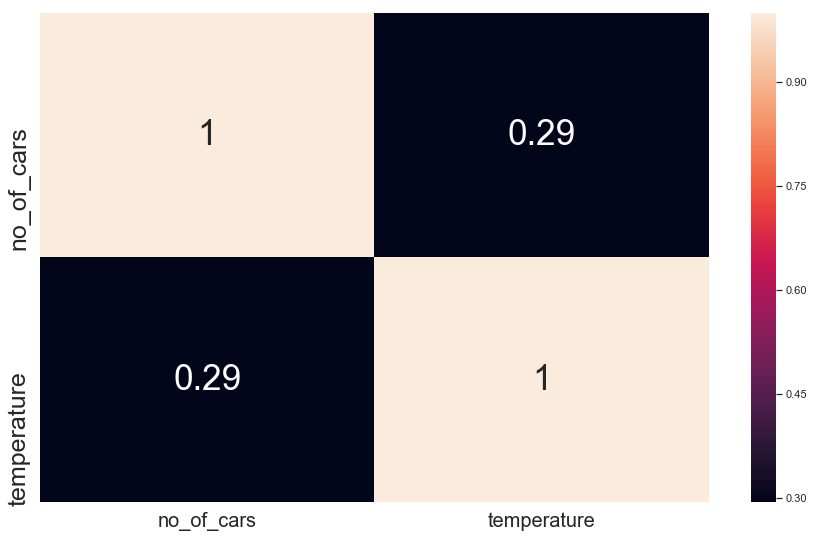

In [799]:
corr = final_merged_df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':35})
heat_map=plt.gcf()
heat_map.set_size_inches(15,9)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.show()

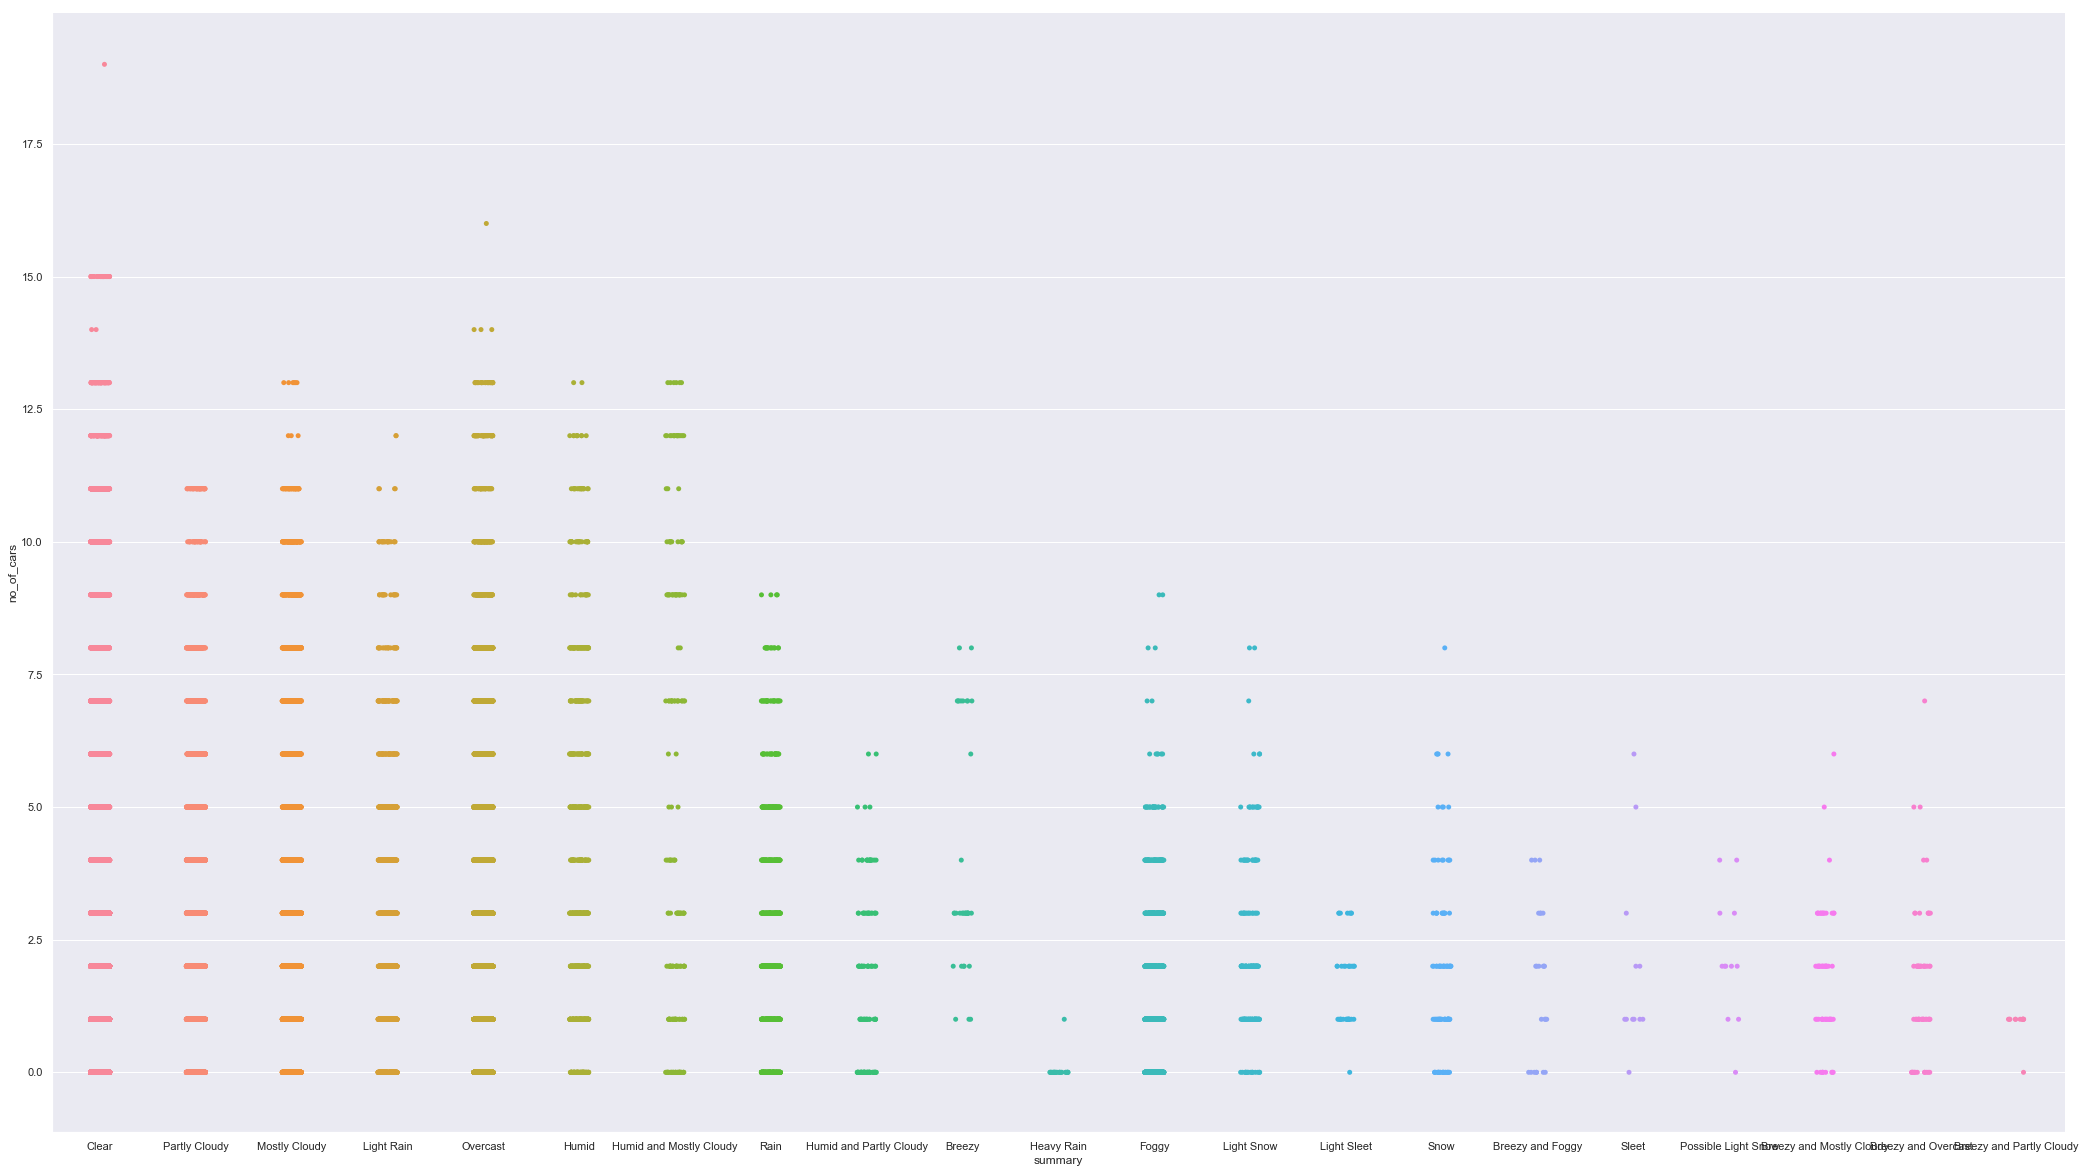

In [921]:
g=sns.catplot(x="summary", y="no_of_cars",  data=final_merged_df)
g.fig.set_size_inches(43,19)

In [930]:
min(final_merged_df.temperature)

-4.48

In [934]:
final_merged_df['temp_bins']=pd.cut(final_merged_df.temperature, [-10,0, 10, 20,30,40,50,60,70,80,90,100], labels=['-10-0'\
                                                                                      ,'0-10'\
                                                                                      ,'10-20'\
                                                                                     ,'20-30'\
                                                                                     ,'30-40'\
                                                                                     ,'40-50'\
                                                                                     ,'50-60'\
                                                                                     ,'60-70'\
                                                                                     ,'70-80'\
                                                                                     ,'80-90'\
                                                                                     ,'90-100'])

In [938]:
final_merged_df.temp_bins.value_counts()

30-40     13908
40-50     12348
20-30     10980
50-60      9588
70-80      7224
60-70      7116
10-20      4284
80-90      3504
0-10        864
90-100      648
-10-0        96
Name: temp_bins, dtype: int64

In [942]:
final_merged_df.groupby(['temp_bins']).count()[['no_of_cars']]

no_of_cars
temp_bins            
-10-0              96
0-10              864
10-20            4284
20-30           10980
30-40           13908
40-50           12348
50-60            9588
60-70            7116
70-80            7224
80-90            3504
90-100            648

In [1066]:
final_merged_df

start_time  no_of_cars summary  temperature temp_bins
0     2018-08-10 00:00:00         0.0   Clear    46.468514     40-50
1     2018-08-10 00:05:00         0.0   Clear    46.468514     40-50
2     2018-08-10 00:10:00         0.0   Clear    46.468514     40-50
3     2018-08-10 00:15:00         0.0   Clear    46.468514     40-50
4     2018-08-10 00:20:00         0.0   Clear    46.468514     40-50
5     2018-08-10 00:25:00         0.0   Clear    46.468514     40-50
6     2018-08-10 00:30:00         0.0   Clear    46.468514     40-50
7     2018-08-10 00:35:00         0.0   Clear    46.468514     40-50
8     2018-08-10 00:40:00         0.0   Clear    46.468514     40-50
9     2018-08-10 00:45:00         0.0   Clear    46.468514     40-50
10    2018-08-10 00:50:00         0.0   Clear    46.468514     40-50
11    2018-08-10 00:55:00         0.0   Clear    46.468514     40-50
12    2018-08-10 01:00:00         0.0   Clear    46.468514     40-50
13    2018-08-10 01:05:00         0.0   Clear    46.468514     40-50
14    2018-08-10 01:10:00         0.0   Clear    46.468514     40-50
15    2018-08-10 01:15:00         0.0   Clear    46.468514     40-50
16    2018-08-10 01:20:00         0.0   Clear    46.468514     40-50
17    2018-08-10 01:25:00         0.0   Clear    46.468514     40-50
18    2018-08-10 01:30:00         0.0   Clear    46.468514     40-50
19    2018-08-10 01:35:00         0.0   Clear    46.468514     40-50
20    2018-08-10 01:40:00         0.0   Clear    46.468514     40-50
21    2018-08-10 01:45:00         0.0   Clear    46.468514     40-50
22    2018-08-10 01:50:00         0.0   Clear    46.468514     40-50
23    2018-08-10 01:55:00         0.0   Clear    46.468514     40-50
24    2018-08-10 02:00:00         0.0   Clear    46.468514     40-50
25    2018-08-10 02:05:00         0.0   Clear    46.468514     40-50
26    2018-08-10 02:10:00         0.0   Clear    46.468514     40-50
27    2018-08-10 02:15:00         0.0   Clear    46.468514     40-50
28    2018-08-10 02:20:00         0.0   Clear    46.468514     40-50
29    2018-08-10 02:25:00         0.0   Clear    46.468514     40-50
...                   ...         ...     ...          ...       ...
70530 2019-04-11 21:30:00         0.0   Clear    46.468514     40-50
70531 2019-04-11 21:35:00         0.0   Clear    46.468514     40-50
70532 2019-04-11 21:40:00         0.0   Clear    46.468514     40-50
70533 2019-04-11 21:45:00         0.0   Clear    46.468514     40-50
70534 2019-04-11 21:50:00         0.0   Clear    46.468514     40-50
70535 2019-04-11 21:55:00         0.0   Clear    46.468514     40-50
70536 2019-04-11 22:00:00         0.0   Clear    46.468514     40-50
70537 2019-04-11 22:05:00         0.0   Clear    46.468514     40-50
70538 2019-04-11 22:10:00         0.0   Clear    46.468514     40-50
70539 2019-04-11 22:15:00         0.0   Clear    46.468514     40-50
70540 2019-04-11 22:20:00         0.0   Clear    46.468514     40-50
70541 2019-04-11 22:25:00         0.0   Clear    46.468514     40-50
70542 2019-04-11 22:30:00         0.0   Clear    46.468514     40-50
70543 2019-04-11 22:35:00         0.0   Clear    46.468514     40-50
70544 2019-04-11 22:40:00         0.0   Clear    46.468514     40-50
70545 2019-04-11 22:45:00         0.0   Clear    46.468514     40-50
70546 2019-04-11 22:50:00         0.0   Clear    46.468514     40-50
70547 2019-04-11 22:55:00         0.0   Clear    46.468514     40-50
70548 2019-04-11 23:00:00         0.0   Clear    46.468514     40-50
70549 2019-04-11 23:05:00         0.0   Clear    46.468514     40-50
70550 2019-04-11 23:10:00         0.0   Clear    46.468514     40-50
70551 2019-04-11 23:15:00         0.0   Clear    46.468514     40-50
70552 2019-04-11 23:20:00         0.0   Clear    46.468514     40-50
70553 2019-04-11 23:25:00         0.0   Clear    46.468514     40-50
70554 2019-04-11 23:30:00         0.0   Clear    46.468514     40-50
70555 2019-04-11 23:35:00         0.0   Clear    46.468514     40-50
70556 2019-04

In [1071]:
z=final_merged_df.groupby(['temp_bins']).sum()[['no_of_cars']]
# z.reset_index(inplace=True)

In [1068]:
z

temp_bins  no_of_cars
0      -10-0       118.0
1       0-10       986.0
2      10-20      5642.0
3      20-30     15662.0
4      30-40     24695.0
5      40-50     28604.0
6      50-60     24558.0
7      60-70     21427.0
8      70-80     21924.0
9      80-90     12681.0
10    90-100      2722.0

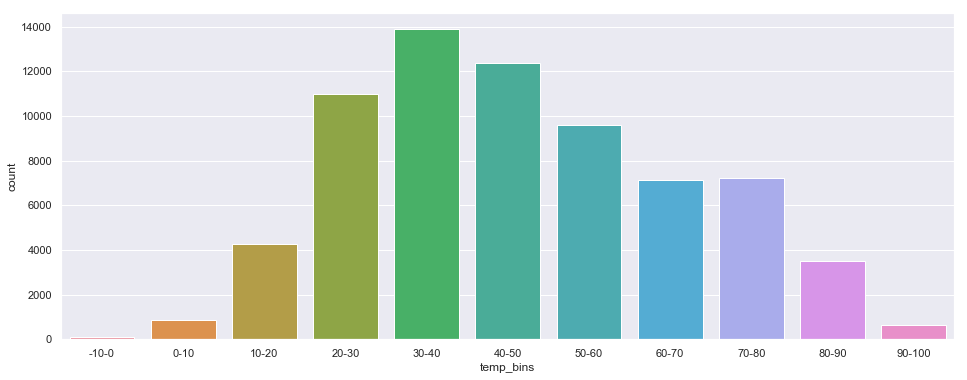

In [1073]:
plt.figure(figsize=(16, 6))
sns.countplot(x=final_merged_df.temp_bins, data=final_merged_df.groupby(['temp_bins']).count()[['no_of_cars']])
# g.fig.set_size_inches(10,3)

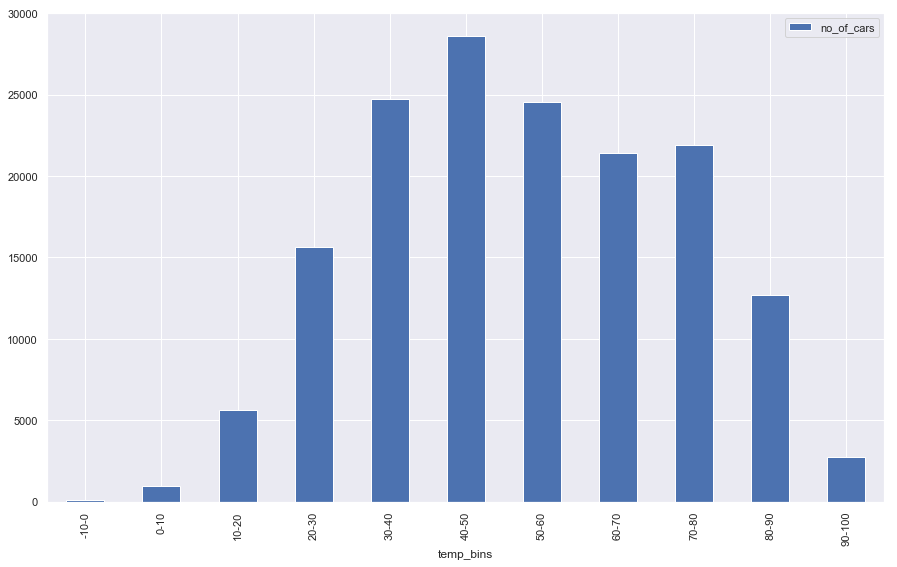

In [1074]:
plt.figure(figsize=(16, 6))
z.plot(kind='bar')

In [ ]:
sns.set(rc={'figure.figsize':(15,9)}

In [1080]:
df_summary.head()

start_time  no_of_cars summary  temperature temp_bins
0 2018-08-10 00:00:00         0.0   Clear    46.468514     40-50
1 2018-08-10 00:05:00         0.0   Clear    46.468514     40-50
2 2018-08-10 00:10:00         0.0   Clear    46.468514     40-50
3 2018-08-10 00:15:00         0.0   Clear    46.468514     40-50
4 2018-08-10 00:20:00         0.0   Clear    46.468514     40-50

In [1087]:
df_summary['summary_category'] = df_summary.summary.replace(['Heavy Rain','Light Sleet'\
                                                             ,'Breezy and Foggy','Sleet'\
                                                             ,'Breezy and Partly Cloudy'],\
                                                   'Extreme')

In [1088]:
df_summary['summary_category'] = df_summary.summary_category.replace(['Rain','Breezy','Foggy',\
                                                             'Light Snow','Breezy and Foggy'\
                                                             ,'Snow','Possible Light Snow'\
                                                            ,'Breezy and Mostly Cloudy',
                                                            'Humid and Partly Cloudy',
                                                            'Breezy and Overcast'],\
                                                   'Moderate')

In [1090]:
df_summary['summary_category'] = df_summary.summary_category.replace(['Overcast','Mostly Cloudy','Partly Cloudy',\
                                                             'Light Rain','Humid'\
                                                             ,'Humid and Mostly Cloudy'],\
                                                   'Clear')

In [1091]:
df_summary.summary_category.value_counts()

Clear       68028
Moderate     2424
Extreme       108
Name: summary_category, dtype: int64

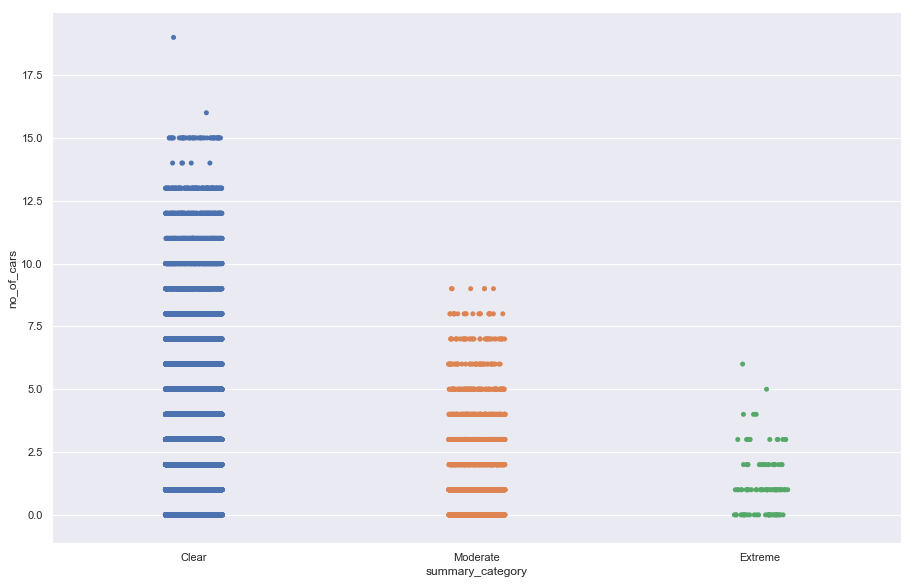

In [1097]:
g=sns.catplot(x="summary_category", y="no_of_cars",  data=df_summary)
g.fig.set_size_inches(15,9)

In [801]:
final_merged_df.no_of_cars.isna().sum()

0

In [802]:
final_merged_df.dropna(inplace=True)

In [803]:
final_merged_df.to_csv('5min_bin_288_parking_formatted.csv')

In [804]:
grouped_test=final_merged_df[['summary', 'no_of_cars']].groupby(['summary'])

In [805]:
from scipy import stats
f_val, p_val = stats.f_oneway(grouped_test.get_group('Clear')['no_of_cars'], grouped_test.get_group('Sleet')['no_of_cars'])  
print( "ANOVA results: F=", f_val, ", P =", p_val )

ANOVA results: F= 0.12013116339950254 , P = 0.7288943700689673


In [807]:
f_val, p_val = stats.f_oneway(grouped_test.get_group('Clear')['no_of_cars'], grouped_test.get_group('Heavy Rain')['no_of_cars'])  
print( "ANOVA results: F=", f_val, ", P =", p_val )

ANOVA results: F= 19.528405683332014 , P = 9.941370854575151e-06


In [808]:
f_val, p_val = stats.f_oneway(grouped_test.get_group('Clear')['no_of_cars'], grouped_test.get_group('Rain')['no_of_cars'])  
print( "ANOVA results: F=", f_val, ", P =", p_val )

ANOVA results: F= 0.2725425905219645 , P = 0.6016345052485266


In [810]:
pearson_coef, p_value = stats.pearsonr(final_merged_df['temperature'], final_merged_df['no_of_cars'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.29328061836742314  with a P-value of P = 0.0


In [815]:
final_merged_df.tail(48)

start_time  no_of_cars summary  temperature
70512 2019-04-11 20:00:00         2.0   Clear    46.468514
70513 2019-04-11 20:05:00         5.0   Clear    46.468514
70514 2019-04-11 20:10:00         4.0   Clear    46.468514
70515 2019-04-11 20:15:00         4.0   Clear    46.468514
70516 2019-04-11 20:20:00         5.0   Clear    46.468514
70517 2019-04-11 20:25:00         2.0   Clear    46.468514
70518 2019-04-11 20:30:00         0.0   Clear    46.468514
70519 2019-04-11 20:35:00         0.0   Clear    46.468514
70520 2019-04-11 20:40:00         0.0   Clear    46.468514
70521 2019-04-11 20:45:00         3.0   Clear    46.468514
70522 2019-04-11 20:50:00         6.0   Clear    46.468514
70523 2019-04-11 20:55:00         3.0   Clear    46.468514
70524 2019-04-11 21:00:00         1.0   Clear    46.468514
70525 2019-04-11 21:05:00         1.0   Clear    46.468514
70526 2019-04-11 21:10:00         1.0   Clear    46.468514
70527 2019-04-11 21:15:00         3.0   Clear    46.468514
70528 2019-04-11 21:20:00         0.0   Clear    46.468514
70529 2019-04-11 21:25:00         0.0   Clear    46.468514
70530 2019-04-11 21:30:00         0.0   Clear    46.468514
70531 2019-04-11 21:35:00         0.0   Clear    46.468514
70532 2019-04-11 21:40:00         0.0   Clear    46.468514
70533 2019-04-11 21:45:00         0.0   Clear    46.468514
70534 2019-04-11 21:50:00         0.0   Clear    46.468514
70535 2019-04-11 21:55:00         0.0   Clear    46.468514
70536 2019-04-11 22:00:00         0.0   Clear    46.468514
70537 2019-04-11 22:05:00         0.0   Clear    46.468514
70538 2019-04-11 22:10:00         0.0   Clear    46.468514
70539 2019-04-11 22:15:00         0.0   Clear    46.468514
70540 2019-04-11 22:20:00         0.0   Clear    46.468514
70541 2019-04-11 22:25:00         0.0   Clear    46.468514
70542 2019-04-11 22:30:00         0.0   Clear    46.468514
70543 2019-04-11 22:35:00         0.0   Clear    46.468514
70544 2019-04-11 22:40:00         0.0   Clear    46.468514
70545 2019-04-11 22:45:00         0.0   Clear    46.468514
70546 2019-04-11 22:50:00         0.0   Clear    46.468514
70547 2019-04-11 22:55:00         0.0   Clear    46.468514
70548 2019-04-11 23:00:00         0.0   Clear    46.468514
70549 2019-04-11 23:05:00         0.0   Clear    46.468514
70550 2019-04-11 23:10:00         0.0   Clear    46.468514
70551 2019-04-11 23:15:00         0.0   Clear    46.468514
70552 2019-04-11 23:20:00         0.0   Clear    46.468514
70553 2019-04-11 23:25:00         0.0   Clear    46.468514
70554 2019-04-11 23:30:00         0.0   Clear    46.468514
70555 2019-04-11 23:35:00         0.0   Clear    46.468514
70556 2019-04-11 23:40:00         0.0   Clear    46.468514
70557 2019-04-11 23:45:00         0.0   Clear    46.468514
70558 2019-04-11 23:50:00         0.0   Clear    46.468514
70559 2019-04-11 23:55:00         0.0   Clear    46.468514

In [ ]:
temp_df1=gdf.loc[(gdf['start_time']=='2018-11-03 13:30:00')]
temp_df=gdf.loc[(gdf['sensor_id']=='SENSITY-kc-14') & (gdf['start_time']=='2018-11-03 13:30:00')]
temp_df1['mc1']=temp_df1.mc.apply(lambda x : Point(list(x.exterior.coords)))
from folium import IFrame
from folium.plugins import MarkerCluster
map = folium.Map([39.10087297922868, -94.58354627591267], zoom_start = 14)

def add_point_clusters(mapobj, gdf, popup_field_list):
    #Create empty lists to contain the point coordinates and the point pop-up information
    coords, popups = [], [] 
    #Loop through each record in the GeoDataFrame
    for i, row in gdf.iterrows():
        #Append lat and long coordinates to "coords" list
        coords.append([row.mc1.y, row.mc1.x])
#         coords.append(row.mc1)
        #Create a string of HTML code used in the IFrame popup
        #Join together the fields in "popup_field_list" with a linebreak between them
        label = '<br>'.join([row[field] for field in popup_field_list])
        #Append an IFrame that uses the HTML string to the "popups" list 
        popups.append(IFrame(label, width = 300, height = 100))
        
    #Create a Folium feature group for this layer, since we will be displaying multiple layers
    pt_lyr = folium.FeatureGroup(name = 'pt_lyr')
    
    #Add the clustered points of crime locations and popups to this layer
    pt_lyr.add_children(MarkerCluster(locations = coords, popups = popups))
    
    #Add this point layer to the map object
    mapobj.add_children(pt_lyr)
    return mapobj

#Update choropleth with point clusters
map = add_point_clusters(map, temp_df1, ['sensor_id'])
folium.LayerControl().add_to(map) #Add layer control to toggle on/off
map.save('nov3rd1:30.html') #save HTML
map

In [816]:
final_merged_df

start_time  no_of_cars summary  temperature
0     2018-08-10 00:00:00         0.0   Clear    46.468514
1     2018-08-10 00:05:00         0.0   Clear    46.468514
2     2018-08-10 00:10:00         0.0   Clear    46.468514
3     2018-08-10 00:15:00         0.0   Clear    46.468514
4     2018-08-10 00:20:00         0.0   Clear    46.468514
5     2018-08-10 00:25:00         0.0   Clear    46.468514
6     2018-08-10 00:30:00         0.0   Clear    46.468514
7     2018-08-10 00:35:00         0.0   Clear    46.468514
8     2018-08-10 00:40:00         0.0   Clear    46.468514
9     2018-08-10 00:45:00         0.0   Clear    46.468514
10    2018-08-10 00:50:00         0.0   Clear    46.468514
11    2018-08-10 00:55:00         0.0   Clear    46.468514
12    2018-08-10 01:00:00         0.0   Clear    46.468514
13    2018-08-10 01:05:00         0.0   Clear    46.468514
14    2018-08-10 01:10:00         0.0   Clear    46.468514
15    2018-08-10 01:15:00         0.0   Clear    46.468514
16    2018-08-10 01:20:00         0.0   Clear    46.468514
17    2018-08-10 01:25:00         0.0   Clear    46.468514
18    2018-08-10 01:30:00         0.0   Clear    46.468514
19    2018-08-10 01:35:00         0.0   Clear    46.468514
20    2018-08-10 01:40:00         0.0   Clear    46.468514
21    2018-08-10 01:45:00         0.0   Clear    46.468514
22    2018-08-10 01:50:00         0.0   Clear    46.468514
23    2018-08-10 01:55:00         0.0   Clear    46.468514
24    2018-08-10 02:00:00         0.0   Clear    46.468514
25    2018-08-10 02:05:00         0.0   Clear    46.468514
26    2018-08-10 02:10:00         0.0   Clear    46.468514
27    2018-08-10 02:15:00         0.0   Clear    46.468514
28    2018-08-10 02:20:00         0.0   Clear    46.468514
29    2018-08-10 02:25:00         0.0   Clear    46.468514
...                   ...         ...     ...          ...
70530 2019-04-11 21:30:00         0.0   Clear    46.468514
70531 2019-04-11 21:35:00         0.0   Clear    46.468514
70532 2019-04-11 21:40:00         0.0   Clear    46.468514
70533 2019-04-11 21:45:00         0.0   Clear    46.468514
70534 2019-04-11 21:50:00         0.0   Clear    46.468514
70535 2019-04-11 21:55:00         0.0   Clear    46.468514
70536 2019-04-11 22:00:00         0.0   Clear    46.468514
70537 2019-04-11 22:05:00         0.0   Clear    46.468514
70538 2019-04-11 22:10:00         0.0   Clear    46.468514
70539 2019-04-11 22:15:00         0.0   Clear    46.468514
70540 2019-04-11 22:20:00         0.0   Clear    46.468514
70541 2019-04-11 22:25:00         0.0   Clear    46.468514
70542 2019-04-11 22:30:00         0.0   Clear    46.468514
70543 2019-04-11 22:35:00         0.0   Clear    46.468514
70544 2019-04-11 22:40:00         0.0   Clear    46.468514
70545 2019-04-11 22:45:00         0.0   Clear    46.468514
70546 2019-04-11 22:50:00         0.0   Clear    46.468514
70547 2019-04-11 22:55:00         0.0   Clear    46.468514
70548 2019-04-11 23:00:00         0.0   Clear    46.468514
70549 2019-04-11 23:05:00         0.0   Clear    46.468514
70550 2019-04-11 23:10:00         0.0   Clear    46.468514
70551 2019-04-11 23:15:00         0.0   Clear    46.468514
70552 2019-04-11 23:20:00         0.0   Clear    46.468514
70553 2019-04-11 23:25:00         0.0   Clear    46.468514
70554 2019-04-11 23:30:00         0.0   Clear    46.468514
70555 2019-04-11 23:35:00         0.0   Clear    46.468514
70556 2019-04-11 23:40:00         0.0   Clear    46.468514
70557 2019-04-11 23:45:00         0.0   Clear    46.468514
70558 2019-04-11 23:50:00         0.0   Clear    46.468514
70559 2019-04-11 23:55:00         0.0   Clear    46.468514

[70560 rows x 4 columns]

In [955]:
final_merged_df[['start_time','no_of_cars']]

start_time  no_of_cars
0     2018-08-10 00:00:00         0.0
1     2018-08-10 00:05:00         0.0
2     2018-08-10 00:10:00         0.0
3     2018-08-10 00:15:00         0.0
4     2018-08-10 00:20:00         0.0
5     2018-08-10 00:25:00         0.0
6     2018-08-10 00:30:00         0.0
7     2018-08-10 00:35:00         0.0
8     2018-08-10 00:40:00         0.0
9     2018-08-10 00:45:00         0.0
10    2018-08-10 00:50:00         0.0
11    2018-08-10 00:55:00         0.0
12    2018-08-10 01:00:00         0.0
13    2018-08-10 01:05:00         0.0
14    2018-08-10 01:10:00         0.0
15    2018-08-10 01:15:00         0.0
16    2018-08-10 01:20:00         0.0
17    2018-08-10 01:25:00         0.0
18    2018-08-10 01:30:00         0.0
19    2018-08-10 01:35:00         0.0
20    2018-08-10 01:40:00         0.0
21    2018-08-10 01:45:00         0.0
22    2018-08-10 01:50:00         0.0
23    2018-08-10 01:55:00         0.0
24    2018-08-10 02:00:00         0.0
25    2018-08-10 02:05:00         0.0
26    2018-08-10 02:10:00         0.0
27    2018-08-10 02:15:00         0.0
28    2018-08-10 02:20:00         0.0
29    2018-08-10 02:25:00         0.0
...                   ...         ...
70530 2019-04-11 21:30:00         0.0
70531 2019-04-11 21:35:00         0.0
70532 2019-04-11 21:40:00         0.0
70533 2019-04-11 21:45:00         0.0
70534 2019-04-11 21:50:00         0.0
70535 2019-04-11 21:55:00         0.0
70536 2019-04-11 22:00:00         0.0
70537 2019-04-11 22:05:00         0.0
70538 2019-04-11 22:10:00         0.0
70539 2019-04-11 22:15:00         0.0
70540 2019-04-11 22:20:00         0.0
70541 2019-04-11 22:25:00         0.0
70542 2019-04-11 22:30:00         0.0
70543 2019-04-11 22:35:00         0.0
70544 2019-04-11 22:40:00         0.0
70545 2019-04-11 22:45:00         0.0
70546 2019-04-11 22:50:00         0.0
70547 2019-04-11 22:55:00         0.0
70548 2019-04-11 23:00:00         0.0
70549 2019-04-11 23:05:00         0.0
70550 2019-04-11 23:10:00         0.0
70551 2019-04-11 23:15:00         0.0
70552 2019-04-11 23:20:00         0.0
70553 2019-04-11 23:25:00         0.0
70554 2019-04-11 23:30:00         0.0
70555 2019-04-11 23:35:00         0.0
70556 2019-04-11 23:40:00         0.0
70557 2019-04-11 23:45:00         0.0
70558 2019-04-11 23:50:00         0.0
70559 2019-04-11 23:55:00         0.0

[70560 rows x 2 columns]

In [952]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [995]:
dft = final_merged_df.iloc[:-288][['start_time','no_of_cars']]
dft.columns = ['ds', 'y']
dft.head()

ds    y
0 2018-08-10 00:00:00  0.0
1 2018-08-10 00:05:00  0.0
2 2018-08-10 00:10:00  0.0
3 2018-08-10 00:15:00  0.0
4 2018-08-10 00:20:00  0.0

In [996]:
dft.tail()

ds    y
70267 2019-04-10 23:35:00  3.0
70268 2019-04-10 23:40:00  2.0
70269 2019-04-10 23:45:00  3.0
70270 2019-04-10 23:50:00  0.0
70271 2019-04-10 23:55:00  0.0

In [997]:
size1 = int(len(final_merged_df) * 0.66)
train1, test1 = dft[0:size1], dft[size1:len(final_merged_df)]

In [999]:
prediction_size = 288
train_df = dft[:-prediction_size]

In [1000]:
len(train_df)

69984

In [1001]:
m = Prophet()
m.fit(train_df)

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [1002]:
future = m.make_future_dataframe(periods=prediction_size, freq = "5Min")
forecast = m.predict(future)
forecast.head()

ds     trend  trend_lower  trend_upper  yhat_lower  \
0 2018-08-10 00:00:00  2.515018     2.515018     2.515018    0.629377   
1 2018-08-10 00:05:00  2.515248     2.515248     2.515248    0.546309   
2 2018-08-10 00:10:00  2.515477     2.515477     2.515477    0.506463   
3 2018-08-10 00:15:00  2.515707     2.515707     2.515707    0.619177   
4 2018-08-10 00:20:00  2.515936     2.515936     2.515936    0.591878   

   yhat_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    5.852248        0.746655              0.746655              0.746655   
1    6.110551        0.736436              0.736436              0.736436   
2    5.626337        0.725698              0.725698              0.725698   
3    6.005349        0.714463              0.714463              0.714463   
4    5.901360        0.702756              0.702756              0.702756   

      daily  daily_lower  daily_upper  multiplicative_terms  \
0  0.752236     0.752236     0.752236                   0.0   
1  0.742409     0.742409     0.742409                   0.0   
2  0.732061     0.732061     0.732061                   0.0   
3  0.721216     0.721216     0.721216                   0.0   
4  0.709897     0.709897     0.709897                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper    weekly  \
0                         0.0                         0.0 -0.005581   
1                         0.0                         0.0 -0.005973   
2                         0.0                         0.0 -0.006363   
3                         0.0                         0.0 -0.006753   
4                         0.0                         0.0 -0.007141   

   weekly_lower  weekly_upper      yhat  
0     -0.005581     -0.005581  3.261673  
1     -0.005973     -0.005973  3.251684  
2     -0.006363     -0.006363  3.241175  
3     -0.006753     -0.006753  3.230170  
4     -0.007141     -0.007141  3.218692

In [1003]:
forecast.tail()

ds     trend  trend_lower  trend_upper  yhat_lower  \
70267 2019-04-10 23:35:00  1.726724     1.726724     1.726724   -0.085352   
70268 2019-04-10 23:40:00  1.726745     1.726745     1.726745   -0.001065   
70269 2019-04-10 23:45:00  1.726767     1.726767     1.726767   -0.027117   
70270 2019-04-10 23:50:00  1.726788     1.726788     1.726788   -0.132819   
70271 2019-04-10 23:55:00  1.726809     1.726809     1.726809   -0.177498   

       yhat_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
70267    5.183415        0.891956              0.891956              0.891956   
70268    4.998908        0.884886              0.884886              0.884886   
70269    5.142140        0.877188              0.877188              0.877188   
70270    5.136768        0.868883              0.868883              0.868883   
70271    5.120954        0.859991              0.859991              0.859991   

          daily  daily_lower  daily_upper  multiplicative_terms  \
70267  0.792810     0.792810     0.792810                   0.0   
70268  0.785906     0.785906     0.785906                   0.0   
70269  0.778377     0.778377     0.778377                   0.0   
70270  0.770242     0.770242     0.770242                   0.0   
70271  0.761521     0.761521     0.761521                   0.0   

       multiplicative_terms_lower  multiplicative_terms_upper    weekly  \
70267                         0.0                         0.0  0.099146   
70268                         0.0                         0.0  0.098979   
70269                         0.0                         0.0  0.098812   
70270                         0.0                         0.0  0.098642   
70271                         0.0                         0.0  0.098470   

       weekly_lower  weekly_upper      yhat  
70267      0.099146      0.099146  2.618680  
70268      0.098979      0.098979  2.611631  
70269      0.098812      0.098812  2.603955  
70270      0.098642      0.098642  2.595671  
70271      0.098470      0.098470  2.586800

In [965]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [1004]:
cmp_df = make_comparison_dataframe(dft, forecast)
cmp_df.tail(120)

yhat  yhat_lower  yhat_upper    y
ds                                                        
2019-04-10 14:00:00  1.818518   -1.071034    4.499924  1.0
2019-04-10 14:05:00  1.842319   -0.866567    4.290819  2.0
2019-04-10 14:10:00  1.864958   -0.846350    4.417714  1.0
2019-04-10 14:15:00  1.886405   -0.681292    4.555213  0.0
2019-04-10 14:20:00  1.906633   -0.650619    4.475064  1.0
2019-04-10 14:25:00  1.925620   -0.902873    4.655103  4.0
2019-04-10 14:30:00  1.943352   -0.854728    4.439061  5.0
2019-04-10 14:35:00  1.959819   -0.738868    4.617780  3.0
2019-04-10 14:40:00  1.975018   -0.695933    4.493368  3.0
2019-04-10 14:45:00  1.988951   -0.610201    4.722962  4.0
2019-04-10 14:50:00  2.001626   -0.745592    4.634566  1.0
2019-04-10 14:55:00  2.013058   -0.548054    4.586053  3.0
2019-04-10 15:00:00  2.023265   -0.570948    4.626458  1.0
2019-04-10 15:05:00  2.032271   -0.649421    4.631814  1.0
2019-04-10 15:10:00  2.040106   -0.742687    4.744010  1.0
2019-04-10 15:15:00  2.046804   -0.559588    4.678060  3.0
2019-04-10 15:20:00  2.052405   -0.406798    4.687853  2.0
2019-04-10 15:25:00  2.056952   -0.434734    4.859536  4.0
2019-04-10 15:30:00  2.060493   -0.740158    4.614119  2.0
2019-04-10 15:35:00  2.063080   -0.637779    4.756364  2.0
2019-04-10 15:40:00  2.064767   -0.725098    4.827102  2.0
2019-04-10 15:45:00  2.065614   -0.583963    4.880688  4.0
2019-04-10 15:50:00  2.065681   -0.396329    4.821822  2.0
2019-04-10 15:55:00  2.065033   -0.564173    4.691742  3.0
2019-04-10 16:00:00  2.063735   -0.630535    4.808623  1.0
2019-04-10 16:05:00  2.061857   -0.503983    4.707779  0.0
2019-04-10 16:10:00  2.059467   -0.587024    4.674486  2.0
2019-04-10 16:15:00  2.056637   -0.418273    4.675682  2.0
2019-04-10 16:20:00  2.053438   -0.642440    4.592222  2.0
2019-04-10 16:25:00  2.049941   -0.707042    4.683380  3.0
...                       ...         ...         ...  ...
2019-04-10 21:30:00  2.557876    0.019108    5.143906  2.0
2019-04-10 21:35:00  2.569140   -0.222962    5.049890  3.0
2019-04-10 21:40:00  2.579752   -0.087970    5.189007  5.0
2019-04-10 21:45:00  2.589689   -0.073371    5.349472  1.0
2019-04-10 21:50:00  2.598929    0.133547    5.352229  1.0
2019-04-10 21:55:00  2.607456   -0.135235    5.270074  2.0
2019-04-10 22:00:00  2.615253   -0.013401    5.280742  3.0
2019-04-10 22:05:00  2.622306    0.048237    5.243085  6.0
2019-04-10 22:10:00  2.628603   -0.049651    5.603041  1.0
2019-04-10 22:15:00  2.634135   -0.140566    5.293989  1.0
2019-04-10 22:20:00  2.638895    0.046081    5.241419  3.0
2019-04-10 22:25:00  2.642878   -0.075893    5.185201  3.0
2019-04-10 22:30:00  2.646080    0.089329    5.282287  3.0
2019-04-10 22:35:00  2.648502   -0.066492    5.187207  2.0
2019-04-10 22:40:00  2.650143   -0.040040    5.434960  1.0
2019-04-10 22:45:00  2.651007   -0.160021    5.260229  2.0
2019-04-10 22:50:00  2.651098    0.070369    5.391052  2.0
2019-04-10 22:55:00  2.650422    0.195372    5.354351  3.0
2019-04-10 23:00:00  2.648988   -0.008091    5.262746  4.0
2019-04-10 23:05:00  2.646805    0.001065    5.208455  1.0
2019-04-10 23:10:00  2.643883    0.089110    5.472249  1.0
2019-04-10 23:15:00  2.640236    0.132264    5.206289  1.0
2019-04-10 23:20:00  2.635877    0.052713    5.253683  3.0
2019-04-10 23:25:00  2.630820    0.012628    5.467470  2.0
2019-04-10 23:30:00  2.625082    0.059232    5.391746  5.0
2019-04-10 23:35:00  2.618680   -0.085352    5.183415  3.0
2019-04-10 23:40:00  2.611631   -0.001065    4.998908  2.0
2019-04-10 23:45:00  2.603955   -0.027117    5.142140  3.0
2019-04-10 23:50:00  2.595671   -0.132819    5.136768  0.0
2019-04-10 23:55:00  2.586800   -0.177498    5.120954  0.0

[120 rows x 4 columns]

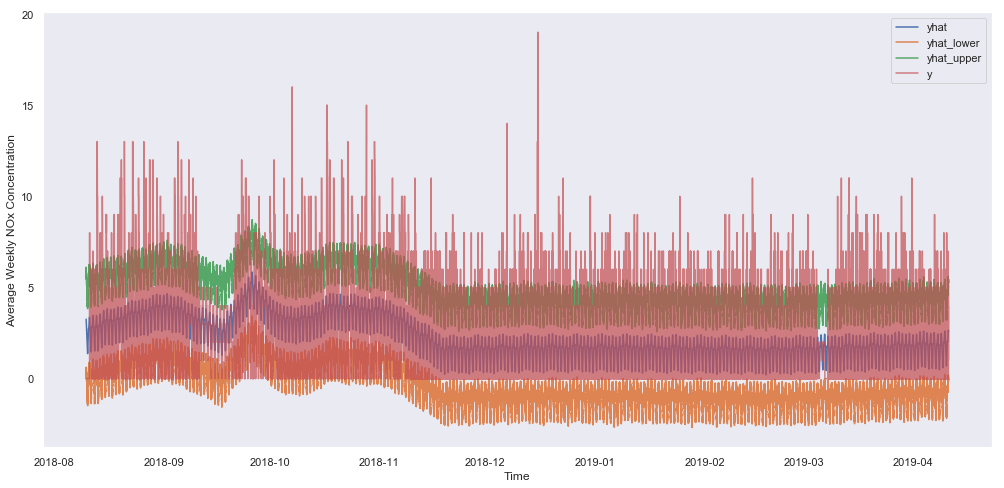

In [1005]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'],alpha=0.7)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()

In [1006]:
cmp_df

yhat  yhat_lower  yhat_upper    y
ds                                                        
2018-08-10 00:00:00  3.261673    0.629377    5.852248  0.0
2018-08-10 00:05:00  3.251684    0.546309    6.110551  0.0
2018-08-10 00:10:00  3.241175    0.506463    5.626337  0.0
2018-08-10 00:15:00  3.230170    0.619177    6.005349  0.0
2018-08-10 00:20:00  3.218692    0.591878    5.901360  0.0
2018-08-10 00:25:00  3.206764    0.444198    5.926301  0.0
2018-08-10 00:30:00  3.194409    0.410545    5.881101  0.0
2018-08-10 00:35:00  3.181653    0.587123    6.010655  0.0
2018-08-10 00:40:00  3.168519    0.304112    5.781463  0.0
2018-08-10 00:45:00  3.155030    0.501295    5.874860  0.0
2018-08-10 00:50:00  3.141212    0.564573    5.970924  0.0
2018-08-10 00:55:00  3.127089    0.274768    5.855779  0.0
2018-08-10 01:00:00  3.112685    0.456854    5.857385  0.0
2018-08-10 01:05:00  3.098024    0.372405    5.944897  0.0
2018-08-10 01:10:00  3.083130    0.453564    5.892668  0.0
2018-08-10 01:15:00  3.068026    0.367137    5.608740  0.0
2018-08-10 01:20:00  3.052737    0.455950    5.728795  0.0
2018-08-10 01:25:00  3.037286    0.597046    5.706577  0.0
2018-08-10 01:30:00  3.021695    0.466383    5.752447  0.0
2018-08-10 01:35:00  3.005987    0.335066    5.573689  0.0
2018-08-10 01:40:00  2.990184    0.389940    5.468131  0.0
2018-08-10 01:45:00  2.974308    0.232018    5.721212  0.0
2018-08-10 01:50:00  2.958379    0.374949    5.557355  0.0
2018-08-10 01:55:00  2.942418    0.217931    5.593792  0.0
2018-08-10 02:00:00  2.926445    0.552532    5.657343  0.0
2018-08-10 02:05:00  2.910478    0.299062    5.506548  0.0
2018-08-10 02:10:00  2.894537    0.526386    5.821959  0.0
2018-08-10 02:15:00  2.878637    0.081374    5.541422  0.0
2018-08-10 02:20:00  2.862797    0.271928    5.535312  0.0
2018-08-10 02:25:00  2.847030    0.220253    5.438948  0.0
...                       ...         ...         ...  ...
2019-04-10 21:30:00  2.557876    0.019108    5.143906  2.0
2019-04-10 21:35:00  2.569140   -0.222962    5.049890  3.0
2019-04-10 21:40:00  2.579752   -0.087970    5.189007  5.0
2019-04-10 21:45:00  2.589689   -0.073371    5.349472  1.0
2019-04-10 21:50:00  2.598929    0.133547    5.352229  1.0
2019-04-10 21:55:00  2.607456   -0.135235    5.270074  2.0
2019-04-10 22:00:00  2.615253   -0.013401    5.280742  3.0
2019-04-10 22:05:00  2.622306    0.048237    5.243085  6.0
2019-04-10 22:10:00  2.628603   -0.049651    5.603041  1.0
2019-04-10 22:15:00  2.634135   -0.140566    5.293989  1.0
2019-04-10 22:20:00  2.638895    0.046081    5.241419  3.0
2019-04-10 22:25:00  2.642878   -0.075893    5.185201  3.0
2019-04-10 22:30:00  2.646080    0.089329    5.282287  3.0
2019-04-10 22:35:00  2.648502   -0.066492    5.187207  2.0
2019-04-10 22:40:00  2.650143   -0.040040    5.434960  1.0
2019-04-10 22:45:00  2.651007   -0.160021    5.260229  2.0
2019-04-10 22:50:00  2.651098    0.070369    5.391052  2.0
2019-04-10 22:55:00  2.650422    0.195372    5.354351  3.0
2019-04-10 23:00:00  2.648988   -0.008091    5.262746  4.0
2019-04-10 23:05:00  2.646805    0.001065    5.208455  1.0
2019-04-10 23:10:00  2.643883    0.089110    5.472249  1.0
2019-04-10 23:15:00  2.640236    0.132264    5.206289  1.0
2019-04-10 23:20:00  2.635877    0.052713    5.253683  3.0
2019-04-10 23:25:00  2.630820    0.012628    5.467470  2.0
2019-04-10 23:30:00  2.625082    0.059232    5.391746  5.0
2019-04-10 23:35:00  2.618680   -0.085352    5.183415  3.0
2019-04-10 23:40:00  2.611631   -0.001065    4.998908  2.0
2019-04-10 23:45:00  2.603955   -0.027117    5.142140  3.0
2019-04-10 23:50:00  2.595671   -0.132819    5.136768  0.0
2019-04-10 23:55:00  2.586800   -0.177498    5.120954  0.0

[70272 rows x 4 columns]

In [1022]:
fb_df=forecast[['ds','yhat','yhat_upper','yhat_lower']]
fb_df.rename(columns={'ds':'start_time','yhat':'no_of_cars','yhat_upper':'upper','yhat_lower':'lower'},inplace=True)
fb_df['no_of_cars']=fb_df.no_of_cars.round()
fb_df['upper']=fb_df.upper.round()
fb_df['lower']=fb_df.lower.round()

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [1023]:
fb_df.tail()

start_time  no_of_cars  upper  lower
70267 2019-04-10 23:35:00         3.0    5.0   -0.0
70268 2019-04-10 23:40:00         3.0    5.0   -0.0
70269 2019-04-10 23:45:00         3.0    5.0   -0.0
70270 2019-04-10 23:50:00         3.0    5.0   -0.0
70271 2019-04-10 23:55:00         3.0    5.0   -0.0

In [1024]:
fb_df.iloc[-300:]

start_time  no_of_cars  upper  lower
69972 2019-04-09 23:00:00         3.0    5.0   -0.0
69973 2019-04-09 23:05:00         3.0    5.0   -0.0
69974 2019-04-09 23:10:00         3.0    5.0    0.0
69975 2019-04-09 23:15:00         3.0    5.0   -0.0
69976 2019-04-09 23:20:00         3.0    5.0   -0.0
69977 2019-04-09 23:25:00         3.0    5.0    0.0
69978 2019-04-09 23:30:00         3.0    5.0   -0.0
69979 2019-04-09 23:35:00         3.0    5.0   -0.0
69980 2019-04-09 23:40:00         3.0    5.0   -0.0
69981 2019-04-09 23:45:00         3.0    5.0   -0.0
69982 2019-04-09 23:50:00         3.0    5.0   -0.0
69983 2019-04-09 23:55:00         3.0    5.0   -0.0
69984 2019-04-10 00:00:00         3.0    5.0   -0.0
69985 2019-04-10 00:05:00         3.0    5.0   -0.0
69986 2019-04-10 00:10:00         3.0    5.0   -0.0
69987 2019-04-10 00:15:00         3.0    5.0   -0.0
69988 2019-04-10 00:20:00         3.0    5.0   -0.0
69989 2019-04-10 00:25:00         2.0    5.0   -0.0
69990 2019-04-10 00:30:00         2.0    5.0    0.0
69991 2019-04-10 00:35:00         2.0    5.0   -0.0
69992 2019-04-10 00:40:00         2.0    5.0   -0.0
69993 2019-04-10 00:45:00         2.0    5.0   -0.0
69994 2019-04-10 00:50:00         2.0    5.0   -0.0
69995 2019-04-10 00:55:00         2.0    5.0   -0.0
69996 2019-04-10 01:00:00         2.0    5.0    0.0
69997 2019-04-10 01:05:00         2.0    5.0   -0.0
69998 2019-04-10 01:10:00         2.0    5.0   -0.0
69999 2019-04-10 01:15:00         2.0    5.0   -0.0
70000 2019-04-10 01:20:00         2.0    5.0   -0.0
70001 2019-04-10 01:25:00         2.0    5.0   -0.0
...                   ...         ...    ...    ...
70242 2019-04-10 21:30:00         3.0    5.0    0.0
70243 2019-04-10 21:35:00         3.0    5.0   -0.0
70244 2019-04-10 21:40:00         3.0    5.0   -0.0
70245 2019-04-10 21:45:00         3.0    5.0   -0.0
70246 2019-04-10 21:50:00         3.0    5.0    0.0
70247 2019-04-10 21:55:00         3.0    5.0   -0.0
70248 2019-04-10 22:00:00         3.0    5.0   -0.0
70249 2019-04-10 22:05:00         3.0    5.0    0.0
70250 2019-04-10 22:10:00         3.0    6.0   -0.0
70251 2019-04-10 22:15:00         3.0    5.0   -0.0
70252 2019-04-10 22:20:00         3.0    5.0    0.0
70253 2019-04-10 22:25:00         3.0    5.0   -0.0
70254 2019-04-10 22:30:00         3.0    5.0    0.0
70255 2019-04-10 22:35:00         3.0    5.0   -0.0
70256 2019-04-10 22:40:00         3.0    5.0   -0.0
70257 2019-04-10 22:45:00         3.0    5.0   -0.0
70258 2019-04-10 22:50:00         3.0    5.0    0.0
70259 2019-04-10 22:55:00         3.0    5.0    0.0
70260 2019-04-10 23:00:00         3.0    5.0   -0.0
70261 2019-04-10 23:05:00         3.0    5.0    0.0
70262 2019-04-10 23:10:00         3.0    5.0    0.0
70263 2019-04-10 23:15:00         3.0    5.0    0.0
70264 2019-04-10 23:20:00         3.0    5.0    0.0
70265 2019-04-10 23:25:00         3.0    5.0    0.0
70266 2019-04-10 23:30:00         3.0    5.0    0.0
70267 2019-04-10 23:35:00         3.0    5.0   -0.0
70268 2019-04-10 23:40:00         3.0    5.0   -0.0
70269 2019-04-10 23:45:00         3.0    5.0   -0.0
70270 2019-04-10 23:50:00         3.0    5.0   -0.0
70271 2019-04-10 23:55:00         3.0    5.0   -0.0

[300 rows x 4 columns]

In [1020]:
final_merged_df.iloc[-300:][['start_time','no_of_cars']]

start_time  no_of_cars
70260 2019-04-10 23:00:00         4.0
70261 2019-04-10 23:05:00         1.0
70262 2019-04-10 23:10:00         1.0
70263 2019-04-10 23:15:00         1.0
70264 2019-04-10 23:20:00         3.0
70265 2019-04-10 23:25:00         2.0
70266 2019-04-10 23:30:00         5.0
70267 2019-04-10 23:35:00         3.0
70268 2019-04-10 23:40:00         2.0
70269 2019-04-10 23:45:00         3.0
70270 2019-04-10 23:50:00         0.0
70271 2019-04-10 23:55:00         0.0
70272 2019-04-11 00:00:00         0.0
70273 2019-04-11 00:05:00         1.0
70274 2019-04-11 00:10:00         1.0
70275 2019-04-11 00:15:00         1.0
70276 2019-04-11 00:20:00         2.0
70277 2019-04-11 00:25:00         2.0
70278 2019-04-11 00:30:00         2.0
70279 2019-04-11 00:35:00         2.0
70280 2019-04-11 00:40:00         0.0
70281 2019-04-11 00:45:00         0.0
70282 2019-04-11 00:50:00         3.0
70283 2019-04-11 00:55:00         8.0
70284 2019-04-11 01:00:00         4.0
70285 2019-04-11 01:05:00         4.0
70286 2019-04-11 01:10:00         1.0
70287 2019-04-11 01:15:00         1.0
70288 2019-04-11 01:20:00         1.0
70289 2019-04-11 01:25:00         3.0
...                   ...         ...
70530 2019-04-11 21:30:00         0.0
70531 2019-04-11 21:35:00         0.0
70532 2019-04-11 21:40:00         0.0
70533 2019-04-11 21:45:00         0.0
70534 2019-04-11 21:50:00         0.0
70535 2019-04-11 21:55:00         0.0
70536 2019-04-11 22:00:00         0.0
70537 2019-04-11 22:05:00         0.0
70538 2019-04-11 22:10:00         0.0
70539 2019-04-11 22:15:00         0.0
70540 2019-04-11 22:20:00         0.0
70541 2019-04-11 22:25:00         0.0
70542 2019-04-11 22:30:00         0.0
70543 2019-04-11 22:35:00         0.0
70544 2019-04-11 22:40:00         0.0
70545 2019-04-11 22:45:00         0.0
70546 2019-04-11 22:50:00         0.0
70547 2019-04-11 22:55:00         0.0
70548 2019-04-11 23:00:00         0.0
70549 2019-04-11 23:05:00         0.0
70550 2019-04-11 23:10:00         0.0
70551 2019-04-11 23:15:00         0.0
70552 2019-04-11 23:20:00         0.0
70553 2019-04-11 23:25:00         0.0
70554 2019-04-11 23:30:00         0.0
70555 2019-04-11 23:35:00         0.0
70556 2019-04-11 23:40:00         0.0
70557 2019-04-11 23:45:00         0.0
70558 2019-04-11 23:50:00         0.0
70559 2019-04-11 23:55:00         0.0

[300 rows x 2 columns]

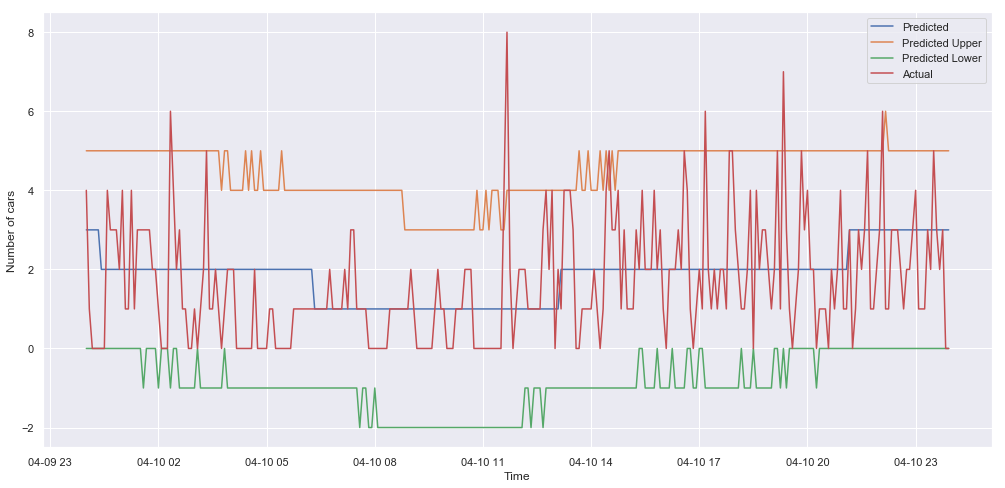

In [1033]:
plt.figure(figsize=(17, 8))
plt.plot(fb_df.iloc[-288:].set_index('start_time')[['no_of_cars']],label='Predicted')
plt.plot(fb_df.iloc[-288:].set_index('start_time')[['upper']],label='Predicted Upper')
plt.plot(fb_df.iloc[-288:].set_index('start_time')[['lower']],label='Predicted Lower')
plt.plot(dft.iloc[-288:][['ds','y']].set_index('ds'),label='Actual')
# plt.plot(cmp_df['yhat_upper'])
# plt.plot(cmp_df['y'],alpha=0.7)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Number of cars')
# plt.grid(False)
plt.show()

In [1016]:
from sklearn.metrics import mean_squared_error
import math
print(math.sqrt(mean_squared_error(fb_df.iloc[-288:].no_of_cars, dft.iloc[-288:].y)))

1.4918761491640131
